# Computational Study of PVF Motifs for [Flour. Poly. Paper](**Insert arxiv link pleease!**)

This notebook contains **most** of the code used to generate the results pertaining to PVF in the paper.
The most noteable omission is the code used to generate the slip deformations and the subsequent generation of the $\gamma$-surfaces.
The remaining omitted steps should be trivial to reproduce and (most) are pointed out below.

The results for PVDF are obtain by modifying the relevant code to use the $\beta$-PVDF structure. 
The fully relaxed vdW-DF-cx (CX) structure (initially obtained from Pelizza et al.) is found in the ```beta-pvdf.cif``` file.

### Table of Contents:

**0. Initialization**
   0.1 Load modules and define constants used throughout the notebook
   0.2 Define helper functions for plotting, visualization and database retrieval
   0.3 Define functions to modify the polymer structures; some are for analysis and some 
      are used later in the notebook to create DFT inputs. 

**1. Generate Input Database**
   Create a database of all initial guesses or PVF motifs based on the ```.cif``` files in the CWD.
   1.1 The database of the initial motif also supplied in the repo as ```initial_12.db``` file.

   TODO: -> Explain the keys "a, alpha, b, beta, c, df, gamma, init_coh_ene, init_str, init_vol, motif, rlx_coh_ene, rlx_tot_ene, rlxd_vol"

   ***Omitted Step:*** *The relaxation of the initial 12 motifs. The relaxation was done using the vdW-DF-cx functional in the QE code, using the same input parameters (including PPS etc) as specified in section 3.*

**2. Generate DFT Inputs**

**3. DFT Calcs**

**4. Post-Processing & Analysis**
   4.1 Load the DFT results and analyze the PVF motifs
   4.2 Analyze the PVF motifs in the context of the Flour. Poly. paper


### Dependencies:
 - The project relies heavily on the Atomic Simulation Environment (ASE) library to:
   - Manipulate polymer structures.
   - Generate DFT inputs.
   - Run DFT calculations.
- The mathematical operations are done using the numpy library.
- Scipy is used to perform data fitting.
- LMFit is also used to fit the data to a model [**REMOVE THIS BEFORE GOING PUBLIC!**].


---

## <p style="text-align: center;">0. Initialization</p>

### Set up the Python environment, define functions and helper functions needed for analysis and structure manipulation

We mainly rely on ASE and it's ```Atoms``` obect to treat individual structures and the ```database``` object for 
storing said structures. 

### 0.1 Load modules

In [3]:
# Standard library imports for file manipulation, mathematical operations, pattern matching, etc.
import os
import glob
import math
import re
import copy
import time
from itertools import permutations, groupby
from collections import Counter

# Import numpy for numerical operations, with linear algebra sub-module
import numpy as np
from numpy import linalg as LA
from numpy import linspace,polyfit

# Import Model from lmfit for fitting models to data
from lmfit import Model
# Import curve_fit from scipy.optimize for fitting models to data
from scipy.optimize import curve_fit

# Matplotlib imports for plotting 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.patches import FancyArrow
from matplotlib.colors import PowerNorm
from matplotlib.gridspec import GridSpec
from matplotlib.transforms import Bbox
# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# ASE (Atomic Simulation Environment) imports for handling atomic structures and simulations
from ase import Atoms, Atom

# Units conversion and database connections within ASE
import ase.units
RYD_TO_EV  = ase.units.Rydberg  # Conversion factor from Rydberg to eV
import ase.db 
from ase.db import connect  # To connect to ASE databases
from ase.db import sqlite
from ase.io import read, write, iread  # For input/output operations in ASE
# ev/Å^3 to GPa
AU_TO_GPa = 160.21766208

# Visualization tools within ASE
import ase.visualize
from ase.visualize import view  # To view atomic structures

# Additional ASE tools for structure building and analysis
import ase.build
from ase.data import covalent_radii
from ase.neighborlist import natural_cutoffs, NeighborList
from ase.geometry import cellpar_to_cell

# ASE calculators we need to run Quantum Espresso, VASP, etc.
from ase.calculators.singlepoint import SinglePointCalculator  # For assigning energies, forces, etc., without actual calculation
from ase.calculators.espresso import Espresso  # Interface to Quantum Espresso


# Monomer energy, computed in QE using a cell of XXX Å^3 with a k-point grid of XXX
MONO_ENE = -74.057564833
REF_ENE  = 2*MONO_ENE*RYD_TO_EV


db_name = 'relaxed_structures.analysis.db'

### 0.2 Helper functions for plotting, visualization and database retrieval

In [4]:
# Call this function whenever you want to close all instances of the view() windows
def close_ase_view_windows():
    windows = gw.getAllTitles()
    for title in windows:
        if '@' in title.lower():
            win = gw.getWindowsWithTitle(title)[0]
            win.close()


def setup_matplotlib(width='column', height=None, packages=None, scale=1.0):
    """
    Setup matplotlib for plotting with LaTeX.

    Parameters:
    -----------
    width: str or float, optional
        Width of the figure. If it's 'column', use the predefined width.
        If it's 'text', use twice the current width. If it's a number, use the number.
        Width should be in cm. Default is 'column'.
    height: float, optional
        Height of the figure. If not supplied use the default ratio.
        Height should be in cm. Default is None.
    packages: list of str, optional
        List of LaTeX packages to add to the preamble. Each element should be the name of a package.
        If None, default packages are used. Default is None.
    """
    # Conversion factor for cm to inches
    cm = 1 / 2.54

    # Define default width and height
    if width == 'column':
        fig_width = 8.6 * cm
    elif width == 'full':
        fig_width = 2 * 8.6 * cm
    else:
        fig_width = width * cm

    # If height is not supplied, use the default ratio
    if height is None:
        fig_height = fig_width * 8 / 6.8
    else:
        fig_height = height * cm

    # Reset parameters before setting up LaTeX plotting
    matplotlib.rcdefaults()
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)

    # Setup LaTeX plotting
    matplotlib.rcParams.update({
        'text.usetex': True,
        'font.family': 'serif',
        'axes.labelsize':  int(11*scale),
        'axes.titlesize':  int(13*scale),
        'legend.fontsize': int(11*scale),
        'xtick.labelsize': int(11*scale),
        'ytick.labelsize': int(11*scale),
        'figure.figsize': [fig_width, fig_height]
    })

    # Add packages to the LaTeX preamble
    if packages is None:
        packages = ['siunitx', 'amsmath', 'amssymb', 'physics', 'bm', 'mhchem', 'mathtools', 'xfrac']

    preamble = ''.join(r'\usepackage{' + pkg + '}' for pkg in packages) + "\DeclareMathSymbol{\shortminus}{\mathbin}{AMSa}{\"39}"
    matplotlib.rcParams['text.latex.preamble'] = preamble

def round_up(x, a):
    """Rounds up x to the nearest multiple of a."""
    return math.ceil(x / a) * a

def round_down(x, a):
    """Rounds down x to the nearest multiple of a."""
    return math.floor(x / a) * a

def select_structures(database, num_structures):
    """
    Selects a specified number of unique structures from the database.

    Parameters:
    database : ase.db
        The ASE database connection.
    num_structures : int
        Number of unique structures to select.

    Returns:
    list
        A list of lists containing selected structures.
    """
    rows = sorted(database.select(), key=lambda row: (row.label, row.rlx_coh_ene))
    grouped_rows = {label: list(group) for label, group in groupby(rows, key=lambda row: row.label)}
    sorted_groups = sorted(grouped_rows.values(), key=lambda group: min(row.rlx_coh_ene for row in group))
    print(f"Selected labels: {[group[0].label for group in sorted_groups]}")

    selected_groups = sorted_groups[:num_structures]
    rows_list = [[
                    [row for row in group if hasattr(row, 'eps_a') and hasattr(row, 'eps_b')],
                    [row for row in group if hasattr(row, 'eps_c')]
                 ] for group in selected_groups]

    return rows_list


def select_structures_rlxmp(data, num_structures):
    """Select a specified number of structures from the database sorted by energy."""

    # Check if the data is a database or a list of AtomsRow
    if isinstance(data, sqlite.SQLite3Database):
        rows = [row for row in data.select()]
        rows = sorted(rows, key=lambda row: row.rlx_coh_ene)
    elif isinstance(data, list) and isinstance(data[0], ase.db.row.AtomsRow):
        rows = data
    else:
        raise TypeError('The input data must be either a SQLite3Database or a list of AtomsRow')

    # Select the first 'num_structures' rows
    selected_rows = rows[:num_structures]

    # Initialize an empty dictionary
    selected_rows_dict = {}

    # Map the 'Per_label' of each of the remaining rows to its 'rlx_coh_ene'
    #for row in selected_rows[3:]:
    for row in selected_rows:
        selected_rows_dict[row.motif] = {'energy':row.rlx_coh_ene, 'motif':row.motif, 'ene_label':row.state, 'atoms':row.toatoms(), 'label':row.origin, 'structure':row.structure}
    

    return selected_rows_dict

### 0.3 Functions for modification of the polymers (atoms objects)

In [5]:
def write_to_ase_db(db_name, atoms, data):
    # Write to ASE db such that each key=value pair in data is written to the db
    with connect(db_name) as db:
        db.write(atoms, **data)

def angle(vec1,vec2):
    """Returns angle between the two vectors

    :vec1: Vector 1
    :vec2: Vector 2
    :returns: Smallest angle between the two vectors

    """
    e1 = vec1 / LA.norm(vec1)
    e2 = vec2 / LA.norm(vec2)
    return np.degrees(np.arccos(np.dot(e1,e2)))

def get_fluorine_distance(atoms):
    """
    Calculate the distance between the first two fluorine atoms found in the given structure.
    
    Parameters:
    - atoms (Atoms): ASE Atoms object containing the structure.
    
    Returns:
    - float or None: The distance between the two fluorine atoms if present, otherwise None.
    """
    fluorine_indices = [atom.index for atom in atoms if atom.symbol == 'F']
    if len(fluorine_indices) < 2:
        return None

    distance = atoms.get_distance(fluorine_indices[0], fluorine_indices[1], mic=True)
    return distance


def identify_chains(atoms):
    """
    Identify chains of connected C, H, and F atoms within a structure.
    
    Parameters:
    - atoms (Atoms): ASE Atoms object containing the structure.
    
    Returns:
    - list: A list of lists, each containing indices of atoms in a chain.
    """
    # Define a slightly larger cutoff to include close neighboring atoms
    cutoffs = natural_cutoffs(atoms) + 0.2

    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    chain_indices = [atom.index for atom in atoms if atom.symbol in ['C', 'H', 'F']]
    chains, visited = [], set()

    for start in chain_indices:
        if start in visited:
            continue
        chain, stack = [], [start]
        while stack:
            atom = stack.pop()
            if atom not in visited:
                chain.append(atom)
                visited.add(atom)
                indices, _ = nl.get_neighbors(atom)
                stack.extend([i for i in indices if i in chain_indices and i not in visited])

        chains.append(chain)

    return chains

def wrap_and_shift_atoms(atoms_in):
    """Wrap atoms inside the cell and shift atoms in the chains to keep the atoms
    centered inside the cell.
    This function could probably be optimized...

    Args:
        atoms: ASE atoms object.
        chains: List of atom indices for each chain.

    Returns:
        atoms: Modified ASE atoms object.
    """
    atoms = atoms_in.copy()  # copy atoms

    chains = identify_chains(atoms)  # identify chains

    # loop over chains
    for chain in chains:
        # get C atoms in chain
        c_indices = [idx for idx in chain if atoms[idx].symbol == 'C']
        c_indices.sort(key=lambda idx: atoms[idx].position[1])  # sort by y-pos


        for i in range(len(c_indices)):
            for j in range(i+1, len(c_indices)):
                cutoff = covalent_radii[atoms[c_indices[i]].number] + \
                    covalent_radii[atoms[c_indices[j]
                                         ].number]  # compute cutoff
                dist = atoms.get_distance(
                    c_indices[i], c_indices[j], mic=False)  # compute distance

                # if dist is greater than cutoff + 0.2
                if dist > cutoff + 0.2:
                    vec = atoms.get_distance(
                        c_indices[i], c_indices[j], mic=True, vector=True)  # get vector
                    # new position for atom j
                    new_pos = atoms.positions[c_indices[i]] + vec

                    # loop over other atoms in the chain
                    for idx in chain:
                        if idx in c_indices:
                            continue  # skip if it's a C atom

                        # recompute cutoff for each atom
                        cutoff = covalent_radii[atoms[idx].number] + \
                            covalent_radii[atoms[c_indices[j]].number]

                        # if distance is smaller than cutoff + 0.1
                        if atoms.get_distance(c_indices[j], idx, mic=True) < cutoff+0.25:
                            # shift position of atom
                            atoms.positions[idx] = new_pos + atoms.get_distance(c_indices[j], idx, mic=True, vector=True)
                    # update position of atom j
                    atoms.positions[c_indices[j]] = new_pos
        # For each carbon atom, check so that the distances to the non-carbon atoms are the same with or without respecting the PBC (mic=False)
        for c_index in c_indices:
            for idx in chain:
                if idx == c_index:
                    continue
                if atoms.get_distance(c_index, idx, mic=False) > atoms.get_distance(c_index, idx, mic=True)+0.05:
                    #print(f"Found atoms {c_index} and {idx} that are too far apart. Shifting {idx} to {c_index}.")
                    atoms.positions[idx] = atoms.positions[c_index] + atoms.get_distance(c_index, idx, mic=True, vector=True)

    # Find chains of length not equal to 6
    non_chain_of_6 = [chain for chain in chains if len(chain) != 6]
    if not non_chain_of_6:
        #print("No chains other than of length 6 found.")
        return atoms

    else:

        print("Short chains (<6) found!")
        # Flatten the list of scattered atoms
        scattered_atoms = [atom for sublist in non_chain_of_6 for atom in sublist]
        print(f"atom cell {atoms.cell}")
        # find carbon atom closest to origin in the scattered atoms
        C_0 = None
        min_distance = float('inf')
        for idx in scattered_atoms:
            if atoms[idx].symbol == 'C':
                distance = np.linalg.norm(atoms.positions[idx])
                if distance < min_distance:
                    min_distance = distance
                    C_0 = idx

        if C_0 is None:
            print("No carbon atom found in scattered atoms.")
            return atoms
        else:
            print(f"C_0 = {C_0}")

        # find the carbon atom that's not closest to the origin (C_1)
        C_1 = None
        max_distance = float('-inf')
        for idx in scattered_atoms:
            if atoms[idx].symbol == 'C' and idx != C_0:
                distance = np.linalg.norm(atoms.positions[idx])
                if distance > max_distance:
                    max_distance = distance
                    C_1 = idx        

        if C_1 is None:
            print("No second carbon atom found in scattered atoms.")
            return atoms
        else:
            print(f"C_1 = {C_1}")
            print(f"C_1 pos = {atoms.positions[C_1]}")


        # find the chain that contains C_1
        chain_C_1 = [chain for chain in non_chain_of_6 if C_1 in chain][0]
        print(f"chain_C_1 = {chain_C_1}")

        # compute the bond vectors for all atoms in the chain with respect to C_1
        bond_vectors = {idx: atoms.positions[idx] - atoms.positions[C_1] for idx in chain_C_1}

        # find the axis along which C_1 is furthest from the cell border
        axis = np.argmax([atoms.positions[C_1][i] - atoms.cell[i,i] for i in range(3)])
        print(f"Max axis: {axis}")

        # shift C_1 so that its position along this axis is wrapped inside the cell
        print(f"Old C_1 pos = {atoms.positions[C_1]}")
        atoms.positions[C_1][axis] = atoms.cell[axis][axis] - atoms.positions[C_1][axis]
        print(f"New C_1 pos = {atoms.positions[C_1]}")

        # shift the other atoms in the chain by the same amount
        for idx in chain_C_1:
            if idx != C_1:
                print(f"Moving non-C atom {atoms.symbols[idx]} {idx} by {atoms.positions[C_1] + bond_vectors[idx]}")
                atoms.positions[idx] = atoms.positions[C_1] + bond_vectors[idx]


        # find chains that contain no carbon atoms
        no_carbon_chains = [chain for chain in non_chain_of_6 if C_1 not in chain and C_0 not in chain]
        print(f"no_carbon_chains = {no_carbon_chains}")

        # for each no-carbon chain
        for chain in no_carbon_chains:
            # find the atom that's closest to the cell border along any axis
            border_atom = None
            min_distance_to_border = float('inf')
            border_axis = None
            for idx in chain:
                for axis in range(3):
                    distance_to_border = min(atoms.positions[idx][axis], atoms.cell[axis][axis] - atoms.positions[idx][axis])
                    if distance_to_border < min_distance_to_border:
                        min_distance_to_border = distance_to_border
                        border_atom = idx
                        border_axis = axis

            # compute the bond vectors for all atoms in the chain with respect to the border_atom
            bond_vectors = {idx: atoms.positions[idx] - atoms.positions[border_atom] for idx in chain}

            # Handle displacement based on the two cases:
            # Case 1: if the atom is closer to 0, mirror the position
            if atoms.positions[border_atom][border_axis] < 0:
                print(f"Atom {border_atom} is closer to 0 than to the cell border. Mirroring it.")
                atoms.positions[border_atom][border_axis] = -atoms.positions[border_atom][border_axis]

            # Case 2: if the atom is closer to the cell border, wrap it inside
            else:
                print(f"Atom {border_atom} is closer to the cell border than to 0. Wrapping it inside.")
                atoms.positions[border_atom][border_axis] = atoms.cell[border_axis][border_axis] - atoms.positions[border_atom][border_axis]

            # shift the other atoms in the chain by the same amount
            for idx in chain:
                if idx != border_atom:
                    atoms.positions[idx] = atoms.positions[border_atom] + bond_vectors[idx]


    return atoms

### 0.4 Find all unique structures in the two databases; sort out all similar orthorhombic structures

In [6]:
# Helper functions for identifying unique structures
def find_unique_motifs(data):
    """
    This function loops through all rows in the database or list and identifies
    unique motifs by comparing every structure with the ones already found.

    Parameters
    ----------
    data : ase.db.sqlite.SQLite3Database, list of tuples (AtomsRow, dict) or list of AtomsRow
        The SQLite database or list containing the structures.

    Returns
    -------
    unique_structures : list
        List of rows or tuples (AtomsRow, dict) representing unique structures, matching the format of input data.
    """
    unique_structures = []
    use_tuples = False

    # Check if the data is a database or a list of tuples or a list of AtomsRow
    if isinstance(data, ase.db.sqlite.SQLite3Database):
        #rows = [(row.toatoms(), row.data) for row in data.select()]
        rows = [(row, row.data) for row in data.select()]
    elif isinstance(data, list) and isinstance(data[0], tuple):
        rows = data
        use_tuples = True
    elif isinstance(data, list) and isinstance(data[0], ase.db.row.AtomsRow):
        rows = [(row, row.data) for row in data]
    else:
        raise TypeError('The input data must be either a SQLite3Database or a list of tuples (row, dict) or list of AtomsRow')

    for row in rows:
        #print(f"row = {row[0]}")
        #print(f"unique_row = {unique_structures[0]}")
        if not any(is_same_motif(unique_row, row[0]) for unique_row in unique_structures):
            if use_tuples:
                unique_structures.append(row)
            else:
                unique_structures.append(row[0])
    
    return unique_structures

def is_same_motif(data1, data2):
    """
    This function checks if two structures have the same motif by checking
    the cell parameters and atom positions.

    Parameters
    ----------
    data1, data2 : ase.db.row.AtomsRow or ase.Atoms
        Rows or Atoms objects representing two structures.

    Returns
    -------
    bool
        True if the structures have the same motif, False otherwise.
    """
    # Define atom order
    order = {'C': 0, 'H': 1, 'F': 2}

    # Check the type of the input and convert to atoms
    if isinstance(data1, ase.db.row.AtomsRow):
        atoms1 = data1.toatoms()
    elif isinstance(data1, ase.Atoms):
        atoms1 = data1
    elif isinstance(data1, tuple) and isinstance(data1[0], ase.Atoms):
        atoms1 = data1[0]
    else:
        print(f"data1 = {data1}")
        print(f"data1 = {type(data1)}")
        raise TypeError('data1 must be either ase.db.row.AtomsRow or ase.Atoms')

    if isinstance(data2, ase.db.row.AtomsRow):
        atoms2 = data2.toatoms()
    elif isinstance(data2, ase.Atoms):
        atoms2 = data2
    elif isinstance(data2, tuple) and isinstance(data2[0], ase.Atoms):
        atoms2 = data2[0]
    else:
        print(f"data2 = {data2}")
        print(f"data2 = {type(data2)}")
        raise TypeError('data2 must be either ase.db.row.AtomsRow or ase.Atoms')

    # Generate all permutations of the axes
    axes_permutations = list(permutations([0, 1, 2]))

    # Define a function to calculate the distance of an atom from origin
    def distance_from_origin(atom):
        return np.linalg.norm(atom.position)

    # Check if cells are similar and sort atoms
    for perm in axes_permutations:
        # Calculate new cell parameters
        new_cell2_lengths = atoms2.cell.lengths()[list(perm)]
        new_cell2_angles = atoms2.cell.angles()[list(perm)]
        new_cell2 = cellpar_to_cell(np.concatenate(
            [new_cell2_lengths, new_cell2_angles]))

        # If cell parameters are similar, sort atoms
        if np.isclose(atoms1.cell.lengths() / new_cell2_lengths, 1, atol=0.3).all() and \
           np.isclose(atoms1.cell.angles() / new_cell2_angles, 1, atol=0.3).all():
            atoms2.positions = atoms2.positions[:, perm]
            atoms2.cell = new_cell2

            # compare atomic positions, sort atoms by distance from origin, and type
            atoms1.wrap(pbc=True)
            atoms1 = wrap_and_shift_atoms(atoms1)
            sorted_atoms1 = sorted(atoms1, key=lambda atom: (
                order.get(atom.symbol, float('inf')), distance_from_origin(atom)))
            sorted_atoms1 = Atoms(sorted_atoms1, cell=atoms1.cell)
            #sorted_atoms1.wrap(pbc=True)

            atoms2.wrap(pbc=True)
            atoms2 = wrap_and_shift_atoms(atoms2)
            sorted_atoms2 = sorted(atoms2, key=lambda atom: (
                order.get(atom.symbol, float('inf')), distance_from_origin(atom)))
            sorted_atoms2 = Atoms(sorted_atoms2, cell=atoms2.cell)
            #sorted_atoms2.wrap(pbc=True)

            # If atom positions are similar, return True
            if np.allclose(sorted_atoms1.positions, sorted_atoms2.positions, atol=0.3):
                return True
            # If volumes are similar, to witin 0.1 Angstrom^3, return True
            elif np.isclose(sorted_atoms1.get_volume(), sorted_atoms2.get_volume(), atol=0.025):
                print("WARNING: Volumes are similar but atom positions are not")
                return True

    # If cells or atom positions are not similar, return False
    return False

---

## <p style="text-align: center;">1. Generate Input Database</p>

### Create the database of relaxed motifs, used as input for the response characterization calculations
Using the guesses of Pär of course 

In [13]:
# Select the 5 lowest energy structures
rows = sorted(db.select(), key=lambda row: row.energy)[:3]

for row in rows:
    atoms = row.toatoms()
    view(atoms)

---

## <p style="text-align: center;">2. Generate DFT Inputs</p>

### Create databases for computation of different properties
The code in this section creates extended databases, based on the relaxed motif structures (database ...), that we use to compute the response 
characterics of the relaxed motifs.

### 2.1 Create input structures for shifted structures


In [129]:
# For each structure in db_name, shift the right most chain half-way across the c-axis, attach the QE calculatior from 
# above and write to a new database for computations

# Shift the right-most chain half-way across the c-axis using the identify_chains function
def shift_atoms(atoms_in):
    atoms = atoms_in.copy()
    chains = identify_chains(atoms)
    # If two chains with the same length are NOT found throw an error
    if len(chains) != 2:
        raise ValueError('Two chains with the same length were not found.')
    elif len(chains[0]) != len(chains[1]):
        raise ValueError('Two chains with the same length were not found.')
    # Find the right-most chain by computing the COM of each chain
    com = []
    for chain in chains:
        com.append(atoms[chain].get_center_of_mass())
    # Get the index of the right-most chain using the x-coordinate of the COM
    if com[0][0] > com[1][0]:
        right_chain = 0
        left_chain = 1
    else:
        right_chain = 1
        left_chain = 0
    # Shift the right-most chain half-way across the c-axis
    # print(chains[right_chain])
    atoms.positions[chains[right_chain]] += [0, 0, atoms.get_cell()[2, 2]/2]
    return atoms


# Shift and write to new database ---------------------------------------------
db_shifted = 'initial_12.shifted.ReLabel4.db'
db_name = 'initial_12.ReLabel4.db'
# Remove database if it already exists
if os.path.exists(db_shifted):
    os.remove(db_shifted)

# Connect to both databases
# with connect(db_name) as db, connect(db_shifted) as db_shifted:
with connect(db_name) as db:
    for row in db.select():
        # Get the structure and the calculator
        atoms = row.toatoms()
        calc = atoms.calc
        #view(atoms)

        # Shift the structure
        #atoms_shifted = wrap_and_shift_atoms(atoms)
        atoms_shifted = shift_atoms(atoms)
        #view(atoms_shifted)

        # Set the calculator
        atoms_shifted.set_calculator(calc)

        # Try to group atoms
        atoms_shifted.wrap(pbc=True)
        atoms_shifted = wrap_and_shift_atoms(atoms_shifted)

        #view(atoms)
        #view(atoms_shifted)
        #input("Press Enter to continue...")
        #sys.exit()

        # Write to the new database
        #atoms_shifted.set_calculator(QE_calc)
        # print(atoms_shifted)
        data = row.key_value_pairs.copy()
        # print(data)
        # db_shifted.write(atoms_shifted, **data)
        write_to_ase_db(db_shifted, atoms_shifted, data)

No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.
No chains other than of length 6 found.


### 2.2 Create input structures for Berry-phase calculations


In [16]:
# For the two structures (ES1,ES2) in the db_name after the lowest energy structure (GS) compute the polarization by
# rotating the structure 180 degrees about the z-axis and first making an SCF computation then berry phase in both a
# and b directions

# Rotate the right-most chain along the c-axis by DEG degrees
def rotate_atoms(atoms_in, deg):
    atoms = atoms_in.copy()
    chains = identify_chains(atoms)
    # If two chains with the same length are NOT found throw an error
    if len(chains) != 2:
        raise ValueError('Two chains with the same length were not found.')
    elif len(chains[0]) != len(chains[1]):
        raise ValueError('Two chains with the same length were not found.')
    # Find the right-most chain by computing the COM of each chain
    com = []
    for chain in chains:
        com.append(atoms[chain].get_center_of_mass())
    # Get the index of the right-most chain using the x-coordinate of the COM
    if com[0][0] > com[1][0]:
        right_chain = 0
        left_chain = 1
    else:
        right_chain = 1
        left_chain = 0
    # Shift the right-most chain half-way across the c-axis
    #print(chains[right_chain])
    right_chain = chains[right_chain]
    right_atoms = atoms[right_chain]
    carbon_pos = right_atoms.positions[[atom.index for atom in right_atoms if atom.symbol == 'C']]
    rot_center = (carbon_pos[1][0],carbon_pos[1][1]+0.5*(carbon_pos[0][1]-carbon_pos[1][1]),0)
    #right_atoms.rotate(-deg, 'z', center=right_atoms.get_center_of_mass())
    right_atoms.rotate(deg, 'z', center=rot_center)
    atoms.positions[right_chain] = right_atoms.positions
    return atoms

#db_rotated = 'relaxed_structures.rotated.db'
db_rotated = 'structures.Low4.rotated.db
# Remove database if it already exists
if os.path.exists(db_rotated):
    os.remove(db_rotated)

# Connect to both databases
#with connect(db_name) as db, connect(db_rotated) as db_rotated:
with connect(db_name) as db:
    for i,row in enumerate(db.select()):
        # Only rotate the second to sixth lowest energy structures
        if i > 0 and i < 6:
            # Get the structure and the calculator
            atoms = row.toatoms()
            calc = atoms.calc
            for i in range(-180,185,5):
                #print(f"φ = {i}")
                # Rotate the structure
                atoms_rotated = rotate_atoms(atoms, i)
                # Write to the new database
                atoms_rotated.set_calculator(QE_scf_calc)
                #print(atoms_rotated)
                data = row.key_value_pairs.copy()
                data = copy.deepcopy(data)
                data['phi'] = f"phi{i}"
                #print(atoms_rotated)
                #print(data)
                #db_rotated.write(atoms_rotated, **data)
                write_to_ase_db(db_rotated, atoms_rotated, data)

In [40]:
# EXPERIMENTAL
# Compute the sponatenous polarization along the chain axis of the second lowest and third lowest energy structures (ES1 and ES2)
# For the two structures (ES1,ES2) in the db_name after the lowest energy structure (GS) compute the polarization by rotating the structure 180 degrees about the z-axis and first making an SCF computation then berry phase in both a and b directions


# Rotate the right-most chain along the c-axis by DEG degrees
from ase.calculators.calculator import Calculator, all_changes


def rotate_atoms(atoms_in, deg):
    atoms = atoms_in.copy()
    chains = identify_chains(atoms)
    # If two chains with the same length are NOT found throw an error
    if len(chains) != 2:
        raise ValueError('Two chains with the same length were not found.')
    elif len(chains[0]) != len(chains[1]):
        raise ValueError('Two chains with the same length were not found.')
    # Find the right-most chain by computing the COM of each chain
    com = []
    for chain in chains:
        com.append(atoms[chain].get_center_of_mass())
    # Get the index of the right-most chain using the x-coordinate of the COM
    if com[0][0] > com[1][0]:
        right_chain = 0
        left_chain = 1
    else:
        right_chain = 1
        left_chain = 0
    # Shift the right-most chain half-way across the c-axis
    # print(chains[right_chain])
    right_chain = chains[right_chain]
    right_atoms = atoms[right_chain]
    carbon_pos = right_atoms.positions[[
        atom.index for atom in right_atoms if atom.symbol == 'C']]
    rot_center = (carbon_pos[1][0], carbon_pos[1][1] +
                  0.5*(carbon_pos[0][1]-carbon_pos[1][1]), 0)
    # right_atoms.rotate(-deg, 'z', center=right_atoms.get_center_of_mass())
    right_atoms.rotate(deg, 'z', center=rot_center)
    atoms.positions[right_chain] = right_atoms.positions
    return atoms


class MetaCalculator(Calculator):
    implemented_properties = [
        'energy', 'forces', 'berry_phase1', 'berry_phase2']

    def __init__(self, scf_calc, berry_calc1, berry_calc2):
        super().__init__()
        self.scf_calc = scf_calc
        self.berry_calc1 = berry_calc1
        self.berry_calc2 = berry_calc2
        self.results = {}

    def calculate(self, atoms=None, properties=['energy'], system_changes=all_changes):
        super().calculate(atoms, properties, system_changes)

        atoms.set_calculator(self.scf_calc)
        self.results['energy'] = atoms.get_potential_energy()
        self.results['forces'] = atoms.get_forces()

        atoms.set_calculator(self.berry_calc1)
        self.berry_calc1.calculate(atoms)
        self.results['berry_phase1'] = self.berry_calc1.results['berry_phase']

        atoms.set_calculator(self.berry_calc2)
        self.berry_calc2.calculate(atoms)
        self.results['berry_phase2'] = self.berry_calc2.results['berry_phase']


db_rotated = 'structures.ES0-6.rotated.db'
# Remove database if it already exists
if os.path.exists(db_rotated):
    os.remove(db_rotated)

db_name = 'structures.ES0-5.db'

# with connect(db_name) as db, connect(db_rotated) as db_rotated:
with connect(db_name) as db:
    for i, row in enumerate(db.select()):
        print(i, row.label, sep='\t')
        # Only rotate the second to sixth lowest energy structures
        # if i > 0 and i < 6:
        # if row.motif == 'PVF-9':
        # Get the structure and the calculator
        atoms = row.toatoms()

        # Create a MetaCalculator instance with your specific calculators
        # meta_calc = MetaCalculator(QE_scf_calc, QE_nscf_berry_calc_gdir1, QE_nscf_berry_calc_gdir2)

        # Get the structure and the calculator
        atoms = row.toatoms()
        for i in range(-180, 185, 5):
            print(f"φ = {i}")
            # Rotate the structure
            atoms_rotated = rotate_atoms(atoms, i)
            # Write to the new database
            # atoms_rotated.set_calculator(meta_calc)
            # atoms_rotated.calc = meta_calc
            # print(atoms_rotated)
            data = row.key_value_pairs
            data['phi'] = f"phi{i}"
            # print(data)
            # db_rotated.write(atoms_rotated, **data)
            write_to_ase_db(db_rotated, atoms_rotated, data)

0	E_p
φ = -180
φ = -175
φ = -170
φ = -165
φ = -160
φ = -155
φ = -150
φ = -145
φ = -140
φ = -135
φ = -130
φ = -125
φ = -120
φ = -115
φ = -110
φ = -105
φ = -100
φ = -95
φ = -90
φ = -85
φ = -80
φ = -75
φ = -70
φ = -65
φ = -60
φ = -55
φ = -50
φ = -45
φ = -40
φ = -35
φ = -30
φ = -25
φ = -20
φ = -15
φ = -10
φ = -5
φ = 0
φ = 5
φ = 10
φ = 15
φ = 20
φ = 25
φ = 30
φ = 35
φ = 40
φ = 45
φ = 50
φ = 55
φ = 60
φ = 65
φ = 70
φ = 75
φ = 80
φ = 85
φ = 90
φ = 95
φ = 100
φ = 105
φ = 110
φ = 115
φ = 120
φ = 125
φ = 130
φ = 135
φ = 140
φ = 145
φ = 150
φ = 155
φ = 160
φ = 165
φ = 170
φ = 175
φ = 180
1	E_s
φ = -180
φ = -175
φ = -170
φ = -165
φ = -160
φ = -155
φ = -150
φ = -145
φ = -140
φ = -135
φ = -130
φ = -125
φ = -120
φ = -115
φ = -110
φ = -105
φ = -100
φ = -95
φ = -90
φ = -85
φ = -80
φ = -75
φ = -70
φ = -65
φ = -60
φ = -55
φ = -50
φ = -45
φ = -40
φ = -35
φ = -30
φ = -25
φ = -20
φ = -15
φ = -10
φ = -5
φ = 0
φ = 5
φ = 10
φ = 15
φ = 20
φ = 25
φ = 30
φ = 35
φ = 40
φ = 45
φ = 50
φ = 55
φ = 60
φ = 65
φ = 70
φ =

In [54]:
with connect(db_rotated) as db:
    row = db.get(id=9)
    atom = row.toatoms()
    print(atoms.calc)
    atoms.get_potential_energy()

SinglePointCalculator(energy=-0.704701144910814, forces=...)


### 2.3 Create input structures for energy surface energy manifold in lattice parameter space

Creates the perturbed structures of the motifs (specified in database) needed to compute the: 
* $E_{\rm coh} (a,b;c_{\rm opt})$ surface for which the lattice parameters $a$ and $b$ are varied.
* $E_{\rm coh} (c_{\rm opt};a,b)$ curve for which the lattice parameter $c$ is varied.


#### 2.3.1 Fuse the two databases containing the **relaxed** "original" motifs and the "new" **slipped** structures into a new database

- Old manual filtration of unique structures can be found in ```relaxed-slipped_structures.db```	
- Automated comparison of orthorhombic structures can be found in ```structures.orig-new.db```
  - Based on the simple direct fuse of both DBs can be found in ```relaxed-slipped_structures.DUPLICATES.db```


##### Automated Tables below

In [26]:
# Connect to the RELAXED database
db_relaxed = connect(db_name)
rows = sorted(db_relaxed.select(), key=lambda row: row.energy)[:6]

print(f"Relaxed Structures; the five lowest energy structures for the relaxed initial motifs:")
for row in rows:
    print(row.motif, row.rlx_coh_ene)

# Connect to the SLIPPED database
#db_slipped = connect('/home/carlfro/Projects/polymers/individual/PVF_vcrelax/relaxed_structures.shifted.5.db')
db_slipped = connect('/home/carlfro/Projects/polymers/individual/PVF_vcrelax/shifted.initial_12.ReLabel4.run3.ALL.db')
rows = sorted(db_slipped.select(), key=lambda row: row.energy)[:6]

print(f"Slipped Structures; the five lowest energy structures for relative chain displacement of 1/2[001]:")
for row in rows:
    print(row.motif, row.rlx_coh_ene)

# Path to the new database
path_rlxd_slpd = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/ReLabel4.MyFilter.MERGED.db'
#path_rlxd_slpd = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/ReLabel4.MERGED.db'
# remove the old database if it exists
os.remove(path_rlxd_slpd) if os.path.exists(path_rlxd_slpd) else None
# Connect to the database
db_rlxd_slpd = connect(path_rlxd_slpd)

# Per's labels
origin = {19:'G', 11:'W', 5:'E', 4:'D', 9:'I', 3:'C', 20:'T', 16:'P', 15:'O', 23:'K', 10:'J', 17:'Q', 8:'H', 1:'M', 14:'B', 7:'S', 2:'N', 13:'A', 21:'U', 6:'R', 12:'X', 18:'F', 24:'L', 5:'E', 22:'V'}

rows = []
# Add the RELAXED structures to the NEW database
for row in db_relaxed.select():
    # print(row.motif)
    data = copy.deepcopy(row.key_value_pairs)
    # Check if the fluorine atoms are in the same xy plane (i.e. almost the same z-coordinate)
    atoms = row.toatoms()
    atoms = wrap_and_shift_atoms(atoms)
    # atoms.wrap()
    i = int(row.motif.split('-')[1])

    i += 96
    flr_idx = [atom.index for atom in atoms if atom.symbol == 'F']
    # Find the along-chain axis, i.e. the index of the axis with the smallest length
    cell = atoms.cell.cellpar()[:3]
    along_chain_axis = np.argmin(cell)
    if np.isclose(atoms.positions[flr_idx[0]][along_chain_axis], atoms.positions[flr_idx[1]][along_chain_axis], atol=0.2):
        # If they are, give the _p planar label
        data['ID']    = int(row.motif.split("-")[-1])
        data['label'] = origin[data['ID']]
        data['motif'] = data['label']+"_a"
        #data['Per_label'] = chr(i).upper()#+"_p"
        rows += [(atoms,data)]
    else:
        # If they are, give the _s slipped label
        data['ID']    = int(row.motif.split("-")[-1])
        data['label'] = origin[data['ID']]
        data['motif'] = data['label']+"_s"
        #data['Per_label'] = chr(i).upper()#+"_s"
        rows += [(atoms,data)]

#i_start = len([row for row in db_rlxd_slpd.select()])
i_start = len(rows)
# Add the SLIPPED structures to the NEW database
for row in db_slipped.select():
    # print(row.motif)
    data = copy.deepcopy(row.key_value_pairs)
    # Check if the fluorine atoms are in the same xy plane (i.e. almost the same z-coordinate)
    atoms = row.toatoms()
    atoms = wrap_and_shift_atoms(atoms)
    # view(atoms)
    i = int(row.motif.split('-')[1])

    i += 96 
    # print(chr(i).upper())
    flr_idx = [atom.index for atom in atoms if atom.symbol == 'F']
    # Find the along-chain axis, i.e. the index of the axis with the smallest length
    cell = atoms.cell.cellpar()[:3]
    along_chain_axis = np.argmin(cell)
    if np.isclose(atoms.positions[flr_idx[0]][along_chain_axis], atoms.positions[flr_idx[1]][along_chain_axis], atol=0.2):
        # If they are, give the _p planar label
        data['ID']    = int(row.motif.split("-")[-1])+12
        data['label'] = origin[data['ID']]
        data['motif'] = data['label']+"_a"
        #data['Per_label'] = chr(i+i_start).upper()#+"_p"
        rows += [(atoms,data)]
    else:
        # If they are, give the _s slipped label
        data['ID']    = int(row.motif.split("-")[-1])+12
        data['label'] = origin[data['ID']]
        data['motif'] = data['label']+"_s"
        #data['Per_label'] = chr(i+i_start).upper()#+"_s"
        rows += [(atoms,data)]

rows = sorted(rows, key=lambda row: row[1]['label'])

# Sort the rows in the new database by energy
#db_rlxd_slpd = connect('/home/carlfro/Projects/polymers/individual/PVF_vcrelax/relaxed-slipped_structures.db')
#rows = sorted(db_rlxd_slpd.select(), key=lambda row: row.rlx_coh_ene)

#rows = sorted(rows, key=lambda row: row[1]['rlx_coh_ene'])
rows = copy.deepcopy(find_unique_motifs(rows))
rows = sorted(rows, key=lambda row: row[1]['rlx_coh_ene'])

for i, row in enumerate(rows):
    data = row[1]
    atom = row[0]
    if i == 0:
        data['ene_label'] = 'GS'
        #data['Per_label'] = origin[data['motif']]
    else:
        data['ene_label'] = 'ES'+str(i)
        #data['Per_label'] = origin[data['motif']]
    # Check if atoms are orthorhombic
    if np.allclose(atom.cell.angles(), [90, 90, 90], atol=8):
        #db_rlxd_slpd.write(atom, **data, structure='ortho')
        db_rlxd_slpd.write(atom, **data, structure='$\square$')
    # Check if atoms are monoclinic (two angles are 90 degrees)
    elif np.sum(np.isclose(atom.cell.angles(), 90, atol=8)) == 2:
        #db_rlxd_slpd.write(atom, **data, structure='mono')
        #db_rlxd_slpd.write(atom, **data, structure='$$\u25B2$$')
        db_rlxd_slpd.write(atom, **data, structure='$\diamond$')
    # Atoms are triclinic (no angles are necessarily 90 degrees)
    else: 
        #db_rlxd_slpd.write(atom, **data, structure='$tri$')
        #db_rlxd_slpd.write(atom, **data, structure='$\u25AD$') 
        db_rlxd_slpd.write(atom, **data, structure='$\\\\triangle$')

    
#rows = sorted(db_rlxd_slpd.select(), key=lambda row: row.rlx_coh_ene)
rows = [row for row in db_rlxd_slpd.select()]

print()
print("After coarse grain filtering of similiarty the total number of structures is: ", len(rows))
print()
print("Sorted by energy:")
# Print the rows in the new database
# for row in rows[3:6]:
print("Motif\tLabel\tOrigin\tState\t𝚫E [meV]\tStructure\t")
# Print the rows in the new database
# for row in rows[3:6]:
Vp = rows[0].volume
for row in rows[:]:
    atoms = row.toatoms()

    print(row.ID, row.label, row.motif, row.ene_label, f"{round(-1*(rows[0].rlx_coh_ene - row.rlx_coh_ene)*1000,5):.5f}", 
          row.structure, (row.volume-Vp)*1000, sep='\t')

    

Relaxed Structures; the five lowest energy structures for the relaxed initial motifs:
PVF-11 -0.7455371326209388
PVF-5 -0.7404556787978436
PVF-4 -0.7403974464366456
PVF-9 -0.7393620532805016
PVF-3 -0.7391961998957868
PVF-10 -0.7359796782657213
Slipped Structures; the five lowest energy structures for relative chain displacement of 1/2[001]:
PVF-7 -0.7459428543545528
PVF-12 -0.7401066927998272
PVF-8 -0.7390729323269625
PVF-10 -0.7384553699700973
PVF-4 -0.7366527518458952
PVF-3 -0.736271792471598
Short chains (<6) found!
atom cell Cell([[12.276245487773837, 0.0, 0.0], [4.103927292887767, 3.065172157580377, 0.0], [0.0, 0.0, 2.5564015824491393]])
C_0 = 0
C_1 = 3
C_1 pos = [12.7230392  -3.21548999  1.27820079]
chain_C_1 = [0, 2, 7, 1, 10, 3, 11, 5, 6, 9, 8, 4]
Max axis: 0
Old C_1 pos = [12.7230392  -3.21548999  1.27820079]
New C_1 pos = [-0.44679372 -3.21548999  1.27820079]
Moving non-C atom C 0 by [-0.97311099  0.55381088  0.        ]
Moving non-C atom C 2 by [-0.68387614 -0.22473458  1.27

In [31]:
close_ase_view_windows()
#rows2 = find_unique_motifs(db_rlxd_slpd)
atoms1 = rows[0].toatoms()
atoms2 = rows[1].toatoms()
atoms1.wrap()
atoms2.wrap()
print(atoms1, atoms2)
#is_same_motif(atoms1, atoms2)

NameError: name 'gw' is not defined

In [33]:
from tabulate import tabulate

# Sort and write the structures to a table 

# IF rows from previous cell is defined, use that one
if 'rows' in locals():
  pass
else:
  # Connect to the database
  path_rlxd_slpd = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/ReLabel4.MERGED.db'
  db_rlxd_slpd = connect(path_rlxd_slpd)
  # Select all rows from the database
  rows = [row for row in db_rlxd_slpd.select()]


# Get the data including volume and actual cohesive energy
#data = [(row.motif, row.Per_label, row.label, row.ene_label, -1*(rows[0].rlx_coh_ene - row.rlx_coh_ene)*1000, row.volume, row.rlx_coh_ene*1000) for row in rows]
data = [(row.motif, row.Per_label, row.structure, "",-1*(rows[0].rlx_coh_ene - row.rlx_coh_ene)*1000, row.volume, row.rlx_coh_ene*1000, "", "") for row in rows]

# Headers
#headers = ["ID", "Origin", "Motif", "State", "𝚫E [meV]", "Volume", "Cohesive Energy [meV]"]
headers = ["ID", "Origin", "Structure","Polar", "𝚫E [meV]", "Volume", "Cohesive Energy [meV]", "Motif", "State"]

# Generate the table
table = tabulate(data, headers, tablefmt="pipe", numalign="center", stralign='center', floatfmt=".3f")

print("Sorted by energy:")
print(table)

# Now sort the data by volume
data.sort(key=lambda x: x[5])  # Assuming volume is the 6th element in the data tuple

# Generate the table sorted by volume
table_volume_sorted = tabulate(data, headers, tablefmt="pipe", numalign="center", stralign='center', floatfmt=".3f")

print("\nSorted by volume:")
print(table_volume_sorted)


Sorted by energy:
|  ID  |  Origin  |  Structure  |  Polar  |  𝚫E [meV]  |  Volume  |  Cohesive Energy [meV]  |  Motif  |  State  |
|------|----------|-------------|---------|------------|----------|-------------------------|---------|---------|

Sorted by volume:
|  ID  |  Origin  |  Structure  |  Polar  |  𝚫E [meV]  |  Volume  |  Cohesive Energy [meV]  |  Motif  |  State  |
|------|----------|-------------|---------|------------|----------|-------------------------|---------|---------|


In [20]:
import pypandoc

# For table generated above :D
#md_table = f"Sorted by energy:\\new\\cmarkline {table}\\newline\\newlineSorted by volume:\\newline {table_volume_sorted}"

md_table = f"""After coarse grain filtering of similiarty the total number of structures is: {len(rows)}

Sorted by energy:

{table}

Sorted by volume:

{table_volume_sorted}"""


latex_table_HandMade = """
\\begin{tabular}{ccccccccc}
\hline\hline
ID & Origin & Structure     & Polar & Volume [Å$^3$] & E$_{\\rm coh}$ [meV] & Motif     & State & $\Delta$ E$_{\\rm coh}$ [meV] \\\\
\hline                                                                                                                                            
19 & G      & $\square$     & \\xmark    & 96.095         & -745.943        & G$_{\\rm p}$     & GS    & -0.000                 \\\\
11 & W      & $\square$     & \\xmark    & 96.188         & -745.537        &                  &       & 0.406                  \\\\
\hline                                                                                                                   
5  & E      & $\square$     & \\xmark    & 96.942         & -740.456        & D$_{\\rm s}$     & ES1   & 5.487                  \\\\
4  & D      & $\square$     & \\xmark    & 96.817         & -740.397        &                  &       & 5.545                  \\\\
24 & L      & $\square$     & \\xmark    & 96.831         & -740.107        &                  &       & 5.836                  \\\\
\hline                                                                                                                    
9  & I      & $\square$     & \\cmark   & 96.997         & -739.362         & I$_{\\rm s}$     & ES2   & 6.581                  \\\\
\hline                                                                                                                  
3  & C      & $\\triangle$  & \\xmark    & 96.194         & -739.196        & C$_{\\rm s}$     & ES3   & 6.747                  \\\\
20 & T      & $\square$     & \\cmark   & 97.048         & -739.073         & T$_{\\rm s}$     & ES4   & 6.870                  \\\\
22 & V      & $\\triangle$  & \\cmark   & 97.008         & -738.455         & V$_{\\rm a}$     & ES5   & 7.487                  \\\\
16 & P      & $\\triangle$  & \\cmark   & 96.650         & -736.653         & P$_{\\rm s}$     & ES6   & 9.290                  \\\\
15 & O      & $\square$     & \\cmark   & 96.001         & -736.272         & O$_{\\rm s}$     & ES7   & 9.671                  \\\\
23 & K      & $\\triangle$  & \\cmark   & 97.182         & -735.995         & K$_{\\rm a}$     & ES8   & 9.948                  \\\\
10 & J      & $\\triangle$  & \\cmark   & 97.213         & -735.980         & J$_{\\rm s}$     & ES9   & 9.963                  \\\\
\hline                                                                                                                  
17 & Q      & $\\triangle$  & \\cmark   & 97.304         & -735.888         & H$_{\\rm s}$     & ES10  & 10.055                 \\\\
8  & H      & $\\triangle$  & \\cmark   & 97.210         & -735.645         &                  &       & 10.298                 \\\\
\hline                                                                                                                  
1  & M      & $\\triangle$  & \\cmark   & 97.368         & -735.273         & M$_{\\rm a}$     & ES11  & 10.670                 \\\\
14 & B      & $\square$     & \\cmark   & 97.608         & -728.732         & B$_{\\rm a}$     & ES12  & 17.211                 \\\\
7  & S      & $\\triangle$  & \\cmark   & 97.980         & -724.382         & S$_{\\rm a}$     & ES13  & 21.561                 \\\\
2  & N      & $\square$     & \\cmark   & 98.018         & -723.114         & N$_{\\rm a}$     & ES14  & 22.829                 \\\\
13 & A      & $\\triangle$  & \\cmark   & 97.880         & -721.484         & A$_{\\rm a}$     & ES15  & 24.459                 \\\\
\hline                                                                                                               
21 & U      & $\\triangle$  & \\cmark   & 98.439         & -704.760         & F$_{\\rm a}$     & ES16  & 41.183                 \\\\
6  & R      & $\\triangle$  & \\cmark   & 98.461         & -704.701         &                  &       & 41.242                 \\\\
12 & X      & $\\triangle$  & \\cmark   & 98.623         & -704.659         &                  &       & 41.284                 \\\\
18 & F      & $\\triangle$  & \\cmark   & 98.464         & -704.573         &                  &       & 41.369                 \\\\
\hline\hline
\end{tabular}
"""                                 
latex_preamble="""
\\documentclass[multi=my,crop]{standalone}
\\usepackage[table]{xcolor}
\\usepackage{array}
\\usepackage{multirow}
\\usepackage{amsmath}
\\usepackage{amssymb}
\\usepackage{bm}
\\usepackage{amssymb}
\\usepackage{pifont}
\\newcommand{\\cmark}{\\ding{51}}
\\newcommand{\\xmark}{\\ding{55}}
\\renewcommand{\\arraystretch}{1.2}
\\begin{document}
\\begin{my}
"""
latex_end="""
\\end{my}
\\end{document}
"""

md_table = md_table.replace('✔', '\\checkmark')
md_table = md_table.replace('𝚫', '$\\Delta$')
#
latex = pypandoc.convert_text(md_table, 'latex', format='md')#, extra_args=['--wrap=none'])
out = pypandoc.convert_text(md_table, 'pdf', format='md', outputfile="ReLabel4_Table.MINE.pdf", extra_args=['-V', 'geometry:margin=1in'])

#with open('latex_table.tex', 'w') as f:
#    f.write(latex)

with open('latex_table_HandMade.tex', 'w') as f:
    #f.write(latex)
    #f.write(latex_table_per)
    f.write(latex_preamble+latex_table_HandMade+latex_end)

!gs -dSAFER -dBATCH -dNOPAUSE -sDEVICE=png16m -r300 -sOutputFile=ReLabel4_Table.png ReLabel4_Table.pdf
#!convert -resize 50% md_table.png md_table.png

!latexmk latex_table_HandMade.tex
#!pdflatex latex_table.tex
#!ghostscript structure_table.pdf


GPL Ghostscript 9.50 (2019-10-15)
Copyright (C) 2019 Artifex Software, Inc.  All rights reserved.
This software is supplied under the GNU AGPLv3 and comes with NO WARRANTY:
see the file COPYING for details.
Processing pages 1 through 1.
Page 1
Rc files read:
  /home/carlfro/.latexmkrc
Latexmk: This is Latexmk, John Collins, 4 Apr. 2023. Version 4.80.
Latexmk: Nothing to do for 'latex_table_HandMade.tex'.
Latexmk: All targets () are up-to-date



##### Per Tables below

ASE database ```ReLabel4.MERGED.db```

In [49]:
# Connect to the RELAXED database
db_relaxed = connect(db_name)
rows = sorted(db_relaxed.select(), key=lambda row: row.energy)[:6]

print(f"Relaxed Structures; the five lowest energy structures for the relaxed initial motifs:")
for row in rows:
    print(row.motif, row.rlx_coh_ene)

# Connect to the SLIPPED database
#db_slipped = connect('/home/carlfro/Projects/polymers/individual/PVF_vcrelax/shifted.initial_12.ReLabel4.run3.ALL.db')
db_slipped = connect('/home/carlfro/Projects/polymers/individual/PVF_vcrelax/shifted.initial_12.ReLabel4.run4.ALL.Initial_SCF.db')
rows = sorted(db_slipped.select(), key=lambda row: row.energy)[:6]

print(f"Slipped Structures; the five lowest energy structures for relative chain displacement of 1/2[001]:")
for row in rows:
    print(row.motif, row.rlx_coh_ene)

# Path to the new database
path_rlxd_slpd = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/ReLabel5.MERGED.db'
# remove the old database if it exists
os.remove(path_rlxd_slpd) if os.path.exists(path_rlxd_slpd) else None
# Connect to the database
db_rlxd_slpd = connect(path_rlxd_slpd)


rows = []
# Add the RELAXED structures to the NEW database
for row in db_relaxed.select():
    # print(row.motif)
    data = copy.deepcopy(row.key_value_pairs)
    # Check if the fluorine atoms are in the same xy plane (i.e. almost the same z-coordinate)
    atoms = row.toatoms()
    atoms = wrap_and_shift_atoms(atoms)
    # atoms.wrap()
    i = int(row.motif.split('-')[1])

    i += 96
    flr_idx = [atom.index for atom in atoms if atom.symbol == 'F']
    # Find the along-chain axis, i.e. the index of the axis with the smallest length
    cell = atoms.cell.cellpar()[:3]
    along_chain_axis = np.argmin(cell)
    if np.isclose(atoms.positions[flr_idx[0]][along_chain_axis], atoms.positions[flr_idx[1]][along_chain_axis], atol=0.2):
        # If they are, give the _p planar label
        data['ID_motif'] = int(row.motif.split("-")[-1])
        rows += [(atoms,data)]
    else:
        # If they are, give the _s slipped label
        data['ID_motif'] = int(row.motif.split("-")[-1])
        rows += [(atoms,data)]

#i_start = len([row for row in db_rlxd_slpd.select()])
i_start = len(rows)
# Add the SLIPPED structures to the NEW database
for row in db_slipped.select():
    # print(row.motif)
    data = copy.deepcopy(row.key_value_pairs)
    # Check if the fluorine atoms are in the same xy plane (i.e. almost the same z-coordinate)
    atoms = row.toatoms()
    atoms = wrap_and_shift_atoms(atoms)
    # view(atoms)
    i = int(row.motif.split('-')[1])

    i += 96 
    # print(chr(i).upper())
    flr_idx = [atom.index for atom in atoms if atom.symbol == 'F']
    # Find the along-chain axis, i.e. the index of the axis with the smallest length
    cell = atoms.cell.cellpar()[:3]
    along_chain_axis = np.argmin(cell)
    if np.isclose(atoms.positions[flr_idx[0]][along_chain_axis], atoms.positions[flr_idx[1]][along_chain_axis], atol=0.2):
        # If they are, give the _p planar label
        data['ID_motif'] = int(row.motif.split("-")[-1])+12
        rows += [(atoms,data)]
    else:
        # If they are, give the _s slipped label
        data['ID_motif'] = int(row.motif.split("-")[-1])+12
        rows += [(atoms,data)]

rows = sorted(rows, key=lambda row: row[1]['rlx_coh_ene'])

# Per's labels
origin = {
    19:'G',
    11:'W',
    5:'E',
    4:'D',
    9:'I',
    3:'C',
    20:'T',
    16:'P',
    15:'O',
    23:'K',
    10:'J',
    17:'Q',
    8:'H',
    1:'M',
    14:'B',
    7:'S',
    2:'N',
    13:'A',
    21:'U',
    6:'R',
    12:'X',
    18:'F',
    24:'L',
    5:'E',
    22:'V'
    }

final = {
    19: r'G$_{\rm p}$',
    11: r'G$_{\rm p}$',
    5:  r'D$_{\rm s}$',
    4:  r'D$_{\rm s}$',
    24: r'D$_{\rm s}$',
    9:  r'I$_{\rm s}$',
    3:  r'C$_{\rm s}$',
    #20: r'T$_{\rm s}$',
    20: r'I$_{\rm s}$',
    22: r'V$_{\rm a}$',
    16: r'P$_{\rm s}$',
    15: r'O$_{\rm s}$',
    23: r'K$_{\rm a}$',
    10: r'J$_{\rm s}$',
    17: r'H$_{\rm s}$',
    8:  r'H$_{\rm s}$',
    1:  r'M$_{\rm a}$',
    14: r'B$_{\rm a}$',
    7:  r'S$_{\rm a}$',
    2:  r'N$_{\rm a}$',
    13: r'A$_{\rm a}$',
    21: r'F$_{\rm a}$',
    6:  r'F$_{\rm a}$',
    12: r'F$_{\rm a}$',
    18: r'F$_{\rm a}$'
    }

state_dict = {
    r"G$_{\rm p}$": "GS",
    r"D$_{\rm s}$": "ES1",
    r"I$_{\rm s}$": "ES2",
    #r"T$_{\rm s}$": "ES4",
    #r"T$_{\rm s}$": "ES2'",
    r"C$_{\rm s}$": "ES3",
    r"V$_{\rm a}$": "ES4",
    r"P$_{\rm s}$": "ES5",
    r"O$_{\rm s}$": "ES6",
    r"K$_{\rm a}$": "ES7",
    r"J$_{\rm s}$": "ES8",
    r"H$_{\rm s}$": "ES9",
    r"M$_{\rm a}$": "ES10",
    r"B$_{\rm a}$": "ES11",
    r"S$_{\rm a}$": "ES12",
    r"N$_{\rm a}$": "ES13",
    r"A$_{\rm a}$": "ES14",
    r"F$_{\rm a}$": "ES15",
    }

for i, row in enumerate(rows):
    data = row[1]
    atom = row[0]
    data['origin'] = origin[data['ID_motif']]
    data['motif']  = final[data['ID_motif']]
    data['state']  = state_dict[data['motif']]
    # If structure with same motif already exists, add label dege which points to ID of the structure it is degenerate with
    deg_rows = [row for row in db_rlxd_slpd.select(motif=data['motif'])]
    if len(deg_rows) > 0:
        data['deg'] = "!"+",".join([str(row.key_value_pairs['ID_motif']) for row in deg_rows])
        # Make sure that each degenerate structure points to all it's degenerate cousins
        for row in deg_rows:
            if row.deg != False:
                db_rlxd_slpd.update(row.id, deg=data['deg'])
    else:
        data['deg'] = False
    # Check if atoms are orthorhombic
    if np.allclose(atom.cell.angles(), [90, 90, 90], atol=8):
        #db_rlxd_slpd.write(atom, **data, structure='ortho')
        db_rlxd_slpd.write(atom, **data, structure='$\square$')
    # Check if atoms are monoclinic (two angles are 90 degrees)
    elif np.sum(np.isclose(atom.cell.angles(), 90, atol=8)) == 2:
        #db_rlxd_slpd.write(atom, **data, structure='mono')
        #db_rlxd_slpd.write(atom, **data, structure='$$\u25B2$$')
        db_rlxd_slpd.write(atom, **data, structure='$\diamond$')
    # Atoms are triclinic (no angles are necessarily 90 degrees)
    else: 
        #db_rlxd_slpd.write(atom, **data, structure='$tri$')
        #db_rlxd_slpd.write(atom, **data, structure='$\u25AD$') 
        db_rlxd_slpd.write(atom, **data, structure='$\\\\triangle$')
    
#rows = sorted(db_rlxd_slpd.select(), key=lambda row: row.rlx_coh_ene)
rows = [row for row in db_rlxd_slpd.select()]

print()
print("\nSorted by energy:")
print("{:<10}{:<10}{:<15}{:<10}{:<15}{:<15}{:<15}{:<10}{:<10}".format("ID_motif", "Origin", "Motif","State", "𝚫E [meV]", "Structure", "Volume", "Deg.","rlx. E_coh"))
Vp = rows[0].volume
for row in rows[:]:
    atoms = row.toatoms()
    print("{:<10}{:<10}{:<15}{:<10}{:<15.5f}{:<15}{:<15.2f}{:<10}{:<15.4f}".format(row.ID_motif, row.origin, row.motif, row.state, -1*(rows[0].rlx_coh_ene - row.rlx_coh_ene)*1000, 
                                                                          row.structure, (row.volume-Vp)*1000, row.deg, row.rlx_coh_ene*1000))

Relaxed Structures; the five lowest energy structures for the relaxed initial motifs:
PVF-11 -0.7455371326209388
PVF-5 -0.7404556787978436
PVF-4 -0.7403974464366456
PVF-9 -0.7393620532805016
PVF-3 -0.7391961998957868
PVF-10 -0.7359796782657213
Slipped Structures; the five lowest energy structures for relative chain displacement of 1/2[001]:
PVF-7 -0.7459428543545528
PVF-12 -0.7401066927998272
PVF-8 -0.7390729323269625
PVF-10 -0.7384553699700973
PVF-4 -0.7366527518458952
PVF-3 -0.736271792471598


Sorted by energy:
ID_motif  Origin    Motif          State     𝚫E [meV]       Structure      Volume         Deg.      rlx. E_coh
19        G         G$_{\rm p}$    GS        -0.00000       $\square$      0.00           0         -745.9429      
11        W         G$_{\rm p}$    GS        0.40572        $\square$      92.84          !19       -745.5371      
5         E         D$_{\rm s}$    ES1       5.48718        $\square$      846.18         0         -740.4557      
4         D         D

In [46]:
polar = {
    "G$_{\\rm p}$": "",
    "D$_{\\rm s}$": "",
    "I$_{\\rm s}$": "$^*$",
    "C$_{\\rm s}$": "",
    "T$_{\\rm s}$": "$^*$",
    "V$_{\\rm a}$": "$^*$",
    "P$_{\\rm s}$": "$^*$",
    "O$_{\\rm s}$": "$^*$",
    "K$_{\\rm a}$": "$^*$",
    "J$_{\\rm s}$": "$^*$",
    "H$_{\\rm s}$": "$^*$",
    "M$_{\\rm a}$": "$^*$",
    "B$_{\\rm a}$": "$^*$",
    "S$_{\\rm a}$": "$^*$",
    "N$_{\\rm a}$": "$^*$",
    "A$_{\\rm a}$": "$^*$",
    "F$_{\\rm a}$": "$^*$"
}

path_new_db = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/ReLabel5.MERGED.unique.db'
os.remove(path_new_db) if os.path.exists(path_new_db) else None
db_new = connect(path_new_db)

for row in db_rlxd_slpd.select():
    if row.deg == False:
        data = copy.deepcopy(row.key_value_pairs)
        data['motif'] += polar[data['motif']]
        db_new.write(row.toatoms(), **data)
        #db_new.write(row.toatoms(), **copy.deepcopy(row.key_value_pairs))

rows = [row for row in db_new.select()]

print()
print("\nSorted by energy:")
print("{:<10}{:<10}{:<18}{:<10}{:<15}{:<15}{:<15}{:<10}{:<10}".format("ID_motif", "Origin", "Motif","State", "𝚫E [meV]", "Structure", "Volume", "Deg.","Init. E_coh"))
Vp = rows[0].volume
for row in rows[:]:
    atoms = row.toatoms()
    print("{:<10}{:<10}{:<18}{:<10}{:<15.5f}{:<15}{:<15.2f}{:<10}{:<15.4f}".format(row.ID_motif, row.origin, row.motif, row.state, 
                                                                                   -1*(rows[0].rlx_coh_ene - row.rlx_coh_ene)*1000, 
                                                                                   row.structure, (row.volume-Vp)*1000, row.deg, row.init_coh_ene*1000))



Sorted by energy:
ID_motif  Origin    Motif             State     𝚫E [meV]       Structure      Volume         Deg.      Init. E_coh
19        G         G$_{\rm p}$       GS        -0.00000       $\square$      0.00           0         1.0766         
5         E         D$_{\rm s}$       ES1       5.48718        $\square$      846.18         0         310.1818       
9         I         I$_{\rm s}$$^*$   ES2       6.58080        $\square$      901.59         0         -289.2737      
3         C         C$_{\rm s}$       ES3       6.74665        $\diamond$     98.85          0         5077.1336      
22        V         V$_{\rm a}$$^*$   ES4       7.48748        $\diamond$     912.20         0         -113.3855      
16        P         P$_{\rm s}$$^*$   ES5       9.29010        $\diamond$     555.26         0         4987.1515      
15        O         O$_{\rm s}$$^*$   ES6       9.67106        $\square$      -95.16         0         5077.1336      
23        K         K$_{\rm a}$$

In [36]:
from tabulate import tabulate

# Sort and write the structures to a table 

# IF rows from previous cell is defined, use that one
if 'rows' in locals():
  pass
else:
  # Connect to the database
  path_rlxd_slpd = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/ReLabel5.MERGED.db'
  db_rlxd_slpd = connect(path_rlxd_slpd)
  # Select all rows from the database
  rows = [row for row in db_rlxd_slpd.select()]


# Get the data including volume and actual cohesive energy
#data = [(row.motif, row.Per_label, row.label, row.ene_label, -1*(rows[0].rlx_coh_ene - row.rlx_coh_ene)*1000, row.volume, row.rlx_coh_ene*1000) for row in rows]
data = [(row.motif, row.Per_label, row.structure, "",-1*(rows[0].rlx_coh_ene - row.rlx_coh_ene)*1000, row.volume, row.rlx_coh_ene*1000, "", "") for row in rows]

# Headers
#headers = ["ID", "Origin", "Motif", "State", "𝚫E [meV]", "Volume", "Cohesive Energy [meV]"]
headers = ["ID", "Origin", "Structure","Polar", "𝚫E [meV]", "Volume", "Cohesive Energy [meV]", "Motif", "State"]

# Generate the table
table = tabulate(data, headers, tablefmt="pipe", numalign="center", stralign='center', floatfmt=".3f")
tex_table = tabulate(data, headers, tablefmt="latex", numalign="center", stralign='center', floatfmt=".3f")
tex_table = tex_table.replace("\\$", "$") # fix escaping issue
tex_table = tex_table.replace("textbackslash{}", "") # fix escaping issue


print("Sorted by energy:")
print(table)

print()
print("In LaTex:")
print(tex_table)
print()

# Now sort the data by volume
data.sort(key=lambda x: x[5])  # Assuming volume is the 6th element in the data tuple

# Generate the table sorted by volume
table_volume_sorted = tabulate(data, headers, tablefmt="pipe", numalign="center", stralign='center', floatfmt=".3f")

print("\nSorted by volume:")
print(table_volume_sorted)


AttributeError: 'AtomsRow' object has no attribute 'Per_label'


Below is the markdown and latex-tables generated by hand with Per H.

In [266]:
import pypandoc

# Hand-made table with Per
md_table_per = f"""
|  ID  |  Origin  |  Structure   |  Polar   |  Volume  |    E$_{{\\rm coh}}$ [meV]    |  Motif  |  State |  𝚫E$_{{\\rm coh}}$ [meV]  |
|:----:|:--------:|:------------:|:-------:|:--------:|:-----------------------------:|:-------:|:------:|:-------------------------:|
|  19  |    G     |     Orth     |   No     |  96.095  |        -745.943              |  G$_p$  |  GS    |          -0.000           | 
|  11  |    W     |     Orth     |   No     |  96.188  |        -745.537              |         |        |           0.406           | 
|  5   |    E     |     Orth     |   No     |  96.942  |        -740.456              |  D$_s$  |  ES1   |           5.487           | 
|  4   |    D     |     Orth     |   No     |  96.817  |        -740.397              |         |        |           5.545           | 
|  24  |    L     |     Orth     |   No     |  96.831  |        -740.107              |         |        |           5.836           | 
|  9   |    I     |     Orth     |   Yes    |  96.997  |        -739.362              |  I$_s$  |  ES2   |           6.581           | 
|  3   |    C     |    Mono      |   No     |  96.194  |        -739.196              |  C$_s$  |  ES3   |           6.747           | 
|  20  |    T     |     Orth     |   Yes    |  97.048  |        -739.073              |  T$_s$  |  ES4   |           6.870           | 
|  22  |    V     |    Mono      |   Yes    |  97.008  |        -738.455              |  V$_a$  |  ES5   |           7.487           | 
|  16  |    P     |    Mono      |   Yes    |  96.650  |        -736.653              |  P$_s$  |  ES6   |           9.290           | 
|  15  |    O     |     Orth     |   Yes    |  96.001  |        -736.272              |  O$_s$  |  ES7   |           9.671           | 
|  23  |    K     |    Mono      |   Yes    |  97.182  |        -735.995              |  K$_a$  |  ES8   |           9.948           | 
|  10  |    J     |    Mono      |   Yes    |  97.213  |        -735.980              |  J$_s$  |  ES9   |           9.963           | 
|  17  |    Q     |    Mono      |   Yes    |  97.304  |        -735.888              |  H$_s$  |  ES10  |           10.055          | 
|  8   |    H     |    Mono      |   Yes    |  97.210  |        -735.645              |         |        |           10.298          | 
|  1   |    M     |    Mono      |   Yes    |  97.368  |        -735.273              |  M$_a$  |  ES11  |           10.670          | 
|  14  |    B     |     Orth     |   Yes    |  97.608  |        -728.732              |  B$_a$  |  ES12  |           17.211          | 
|  7   |    S     |    Mono      |   Yes    |  97.980  |        -724.382              |  S$_a$  |  ES13  |           21.561          | 
|  2   |    N     |     Orth     |   Yes    |  98.018  |        -723.114              |  N$_a$  |  ES14  |           22.829          | 
|  13  |    A     |    Mono      |   Yes    |  97.880  |        -721.484              |  A$_a$  |  ES15  |           24.459          | 
|  21  |    U     |   Tri        |   Yes    |  98.439  |        -704.760              |  F$_a$  |  ES16  |           41.183          | 
|  6   |    R     |    Mono      |   Yes    |  98.461  |        -704.701              |         |        |           41.242          | 
|  12  |    X     |    Mono      |   Yes    |  98.623  |        -704.659              |         |        |           41.284          | 
|  18  |    F     |    Tri       |   Yes    |  98.464  |        -704.573              |         |        |           41.369          | 
"""                                 
md_table = copy.deepcopy(md_table_per)

latex_appendix_table_per = """
\\begin{tabular}{ccccccccc}
\hline\hline
Origin &  Structure   & Polar & Volume [Å$^3$] & Motif     & State & $\Delta$ E$_{\\rm coh}$ [meV] \\\\
\hline                                                                                                                     
G      &  Orth        & No    & 96.095         & G$_{\\rm p}$     & GS    & -0.000                 \\\\
W      &  Orth        & No    & 96.188         &                  &       & 0.406                  \\\\
\hline
E      &  Orth        & No    & 96.942         & D$_{\\rm s}$     & ES1   & 5.487                  \\\\
D      &  Orth        & No    & 96.817         &                  &       & 5.545                  \\\\
L      &  Orth        & No    & 96.831         &                  &       & 5.836                  \\\\
\hline
I      &  Orth        & Yes   & 96.997         & I$_{\\rm s}$     & ES2   & 6.581                  \\\\
\hline\hline
\end{tabular}
"""                                 

latex_SI_table_per = """
\\begin{tabular}{ccccccccc}
\hline\hline
ID & Origin &  Structure   & Polar & Volume [Å$^3$] & E$_{\\rm coh}$ [meV] & Motif     & State & $\Delta$ E$_{\\rm coh}$ [meV] \\\\
\hline                                                                                                                                            
19 & G      &  Orth        & No    & 96.095         & -745.943             & G$_{\\rm p}$     & GS    & -0.000                 \\\\
11 & W      &  Orth        & No    & 96.188         & -745.537             &                  &       & 0.406                  \\\\
\hline
5  & E      &  Orth        & No    & 96.942         & -740.456             & D$_{\\rm s}$     & ES1   & 5.487                  \\\\
4  & D      &  Orth        & No    & 96.817         & -740.397             &                  &       & 5.545                  \\\\
24 & L      &  Orth        & No    & 96.831         & -740.107             &                  &       & 5.836                  \\\\
\hline
9  & I      &  Orth        & Yes   & 96.997         & -739.362             & I$_{\\rm s}$     & ES2   & 6.581                  \\\\
\hline
3  & C      &  Mono        & No    & 96.194         & -739.196             & C$_{\\rm s}$     & ES3   & 6.747                  \\\\
20 & T      &  Orth        & Yes   & 97.048         & -739.073             & T$_{\\rm s}$     & ES4   & 6.870                  \\\\
22 & V      &  Mono        & Yes   & 97.008         & -738.455             & V$_{\\rm a}$     & ES5   & 7.487                  \\\\
16 & P      &  Mono        & Yes   & 96.650         & -736.653             & P$_{\\rm s}$     & ES6   & 9.290                  \\\\
15 & O      &  Orth        & Yes   & 96.001         & -736.272             & O$_{\\rm s}$     & ES7   & 9.671                  \\\\
23 & K      &  Mono        & Yes   & 97.182         & -735.995             & K$_{\\rm a}$     & ES8   & 9.948                  \\\\
10 & J      &  Mono        & Yes   & 97.213         & -735.980             & J$_{\\rm s}$     & ES9   & 9.963                  \\\\
\hline
17 & Q      &  Mono        & Yes   & 97.304         & -735.888             & H$_{\\rm s}$     & ES10  & 10.055                 \\\\
8  & H      &  Mono        & Yes   & 97.210         & -735.645             &                  &       & 10.298                 \\\\
\hline
1  & M      &  Mono        & Yes   & 97.368         & -735.273             & M$_{\\rm a}$     & ES11  & 10.670                 \\\\
14 & B      &  Orth        & Yes   & 97.608         & -728.732             & B$_{\\rm a}$     & ES12  & 17.211                 \\\\
7  & S      &  Mono        & Yes   & 97.980         & -724.382             & S$_{\\rm a}$     & ES13  & 21.561                 \\\\
2  & N      &  Orth        & Yes   & 98.018         & -723.114             & N$_{\\rm a}$     & ES14  & 22.829                 \\\\
13 & A      &  Mono        & Yes   & 97.880         & -721.484             & A$_{\\rm a}$     & ES15  & 24.459                 \\\\
\hline
21 & U      &  Tri         & Yes   & 98.439         & -704.760             & F$_{\\rm a}$     & ES16  & 41.183                 \\\\
6  & R      &  Mono        & Yes   & 98.461         & -704.701             &                  &       & 41.242                 \\\\
12 & X      &  Mono        & Yes   & 98.623         & -704.659             &                  &       & 41.284                 \\\\
18 & F      &  Tri         & Yes   & 98.464         & -704.573             &                  &       & 41.369                 \\\\
\hline\hline
\end{tabular}
"""                                 
latex_preamble="""
\\documentclass[multi=my,crop]{standalone}
\\usepackage[table]{xcolor}
\\usepackage{array}
\\usepackage{multirow}
\\usepackage{amsmath}
\\usepackage{amssymb}
\\usepackage{bm}
\\usepackage{amssymb}
\\usepackage{pifont}
\\newcommand{\\cmark}{\\ding{51}}
\\newcommand{\\xmark}{\\ding{55}}
\\renewcommand{\\arraystretch}{1.2}
\\begin{document}
\\begin{my}
"""
latex_end="""
\\end{my}
\\end{document}
"""

#md_table = md_table.replace('✔', '\\checkmark')
#md_table = md_table.replace('𝚫', '$\\Delta$')
#
#out = pypandoc.convert_text(md_table, 'pdf', format='md', outputfile="ReLabel4_Table.pdf", extra_args=['-V', 'geometry:margin=1in'])
#!gs -dSAFER -dBATCH -dNOPAUSE -sDEVICE=png16m -r300 -sOutputFile=ReLabel4_Table.png ReLabel4_Table.pdf

with open('latex_SI_table_Per.tex', 'w') as f:
    #f.write(latex)
    #f.write(latex_table_per)
    f.write(latex_preamble+latex_appendix_table_per+latex_end)

with open('latex_appendix_table_Per.tex', 'w') as f:
    #f.write(latex)
    #f.write(latex_table_per)
    f.write(latex_preamble+latex_SI_table_per+latex_end)


!latexmk latex_SI_table_Per.tex
!latexmk latex_appendix_table_Per.tex

Rc files read:
  /home/carlfro/.latexmkrc
Latexmk: This is Latexmk, John Collins, 4 Apr. 2023. Version 4.80.
Latexmk: applying rule 'pdflatex'...
Rule 'pdflatex':  Reasons for rerun
Changed files or newly in use/created:
  latex_SI_table_Per.tex
Category 'changed_user':
  latex_SI_table_Per.tex

------------
Run number 1 of rule 'pdflatex'
------------
------------
Running 'pdflatex  -recorder -output-directory="build"  "latex_SI_table_Per.tex"'
------------
This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=pdflatex)
 restricted \write18 enabled.
entering extended mode
(./latex_SI_table_Per.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-05-11>
(/usr/local/texlive/2023/texmf-dist/tex/latex/standalone/standalone.cls
Document Class: standalone 2022/10/10 v1.3b Class to compile TeX sub-files stan
dalone
(/usr/local/texlive/2023/texmf-dist/tex/latex/tools/shellesc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifluatex.sty
(/usr

##### Printing of FIGURES for structures in the database

In [45]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms

os.chdir(f'/home/carlfro/Projects/polymers/individual/PVF_vcrelax/')
dir = 'ReLabel4_structures'
os.makedirs(dir, exist_ok=True)

for row in rows:
  atoms = row.toatoms()
  label = f"{row.Per_label}_{row.ene_label}"

  # Plot chain-axis
  fig1, ax1 = plt.subplots()
  ax1.set_facecolor('white')
  ax1.axis('off')
  plot_atoms(atoms, ax1)
  print(f"Writing {label}_chain-axis.png")
  fig1.savefig(f'{dir}/{label}_chain-axis.png')
  plt.close(fig1)

  # Plot side
  fig2, ax2 = plt.subplots()
  ax2.set_facecolor('white')
  ax2.axis('off')
  plot_atoms(atoms, ax2, rotation='90y')  # Apply rotation here
  print(f"Writing {label}_side.png")
  fig2.savefig(f'{dir}/{label}_side.png')
  plt.close(fig2)


Writing MATURPLOTUR_S_GS_chain-axis.png
Writing MATURPLOTUR_S_GS_side.png
Writing MATURPLOTUR_K_ES1_chain-axis.png
Writing MATURPLOTUR_K_ES1_side.png
Writing MATURPLOTUR_D_ES2_chain-axis.png
Writing MATURPLOTUR_D_ES2_side.png
Writing MATURPLOTUR_I_ES3_chain-axis.png
Writing MATURPLOTUR_I_ES3_side.png
Writing MATURPLOTUR_C_ES4_chain-axis.png
Writing MATURPLOTUR_C_ES4_side.png
Writing MATURPLOTUR_T_ES5_chain-axis.png
Writing MATURPLOTUR_T_ES5_side.png
Writing MATURPLOTUR_V_ES6_chain-axis.png
Writing MATURPLOTUR_V_ES6_side.png
Writing MATURPLOTUR_P_ES7_chain-axis.png
Writing MATURPLOTUR_P_ES7_side.png
Writing MATURPLOTUR_O_ES8_chain-axis.png
Writing MATURPLOTUR_O_ES8_side.png
Writing MATURPLOTUR_W_ES9_chain-axis.png
Writing MATURPLOTUR_W_ES9_side.png
Writing MATURPLOTUR_J_ES10_chain-axis.png
Writing MATURPLOTUR_J_ES10_side.png
Writing MATURPLOTUR_Q_ES11_chain-axis.png
Writing MATURPLOTUR_Q_ES11_side.png
Writing MATURPLOTUR_H_ES12_chain-axis.png
Writing MATURPLOTUR_H_ES12_side.png
Writing 

In [50]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from matplotlib import gridspec

os.chdir(f'/home/carlfro/Projects/polymers/individual/PVF_vcrelax/')
dir = 'ReLabel4_structures'
os.makedirs(dir, exist_ok=True)

# Define the number of rows and columns for your subplot grid
n_rows = len(rows)
n_cols = 2  # we have two images for each row

# Create the subplot grid
fig = plt.figure(figsize=(n_cols*5, n_rows*5))  # adjust the figure size as needed
gs = gridspec.GridSpec(n_rows, n_cols)

for i, row in enumerate(rows):
  atoms = row.toatoms()
  label = f"Label: {row.Per_label}, State: {row.ene_label}"
  # PRINT ROW LABEL HERE (MIDDLE OF BOTH COLUMNS)

  # Plot chain-axis
  ax1 = fig.add_subplot(gs[i, 0])
  ax1.set_facecolor('white')
  ax1.axis('off')
  plot_atoms(atoms, ax1)
  ax1.set_title("Along the chain axis (c)\n")  # set title for each subplot
  #ax1.set_title(label)  # set title for each subplot
  
  # Plot side
  ax2 = fig.add_subplot(gs[i, 1])
  ax2.set_facecolor('white')
  ax2.axis('off')
  plot_atoms(atoms, ax2, rotation='90y')  # Apply rotation here
  ax2.set_title("Along the b-axis\n")  # set title for each subplot
  #ax2.set_title(label)  # set title for each subplot

# Save the figure to a png file
fig.savefig(f'{dir}/combined_image.png')

# Close the figure
plt.close(fig)


In [24]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from matplotlib import gridspec

os.chdir(f'/home/carlfro/Projects/polymers/individual/PVF_vcrelax/')
dir = 'ReLabel4_structures'
os.makedirs(dir, exist_ok=True)

# Define the number of rows and columns for your subplot grid
n_rows = len(rows) + 1
n_cols = 3  # we have an additional column for the label
fs = 15

# Create the subplot grid
fig = plt.figure(figsize=(n_cols*5, n_rows*5))  # adjust the figure size as needed
gs = gridspec.GridSpec(n_rows, n_cols, width_ratios=[1, 4, 4])  # adjust the width ratio as needed
# Create titles for each column
title_ax1 = fig.add_subplot(gs[0, 0])
title_ax1.text(0.5, 0.5, "   Origin      State", fontsize=fs, ha='center', va='center')
title_ax1.axis('off')

title_ax2 = fig.add_subplot(gs[0, 1])
title_ax2.text(0.57, 0.5, "Along the chain axis (c)", fontsize=fs, ha='center', va='center')
title_ax2.axis('off')

title_ax3 = fig.add_subplot(gs[0, 2])
title_ax3.text(0.5, 0.5, "Along the b-axis", fontsize=fs, ha='center', va='center')
title_ax3.axis('off')

for i, row in enumerate(rows):
  atoms = row.toatoms()
  label = f"{row.Per_label}          {row.ene_label}"
  print(label)

  # Create label axis
  ax0 = fig.add_subplot(gs[i+1, 0])
  ax0.text(0.5, 0.5, label, fontsize=14, ha='center', va='center')
  ax0.axis('off')

  # Plot chain-axis
  ax1 = fig.add_subplot(gs[i+1, 1])
  ax1.set_facecolor('white')
  ax1.axis('off')
  plot_atoms(atoms, ax1)

  # Plot side
  ax2 = fig.add_subplot(gs[i+1, 2])
  ax2.set_facecolor('white')
  ax2.axis('off')
  plot_atoms(atoms, ax2, rotation='90y')  # Apply rotation here


# Save the figure to a png file
fig.savefig(f'{dir}/ReLabel4_all-conformers.png', bbox_inches='tight', pad_inches=0)


# Close the figure
plt.close(fig)


G          GS
W          ES1
E          ES2
D          ES3
L          ES4
I          ES5
C          ES6
T          ES7
V          ES8
P          ES9
O          ES10
K          ES11
J          ES12
Q          ES13
H          ES14
M          ES15
B          ES16
S          ES17
N          ES18
A          ES19
U          ES20
R          ES21
X          ES22
F          ES23


In [34]:
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from matplotlib import gridspec

old_complete_db = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/ReLabel5.MERGED.unique.db'
db_old_cmplt = connect(old_complete_db)
# Select all rows from the database
prev_rows = [row for row in db_old_cmplt.select()]
# Select rows of database in order of row.motif specified in list
#prev_rows = [row for row in db_old_cmplt.select(motif=['G$_{\\rm p}$', 'D$_{\\rm s}$', 'I$_{\\rm s}$', 'C$_{\\rm s}$', 'T$_{\\rm s}$', 'V$_{\\rm a}$', 'P$_{\\rm s}$', 'O$_{\\rm s}$', 'K$_{\\rm a}$', 'J$_{\\rm s}$', 'H$_{\\rm s}$', 'M$_{\\rm a}$', 'B$_{\\rm a}$', 'S$_{\\rm a}$', 'N$_{\\rm a}$', 'A$_{\\rm a}$', 'F$_{\\rm a}$'])]

os.chdir(f'/home/carlfro/Projects/polymers/individual/PVF_vcrelax/')
dir = 'ReLabel4_structures'
os.makedirs(dir, exist_ok=True)

# Define the number of rows and columns for your subplot grid
n_rows = len(prev_rows) + 1
n_cols = 3  # we have an additional column for the label
fs = 18

# Create the subplot grid
fig = plt.figure(figsize=(n_cols*5, n_rows*5))  # adjust the figure size as needed
gs = gridspec.GridSpec(n_rows, n_cols, width_ratios=[1, 4, 4])  # adjust the width ratio as needed
# Create titles for each column
title_ax1 = fig.add_subplot(gs[0, 0])
title_ax1.text(0.5, 0.5, "   Label   \quad    State", fontsize=fs, ha='center', va='center')
title_ax1.axis('off')

title_ax2 = fig.add_subplot(gs[0, 1])
title_ax2.text(0.57, 0.5, "Along the chain axis (c)", fontsize=fs, ha='center', va='center')
title_ax2.axis('off')

title_ax3 = fig.add_subplot(gs[0, 2])
title_ax3.text(0.5, 0.5, "Along the b-axis", fontsize=fs, ha='center', va='center')
title_ax3.axis('off')

for i, row in enumerate(prev_rows):
  atoms = row.toatoms()
  #label = f"{row.Per_label}          {row.ene_label}"
  label = f"{row.motif}\t  \quad       \t{row.state}"

  # Create label axis
  ax0 = fig.add_subplot(gs[i+1, 0])
  ax0.text(0.5, 0.5, label, fontsize=fs, ha='center', va='center')
  ax0.axis('off')

  # Plot chain-axis
  ax1 = fig.add_subplot(gs[i+1, 1])
  ax1.set_facecolor('white')
  ax1.axis('off')
  plot_atoms(atoms, ax1)

  # Plot side
  ax2 = fig.add_subplot(gs[i+1, 2])
  ax2.set_facecolor('white')
  ax2.axis('off')
  plot_atoms(atoms, ax2, rotation='90y')  # Apply rotation here


# Save the figure to a png file
fig.savefig(f'{dir}/ReLabel5_unique.png', bbox_inches='tight', pad_inches=0)


# Close the figure
plt.close(fig)


In [54]:
# Helper functions for identifying unique structures
def find_unique_motifs(data):
    """
    This function loops through all rows in the database or list and identifies
    unique motifs by comparing every structure with the ones already found.

    Parameters
    ----------
    data : ase.db.sqlite.SQLite3Database, list of tuples (AtomsRow, dict) or list of AtomsRow
        The SQLite database or list containing the structures.

    Returns
    -------
    unique_structures : list
        List of rows or tuples (AtomsRow, dict) representing unique structures, matching the format of input data.
    """
    unique_structures = []
    use_tuples = False

    # Check if the data is a database or a list of tuples or a list of AtomsRow
    if isinstance(data, ase.db.sqlite.SQLite3Database):
        rows = [(row, row.data) for row in data.select()]
    elif isinstance(data, list) and isinstance(data[0], tuple):
        rows = data
        use_tuples = True
    elif isinstance(data, list) and isinstance(data[0], ase.db.row.AtomsRow):
        rows = [(row, row.data) for row in data]
    else:
        raise TypeError('The input data must be either a SQLite3Database or a list of tuples (row, dict) or list of AtomsRow')

    for row in rows:
        if not any(is_same_motif(unique_row[0], row[0]) for unique_row in unique_structures):
            if use_tuples:
                unique_structures.append(row)
            else:
                unique_structures.append(row[0])
    
    return unique_structures

def is_same_motif(data1, data2):
    """
    This function checks if two structures have the same motif by checking
    the cell parameters and atom positions.

    Parameters
    ----------
    data1, data2 : ase.db.row.AtomsRow or ase.Atoms
        Rows or Atoms objects representing two structures.

    Returns
    -------
    bool
        True if the structures have the same motif, False otherwise.
    """
    # Define atom order
    order = {'C': 0, 'H': 1, 'F': 2}

    # Check the type of the input and convert to atoms
    if isinstance(data1, ase.db.row.AtomsRow):
        atoms1 = data1.toatoms()
    elif isinstance(data1, ase.Atoms):
        atoms1 = data1
    else:
        raise TypeError('data1 must be either ase.db.row.AtomsRow or ase.Atoms')

    if isinstance(data2, ase.db.row.AtomsRow):
        atoms2 = data2.toatoms()
    elif isinstance(data2, ase.Atoms):
        atoms2 = data2
    else:
        raise TypeError('data2 must be either ase.db.row.AtomsRow or ase.Atoms')

    # Generate all permutations of the axes
    axes_permutations = list(permutations([0, 1, 2]))

    # Define a function to calculate the distance of an atom from origin
    def distance_from_origin(atom):
        return np.linalg.norm(atom.position)

    # Check if cells are similar and sort atoms
    for perm in axes_permutations:
        # Calculate new cell parameters
        new_cell2_lengths = atoms2.cell.lengths()[list(perm)]
        new_cell2_angles = atoms2.cell.angles()[list(perm)]
        new_cell2 = cellpar_to_cell(np.concatenate(
            [new_cell2_lengths, new_cell2_angles]))

        # If cell parameters are similar, sort atoms
        if np.isclose(atoms1.cell.lengths() / new_cell2_lengths, 1, atol=0.3).all() and \
           np.isclose(atoms1.cell.angles() / new_cell2_angles, 1, atol=0.3).all():
            atoms2.positions = atoms2.positions[:, perm]
            atoms2.cell = new_cell2

            # compare atomic positions, sort atoms by distance from origin, and type
            #atoms1.wrap(pbc=True)
            atoms1 = wrap_and_shift_atoms(atoms1)
            sorted_atoms1 = sorted(atoms1, key=lambda atom: (
                order.get(atom.symbol, float('inf')), distance_from_origin(atom)))
            sorted_atoms1 = Atoms(sorted_atoms1, cell=atoms1.cell)

            #atoms2.wrap(pbc=True)
            atoms2 = wrap_and_shift_atoms(atoms2)
            sorted_atoms2 = sorted(atoms2, key=lambda atom: (
                order.get(atom.symbol, float('inf')), distance_from_origin(atom)))
            sorted_atoms2 = Atoms(sorted_atoms2, cell=atoms2.cell)

#            # Check the structures being compared :D 
#            view(sorted_atoms1)
#            view(sorted_atoms2)
#            print(sorted_atoms1.positions)
#            print(sorted_atoms2.positions)
#            
#            # Print element-wise distances
#            for i in range(len(sorted_atoms1)):
#                print(f"Comparing index {i} {sorted_atoms1[i].symbol} and {sorted_atoms2[i].symbol}: {np.linalg.norm(sorted_atoms1[i].position - sorted_atoms2[i].position)}")

            # If atom positions are similar, return True
            if np.allclose(sorted_atoms1.positions, sorted_atoms2.positions, atol=0.3):
                return True

    # If cells or atom positions are not similar, return False
    return False

#### 2.3.1* Create a new structures from the non-orthorhombic structures in the unqiue structures database
This script is designed to try and create a smaller unit cell by finding the primitive orthorhombic cell 
 for the structures that break the orthorhombic symmetry during relaxation.

Using these structures we re-relax these structures to make sure that we did not miss any stable and
empirically feasible low-energy structures.

In [219]:
from ase.io import read
from ase.spacegroup import get_spacegroup
from ase import Atoms
from spglib import find_primitive, get_spacegroup, get_spacegroup_type
#from ase.geometry import niggli_reduce

db_unique = connect('/home/carlfro/Projects/polymers/individual/PVF_vcrelax/structures.orig-new.UNIQUE.db')

db_orthorhombic_path = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/structures.orig-new.to-ortho.db'
db_orthorhombic = connect(db_orthorhombic_path)
os.system(f'rm {db_orthorhombic_path}') if os.path.exists(db_orthorhombic_path) else None


for row in db_unique.select():
    atoms = row.toatoms()

    # Get the spacegroup number of atoms
    spacegroup = get_spacegroup(atoms).split()[1].strip('()')
    # Now get the crystal system
    crystal_system = get_spacegroup_type(int(spacegroup))

    # Check if the structure is not orthorhombic
    if (crystal_system['international_short'] != 'P1') and not (np.isclose(atoms.cell.angles(), 90, atol=5).all()):
        # Find the primitive cell
        primitive_cell = find_primitive(atoms)

        # If primitive cell is found, convert it to an ase.Atoms object
        if primitive_cell is not None:
            view(atoms)

            lattice, positions, numbers = primitive_cell
            primitive_atoms = Atoms(cell=lattice, scaled_positions=positions, numbers=numbers)
            #view(primitive_atoms)
            #primitive_atoms = wrap_and_shift_atoms(primitive_atoms)
            #view(primitive_atoms)

            # Check if the orthorhombic structure is unique in the orthorhombic database
            if not any(is_same_motif(ortho_row, row) for ortho_row in db_orthorhombic.select()):
                #view(primitive_atoms)

                # Write the unique structure to the orthorhombic database
                db_orthorhombic.write(primitive_atoms, key_value_pairs=row.key_value_pairs, squeezed=False, primitive=True, dir=f"{row.label}_prmtvzd")

                # Squeeze the skewed cell to become orthorhombic, and then write to db
                orthorhombic_cell = primitive_atoms.cell.copy()
                orthorhombic_cell[1, 0] = 0
                orthorhombic_cell[2, 0] = 0
                orthorhombic_cell[2, 1] = 0

                # Compute transformation matrix
                transformation_matrix = np.linalg.solve(primitive_atoms.cell.T, orthorhombic_cell.T).T
                # Transform positions, use new atoms obejct to avoid changing the original
                squeezed_atoms = primitive_atoms.copy()
                squeezed_atoms.positions = np.dot(squeezed_atoms.positions, transformation_matrix)
                # Keep bond lengths
                #view(squeezed_atoms)
                #squeezed_atoms = keep_bond_length(primitive_atoms, squeezed_atoms)

                # Set the new orthorhombic cell
                #primitive_atoms.set_cell(orthorhombic_cell, scale_atoms=True)
                squeezed_atoms.set_cell(orthorhombic_cell)
                view(squeezed_atoms)

                # Write the orthorhombic structure to the database
                db_orthorhombic.write(primitive_atoms, key_value_pairs=row.key_value_pairs, squeezed=True, primitive=True, dir=f"{row.label}_prmtvzd_squeezed")
                print()


#### 2.3.2 Code for creating input structures for the energy-surface in lattice parameter space



##### Deformation and Helper cunctions
This cell contains the necessary functions to create the input structures for the energy-surface in 
lattice parameter space.

In [12]:

def get_left_right(atoms_in):
    """
    Identify the left and right chains.

    Parameters:
    atoms_in : list
        List of atoms.

    Returns:
    tuple
        Tuple containing the left and right chains.
    """

    atoms = atoms_in.copy()
    chains = identify_chains(atoms)

    # If two chains with the same length are NOT found throw an error
    if len(chains) != 2 or len(chains[0]) != len(chains[1]):
        raise ValueError('Two chains with the same length were not found.')

    # Find the right-most chain by computing the COM of each chain
    com = [atoms[chain].get_center_of_mass() for chain in chains]

    # Get the index of the right-most chain using the x-coordinate of the COM
    right_chain, left_chain = (0, 1) if com[0][0] > com[1][0] else (1, 0)

    # Create left_chain and right_chain lists such that each list contains two
    # lists of indices. Where each list contains first the carbon atom of the
    # carbon with lowest z-coordinate, then it's neighboring hydrogen atoms,
    # and finally the fluorine atoms. The second list contains the same but for
    # the carbon atom with the highest z-coordinate.
    left_chain, right_chain = chains[left_chain], chains[right_chain]

    # Define the desired order.
    order = {'C': 0, 'H': 1, 'F': 2}

    # Now sort each chain so that the order is C, H, F and within each type,
    # it is sorted based on z-coordinate
    left_chain = sorted(left_chain, key=lambda idx: atoms[idx].position[2])
    right_chain = sorted(right_chain, key=lambda idx: atoms[idx].position[2])

    left_chain = [left_chain[0:3], left_chain[3:6]]
    right_chain = [right_chain[0:3], right_chain[3:6]]

    # Sort each sub-list based on the order defined above
    left_chain = [sorted(sub_list, key=lambda idx: order.get(atoms[idx].symbol, float('inf')))
                  for sub_list in left_chain]
    right_chain = [sorted(sub_list, key=lambda idx: order.get(atoms[idx].symbol, float('inf')))
                   for sub_list in right_chain]

    # Return the left and right chains
    return left_chain, right_chain

def keep_bond_length(atoms_in, atoms_out):
    """Preserve bond length and adjust angles in a given atomic configuration."""

    left_chain, right_chain = get_left_right(atoms_in)  # split atoms

    bond_pairs = [(molecule[0], atom) for chain in [left_chain, right_chain]
                  for molecule in chain for atom in molecule[1:3]]  # bond pairs
    extra_bonds = [molecule for chain in [left_chain, right_chain]
                   for molecule in chain]  # extra bonds
    # print(bond_pairs)
    # sys.exit()

    # Adjust bond lengths
    for pair in bond_pairs:
        pos1_initial = atoms_in.positions[pair[0]]
        pos2_initial = atoms_in.positions[pair[1]]
        pos1_final = atoms_out.positions[pair[0]]
        pos2_final = atoms_out.positions[pair[1]]

        bond_length_initial = np.linalg.norm(pos1_initial - pos2_initial)
        bond_length_final = np.linalg.norm(pos1_final - pos2_final)

        # Adjust position if bond lengths differ
        if not np.isclose(bond_length_final, bond_length_initial):
            atoms_out.positions[pair[1]] += (pos2_final - pos1_final) * (
                bond_length_initial / bond_length_final - 1)

    # Adjust bond angles
    for molecule in extra_bonds:
        v1_ini, v2_ini = atoms_in.positions[molecule[1]] - atoms_in.positions[molecule[0]
                                                                              ], atoms_in.positions[molecule[2]] - atoms_in.positions[molecule[0]]
        v1_fin, v2_fin = atoms_out.positions[molecule[1]] - atoms_out.positions[molecule[0]
                                                                                ], atoms_out.positions[molecule[2]] - atoms_out.positions[molecule[0]]

        angle_initial = get_angle(v1_ini, v2_ini)
        angle_final = get_angle(v1_fin, v2_fin)

        # Compute rotation axis
        rotation_axis = np.cross(v1_fin, v2_fin)
        rotation_axis /= np.linalg.norm(rotation_axis)

        # Compute and apply angle difference
        angle_diff = (angle_initial - angle_final) / 2
        atoms_mol1 = atoms_out[molecule[0], molecule[1]]
        atoms_mol2 = atoms_out[molecule[0], molecule[2]]
        atoms_mol1.rotate(-angle_diff, rotation_axis,
                          center=atoms_mol1[0].position)
        atoms_mol2.rotate(angle_diff, rotation_axis,
                          center=atoms_mol2[0].position)
        atoms_out.positions[molecule[1]] = atoms_mol1.positions[1]
        atoms_out.positions[molecule[2]] = atoms_mol2.positions[1]

    return atoms_out

# Deformation matrix creator
def D_creator(i, eps_i, eps_j):
    """
    Function to create deformation matrix based on the index provided.

    Args:
        i (int): Index to choose which deformation matrix to create
        eps (float): Strain for the deformation

    Returns:
        numpy.matrix: Deformation matrix corresponding to the index 'i'
    """
    # D1 - D3 are simple strain along the x, y, and z directions respectively
    D1 = np.matrix([[1, 0, 0], [0, 1, 0], [0, 0, 1+eps_i]])
    D2 = np.matrix([[1+eps_i, 0, 0], [0, 1+eps_j, 0], [0, 0, 1]])

    # Create a list of all the deformation matrices
    D = [D1, D2]

    return D[i-1]  # Return the deformation matrix corresponding to the index 'i'


##### Create the database of structures for the energy-surface in lattice parameter space

In [ ]:

# Connect to or create an ASE database
db_name = 'structures.I_s.E-map.db'
if os.path.exists(db_name):
    os.remove(db_name)
db = connect(db_name)

# Connect to the existing ASE database containing the initial (relaxed) structures
db_relaxed = connect('structures.Low4.db')

# Number of steps in strain s.t. eps_i = -0.02 + i*(0.02+0.02)/N
N = 16
eps_max = 0.02

# Select the 5 lowest energy structures
#rows = sorted(db_relaxed.select(), key=lambda row: row.energy)[:5]
# skip the third lowest energy structure
#rows = rows[:2] + rows[3:]
rows = db_relaxed.select("label=I_s")

for row in rows:
    data = copy.deepcopy(row.key_value_pairs)
    atoms = row.toatoms()

    # Wrap and shift atoms
    #chains = identify_chains(atoms)
    #atoms = wrap_and_shift_atoms(atoms, chains)
    atoms = wrap_and_shift_atoms(atoms)

    R = atoms.get_cell().array

    for i in [1, 2]:  # Loop over the 2 types of deformations
        print(f"\nCalculating for {i}...\n")

        if i == 1:
            for eps_a in np.linspace(-eps_max, eps_max, N):
                D = D_creator(i, eps_a, 0.0)
                Rp = R*D

                # Apply the deformation to the atoms
                atoms_out = atoms.copy()
                atoms_out.positions = np.dot(atoms_out.positions, D.T)

                # Keep the bond lengths the same
                atoms_out = keep_bond_length(atoms, atoms_out)

                #atoms_out.cell[0:3, :] = [Rp[0, :], Rp[1, :], Rp[2, :]]
                atoms_out.cell = atoms_out.cell.new(Rp)


                # Add the atoms to the PVF_elastics.db database with the deformation and eps info
                db.write(atoms_out, dir=f"{row.motif}_eps_c_{round(eps_a,4)}", eps_c=round(
                    eps_a, 4), **data)

        elif i == 2:
            for eps_a in np.linspace(-eps_max, eps_max, N):
                for eps_b in np.linspace(-eps_max, eps_max, N):
                    D = D_creator(i, eps_a, eps_b)
                    Rp = R*D

                    # Apply the deformation to the atoms
                    atoms_out = atoms.copy()
                    atoms_out.positions = np.dot(atoms_out.positions, D.T)

                    # Keep the bond lengths the same
                    atoms_out = keep_bond_length(atoms, atoms_out)

                    #atoms_out.cell[0:3, :] = [Rp[0, :], Rp[1, :], Rp[2, :]]
                    atoms_out.cell = atoms_out.cell.new(Rp)

                    # Add the atoms to the PVF_elastics.db database with the deformation and eps info
                    db.write(atoms_out, dir=f"{row.label}_eps_a_{round(eps_a,4)}_eps_b_{round(eps_b,4)}", eps_a=round(
                        eps_a, 4), eps_b=round(eps_b, 4), **data)

#### 2.3.4 Full stand-alone script to create the input structures for the energy-surface in lattice parameter space 
**Cell is not intended to be ran in this notebook**. 

In [ ]:
!/usr/bin/env python
"""Script that computes the E(a,b,c) curves for polymer chain structures."""
# -*- coding: utf-8 -*-

import os
import sys
import errno
import numpy as np
import subprocess as sp
from ase.build import bulk
from ase.io import read, write
from ase.db import connect
from ase.neighborlist import NeighborList, natural_cutoffs
from ase.data import covalent_radii
from ase.visualize import view
from ase.build.tools import sort


def identify_chains(atoms):
    # Define a large cutoff to capture all potentially bonded atoms
    cutoffs = [0.1] * len(atoms)
    nl = NeighborList(natural_cutoffs(atoms),
                      self_interaction=False, bothways=True)
    nl.update(atoms)

    # Identify chain constituents (Carbon, Hydrogen, and Fluorine atoms)
    chain_indices = [
        atom.index for atom in atoms if atom.symbol in ['C', 'H', 'F']]

    chains = []
    visited = set()

    # DFS to find all connected atoms (i.e., atoms in the same chain)
    for start in chain_indices:
        if start in visited:
            continue

        chain = []
        stack = [start]

        while stack:
            atom = stack.pop()
            if atom in visited:
                continue
            chain.append(atom)
            visited.add(atom)

            indices, offsets = nl.get_neighbors(atom)
            for index in indices:
                if index in chain_indices and index not in visited:
                    stack.append(index)

        chains.append(chain)

    return chains


def get_left_right(atoms_in):
    """
    Identify the left and right chains.

    Parameters:
    atoms_in : list
        List of atoms.

    Returns:
    tuple
        Tuple containing the left and right chains.
    """

    atoms = atoms_in.copy()
    chains = identify_chains(atoms)

    # If two chains with the same length are NOT found throw an error
    if len(chains) != 2 or len(chains[0]) != len(chains[1]):
        raise ValueError('Two chains with the same length were not found.')

    # Find the right-most chain by computing the COM of each chain
    com = [atoms[chain].get_center_of_mass() for chain in chains]

    # Get the index of the right-most chain using the x-coordinate of the COM
    right_chain, left_chain = (0, 1) if com[0][0] > com[1][0] else (1, 0)

    # Create left_chain and right_chain lists such that each list contains two
    # lists of indices. Where each list contains first the carbon atom of the
    # carbon with lowest z-coordinate, then it's neighboring hydrogen atoms,
    # and finally the fluorine atoms. The second list contains the same but for
    # the carbon atom with the highest z-coordinate.
    left_chain, right_chain = chains[left_chain], chains[right_chain]

    # Define the desired order.
    order = {'C': 0, 'H': 1, 'F': 2}

    # Now sort each chain so that the order is C, H, F and within each type,
    # it is sorted based on z-coordinate
    left_chain = sorted(left_chain, key=lambda idx: atoms[idx].position[2])
    right_chain = sorted(right_chain, key=lambda idx: atoms[idx].position[2])

    left_chain = [left_chain[0:3], left_chain[3:6]]
    right_chain = [right_chain[0:3], right_chain[3:6]]

    # Sort each sub-list based on the order defined above
    left_chain = [sorted(sub_list, key=lambda idx: order.get(atoms[idx].symbol, float('inf')))
                  for sub_list in left_chain]
    right_chain = [sorted(sub_list, key=lambda idx: order.get(atoms[idx].symbol, float('inf')))
                   for sub_list in right_chain]

    # Return the left and right chains
    return left_chain, right_chain


def get_angle(vec1, vec2):
    """Returns angle between the two vectors

    :vec1: Vector 1
    :vec2: Vector 2
    :returns: Smallest angle between the two vectors

    """
    e1 = vec1 / np.linalg.norm(vec1)
    e2 = vec2 / np.linalg.norm(vec2)
    return np.degrees(np.arccos(np.dot(e1, e2)))


def keep_bond_length(atoms_in, atoms_out):
    """Preserve bond length and adjust angles in a given atomic configuration."""

    left_chain, right_chain = get_left_right(atoms_in)  # split atoms

    bond_pairs = [(molecule[0], atom) for chain in [left_chain, right_chain]
                  for molecule in chain for atom in molecule[1:3]]  # bond pairs
    extra_bonds = [molecule for chain in [left_chain, right_chain]
                   for molecule in chain]  # extra bonds
    # print(bond_pairs)
    # sys.exit()

    # Adjust bond lengths
    for pair in bond_pairs:
        pos1_initial = atoms_in.positions[pair[0]]
        pos2_initial = atoms_in.positions[pair[1]]
        pos1_final = atoms_out.positions[pair[0]]
        pos2_final = atoms_out.positions[pair[1]]

        bond_length_initial = np.linalg.norm(pos1_initial - pos2_initial)
        bond_length_final = np.linalg.norm(pos1_final - pos2_final)

        # Adjust position if bond lengths differ
        if not np.isclose(bond_length_final, bond_length_initial):
            atoms_out.positions[pair[1]] += (pos2_final - pos1_final) * (
                bond_length_initial / bond_length_final - 1)

    # Adjust bond angles
    for molecule in extra_bonds:
        v1_ini, v2_ini = atoms_in.positions[molecule[1]] - atoms_in.positions[molecule[0]
                                                                              ], atoms_in.positions[molecule[2]] - atoms_in.positions[molecule[0]]
        v1_fin, v2_fin = atoms_out.positions[molecule[1]] - atoms_out.positions[molecule[0]
                                                                                ], atoms_out.positions[molecule[2]] - atoms_out.positions[molecule[0]]

        angle_initial = get_angle(v1_ini, v2_ini)
        angle_final = get_angle(v1_fin, v2_fin)

        # Compute rotation axis
        rotation_axis = np.cross(v1_fin, v2_fin)
        rotation_axis /= np.linalg.norm(rotation_axis)

        # Compute and apply angle difference
        angle_diff = (angle_initial - angle_final) / 2
        atoms_mol1 = atoms_out[molecule[0], molecule[1]]
        atoms_mol2 = atoms_out[molecule[0], molecule[2]]
        atoms_mol1.rotate(-angle_diff, rotation_axis,
                          center=atoms_mol1[0].position)
        atoms_mol2.rotate(angle_diff, rotation_axis,
                          center=atoms_mol2[0].position)
        atoms_out.positions[molecule[1]] = atoms_mol1.positions[1]
        atoms_out.positions[molecule[2]] = atoms_mol2.positions[1]

    return atoms_out

# Deformation matrix creator


def D_creator(i, eps_i, eps_j):
    """
    Function to create deformation matrix based on the index provided.

    Args:
        i (int): Index to choose which deformation matrix to create
        eps (float): Strain for the deformation

    Returns:
        numpy.matrix: Deformation matrix corresponding to the index 'i'
    """
    # D1 - D3 are simple strain along the x, y, and z directions respectively
    D1 = np.matrix([[1, 0, 0], [0, 1, 0], [0, 0, 1+eps_i]])
    D2 = np.matrix([[1+eps_i, 0, 0], [0, 1+eps_j, 0], [0, 0, 1]])

    # Create a list of all the deformation matrices
    D = [D1, D2]

    return D[i-1]  # Return the deformation matrix corresponding to the index 'i'


# Connect to or create an ASE database
db_name = 'structures.I_s.E-map.db'
if os.path.exists(db_name):
    os.remove(db_name)
db = connect(db_name)

# Connect to the existing ASE database containing the initial (relaxed) structures
db_relaxed = connect('structures.Low4.db')

# Number of steps in strain s.t. eps_i = -0.02 + i*(0.02+0.02)/N
N = 16
eps_max = 0.02

# Select the 5 lowest energy structures
#rows = sorted(db_relaxed.select(), key=lambda row: row.energy)[:5]
# skip the third lowest energy structure
#rows = rows[:2] + rows[3:]
rows = db_relaxed.select("label=I_s")

for row in rows:
    data = copy.deepcopy(row.key_value_pairs)
    atoms = row.toatoms()

    # Wrap and shift atoms
    #chains = identify_chains(atoms)
    #atoms = wrap_and_shift_atoms(atoms, chains)
    atoms = wrap_and_shift_atoms(atoms)

    R = atoms.get_cell().array

    for i in [1, 2]:  # Loop over the 2 types of deformations
        print(f"\nCalculating for {i}...\n")

        if i == 1:
            for eps_a in np.linspace(-eps_max, eps_max, N):
                D = D_creator(i, eps_a, 0.0)
                Rp = R*D

                # Apply the deformation to the atoms
                atoms_out = atoms.copy()
                atoms_out.positions = np.dot(atoms_out.positions, D.T)

                # Keep the bond lengths the same
                atoms_out = keep_bond_length(atoms, atoms_out)

                #atoms_out.cell[0:3, :] = [Rp[0, :], Rp[1, :], Rp[2, :]]
                atoms_out.cell = atoms_out.cell.new(Rp)


                # Add the atoms to the PVF_elastics.db database with the deformation and eps info
                db.write(atoms_out, dir=f"{row.motif}_eps_c_{round(eps_a,4)}", eps_c=round(
                    eps_a, 4), **data)

        elif i == 2:
            for eps_a in np.linspace(-eps_max, eps_max, N):
                for eps_b in np.linspace(-eps_max, eps_max, N):
                    D = D_creator(i, eps_a, eps_b)
                    Rp = R*D

                    # Apply the deformation to the atoms
                    atoms_out = atoms.copy()
                    atoms_out.positions = np.dot(atoms_out.positions, D.T)

                    # Keep the bond lengths the same
                    atoms_out = keep_bond_length(atoms, atoms_out)

                    #atoms_out.cell[0:3, :] = [Rp[0, :], Rp[1, :], Rp[2, :]]
                    atoms_out.cell = atoms_out.cell.new(Rp)

                    # Add the atoms to the PVF_elastics.db database with the deformation and eps info
                    db.write(atoms_out, dir=f"{row.label}_eps_a_{round(eps_a,4)}_eps_b_{round(eps_b,4)}", eps_a=round(
                        eps_a, 4), eps_b=round(eps_b, 4), **data)

---

---

## <p style="text-align: center;">3. DFT Calcs!</p>

### Cells below contain the stand-alone python-scripts that we ran on our HPC to execute the Quantum Espresso calculations using the ```Calculator``` object in ASE.


#### QE-calculator inputs


In [ ]:
#!/usr/bin/env python3
# Template to create the QE Calculator object used for all the computations
# Based on '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/relabel_PVF_11/PVF_12_run4.in'

# Setting up the calculator
input_data = {
    'control': {
        'calculation': 'vc-relax',
        'restart_mode': 'from_scratch',
        'tprnfor': True,
        'outdir': './tmp',
        'pseudo_dir': '~/PseudoLibrary/ONCV',
        'prefix': 'PVF_relax',
        'wf_collect': True,
        'forc_conv_thr': 1e-8,
        'tstress': True,
        'tprnfor': True,
        'verbosity': 'high',
        'nstep': 300,
    },
    'system': {
        'ibrav': 0, 'A': 1.0, 'nat': 12, 'ntyp': 3,
        'ecutwfc': 160.0, 'nbnd': 32, 'input_dft': 'vdw-df-cx',
        'occupations': 'smearing', 'degauss': 0.0002, 'smearing': 'gaussian',
    },
    'electrons': {
        'electron_maxstep': 800,
        'diagonalization': 'david',
        'mixing_beta': 0.35,
        'conv_thr': 1e-8,
    },
    'ions': {
        'ion_dynamics': 'bfgs',
    },
    'cell': {
        'cell_dynamics': 'bfgs',
    },
}

pseudopotentials = {
    'C': 'C_ONCV_PBE-1.0.upf',
    'F': 'F_ONCV_PBE-1.0.upf',
    'H': 'H_ONCV_PBE-1.0.upf',
}

kpts = {'mode': 'automatic', 'kpts': [4, 8, 10], 'gamma': False}

# Instantiate the VC-RELAX calculator
QE_calc = Espresso(pseudopotentials=pseudopotentials,
                   input_data=input_data, kpts=kpts)

# Instantiate the SCF calculator
input_data_scf = input_data.copy()
input_data_scf['control']['calculation'] = 'scf'
QE_scf_calc = Espresso(pseudopotentials=pseudopotentials,
                       input_data=input_data, kpts=kpts)

# Instantiate the berry phase calculators
input_data_berry = input_data.copy()
input_data_berry['control']['calculation'] = 'nscf'
input_data_berry['control']['lberry'] = True

input_data_berry_gdir1 = input_data_berry.copy()
input_data_berry_gdir1['control']['gdir'] = '1'
input_data_berry_gdir1['control']['nppstr'] = 4

input_data_berry_gdir2 = input_data_berry.copy()
input_data_berry_gdir2['control']['gdir'] = '2'
input_data_berry_gdir2['control']['nppstr'] = 8

QE_nscf_berry_calc_gdir1 = Espresso(
    pseudopotentials=pseudopotentials, input_data=input_data_berry_gdir1, kpts=kpts)
QE_nscf_berry_calc_gdir2 = Espresso(
    pseudopotentials=pseudopotentials, input_data=input_data_berry_gdir2, kpts=kpts)

# Attach the calculator to the atoms object
# atoms.set_calculator(calc)

#### SBATCH script to compute the Berry phase computations


In [ ]:
# Sbatch script for running the vc-relax calculations
#!/usr/bin/env bash
#SBATCH -p vera
#SBATCH -N 1
##SBATCH --array=1-12
#SBATCH --array=1-1
#SBATCH --ntasks-per-node=32
#SBATCH -A C3SE2023-1-3
#SBATCH -t 4:00:00
#SBATCH -J PVF_vcrelax
#SBATCH -o out_err/%A_%a.out
#SBATCH -e out_err/%A_%a.err

module purge
module load QuantumESPRESSO/7.1-intel-2022a
module load ASE/3.22.1-intel-2022a

export OMP_NUM_THREADS=1
export OMP_PLACES=cores

# Grab the SLURM array task ID
slurm_id=$SLURM_ARRAY_TASK_ID

# Get motif and phi values from the database
read -r motif <<< "$(ase-db relaxed_structures.rotated.META.db "id=$slurm_id" --show-values motif  | awk -F':' '{print $2}' | sed 's/(1)$//' )"

# Create and move into the directory named by "motif_phi"
directory_name="${motif}"
mkdir -p $directory_name
cp ase_run-QE.py $directory_name/
cd $directory_name

# Create symbolic links to the output and error files
ln -s ../out_err/"$SLURM_ARRAY_JOB_ID"_"$slurm_id".out "$SLURM_ARRAY_JOB_ID"_"$slurm_id".out
ln -s ../out_err/"$SLURM_ARRAY_JOB_ID"_"$slurm_id".err "$SLURM_ARRAY_JOB_ID"_"$slurm_id".err

# Run the Python calculation script and redirect stdout and stderr to files
echo time python ase_run-QE.py > out.$SLURM_JOBID.stdout 2> err.$SLURM_JOBID.stderr
time python ase_run-QE.py > out.$SLURM_JOBID.stdout 2> err.$SLURM_JOBID.stderr

# Clean up
#rm -rf ./tmp
#rm -rf *kernel*

# Remove linked files and move them to the current directory
rm -rf "$SLURM_ARRAY_JOB_ID"_"$slurm_id".out "$SLURM_ARRAY_JOB_ID"_"$slurm_id".err
mv ../out_err/"$SLURM_ARRAY_JOB_ID"_"$slurm_id".out ./
mv ../out_err/"$SLURM_ARRAY_JOB_ID"_"$slurm_id".err ./


# End of script (make sure line before this gets run)

### ASE Calculator configuration to run Berry Phase calculations

In [ ]:
# Compute the Berry phase
#!/usr/bin/env python3

import os
import copy
from ase.db import connect
from ase.calculators.espresso import Espresso

unixsocket = 'ase_espresso'

# Setting up the calculator
input_data = {
    'control': {
        'calculation': 'vc-relax',
        'restart_mode': 'from_scratch',
        'tprnfor': True,
        'outdir': './tmp',
        'pseudo_dir': '~/PseudoLibrary/ONCV',
        'prefix': 'PVF_relax',
        'wf_collect': True,
        'forc_conv_thr': 1e-8,
        'tstress': True,
        'tprnfor': True,
        'verbosity': 'high',
        'nstep': 300,
    },
    'system': {
        'ibrav': 0, 'nat': 12, 'ntyp': 3,
        # 'ibrav': 0, 'A': 1.0, 'nat': 12, 'ntyp': 3,
        'ecutwfc': 160.0, 'nbnd': 32, 'input_dft': 'vdw-df-cx',
        'occupations': 'fixed'
        # 'occupations': 'smearing', 'degauss': 0.0002, 'smearing': 'gaussian',
    },
    'electrons': {
        'electron_maxstep': 800,
        'diagonalization': 'david',
        'mixing_beta': 0.35,
        'conv_thr': 1e-8,
    },
    'ions': {
        'ion_dynamics': 'bfgs',
    },
    'cell': {
        'cell_dynamics': 'bfgs',
    },
}

pseudopotentials = {
    'C': 'C_ONCV_PBE-1.0.upf',
    'F': 'F_ONCV_PBE-1.0.upf',
    'H': 'H_ONCV_PBE-1.0.upf',
}

kpts = (4, 8, 10)


# Instantiate the vcrelax calculator
command = 'mpirun pw.x -inp PREFIX.pwi  >& PREFIX.pwo'
QE_calc = Espresso(command=command, pseudopotentials=pseudopotentials.copy(),
                   input_data=input_data_scf, kpts=kpts, label='vc-relax')


# Use the SLURM_ARRAY_TASK_ID environment variable to identify which row to compute
slurm_id = int(os.getenv('SLURM_ARRAY_TASK_ID', '0'))
print('SLURM_ARRAY_TASK_ID: ', slurm_id)

db_name = '../relaxed_structures.rotated.META.db'  # Please adjust accordingly

# print(QE_scf_calc, QE_nscf_berry_calc_gdir1, QE_nscf_berry_calc_gdir2)

with connect(db_name) as db:
    row = db.get(id=slurm_id)  # Use the SLURM_ARRAY_TASK_ID as the row id
    atoms = row.toatoms()

    # Create a new MetaCalculator instance
    atoms.set_calculator(QE_calc)

    # Perform the calculation
    energy = atoms.get_potential_energy()
    forces = atoms.get_forces()

    # Updating the results back into the database
    db.update(row.id, atoms)

    print('Energy: ', energy)
    print('Forces: ', forces)

### Python script to run the E vs a,b calculations
Sets up the Calculator object and runs the calculations using the database of input structures (```old_db_path```) writing the output to the ```new_db_path```.

In [ ]:
#!/usr/bin/env python

import os, copy
from ase.db import connect
from ase.calculators.espresso import Espresso
from ase.io import read,write,iread
from ase.units import Rydberg

unixsocket = 'ase_espresso'

# Setting up the calculator
input_data = {
    'control': {
        'calculation': 'relax',
        'restart_mode': 'from_scratch',
        'tprnfor': True,
        'outdir': './tmp',
        'pseudo_dir': '<path-to-ONCV-SG15-PBE-Pseudopotentials>',
        'prefix': 'PVF_relax',
        'wf_collect': True,
        'forc_conv_thr': 1e-8,
        'tstress': True,
        'tprnfor': True,
        'verbosity': 'high',
        'nstep': 300,
    },
    'system': {
        'ibrav': 0, 'nat': 12, 'ntyp': 3,
        'ecutwfc': 160.0, 'nbnd': 32, 'input_dft': 'vdw-df-cx',
        'occupations': 'fixed'
        #'occupations': 'smearing', 'degauss': 0.0002, 'smearing': 'gaussian',
    },
    'electrons': {
        'electron_maxstep': 800,
        'diagonalization': 'david',
        'mixing_beta': 0.35,
        'conv_thr': 1e-8,
    },
    'ions': {
        'ion_dynamics': 'bfgs',
    },
    'cell': {
        'cell_dynamics': 'bfgs',
    },
}

pseudopotentials = {
    'C': 'C_ONCV_PBE-1.0.upf',
    'F': 'F_ONCV_PBE-1.0.upf',
    'H': 'H_ONCV_PBE-1.0.upf',
}

kpts = (4,8,10)


label = 'relax_run1'
# Instantiate the vcrelax calculator
command = 'mpirun pw.x -inp PREFIX.pwi  >& PREFIX.pwo'
QE_calc = Espresso(command=command, pseudopotentials=pseudopotentials.copy(),
                   input_data=input_data, kpts=kpts, label=label)


# Use the SLURM_ARRAY_TASK_ID environment variable to identify which row to compute
slurm_id = int(os.getenv('SLURM_ARRAY_TASK_ID', '0'))
print('SLURM_ARRAY_TASK_ID: ', slurm_id)

# Paths to the old and new databases
#parent_dir = os.path.dirname(os.path.dirname(os.path.abspath(__file__)))
old_db_path = "../<database_of_input_structures>.db" # Old database name 
new_db_path = "../<database_of_relaxed_structures>.db"  # New database name 

# Constants for the calculation
rydToev = Rydberg
mono_ene = -74.057564833

#with connect(old_name) as db:
with connect(old_db_path) as db, connect(new_db_path) as new_db:
    row = db.get(id=slurm_id)  # Use the SLURM_ARRAY_TASK_ID as the row id
    atoms = row.toatoms()

    # Create a new MetaCalculator instance
    atoms.set_calculator(QE_calc)

    # Perform the calculation
    try:
        energy = atoms.get_potential_energy()
        forces = atoms.get_forces()
    except Exception as e:
        print(f"Calculation failed with error: {e}")
        print("Trying to read the results directly from the output file...")

        try:
            atoms = read(f'{label}.pwo',"espresso-out")  # Specify the correct path to your .pwo file
            energy = atoms.get_potential_energy()
            forces = atoms.get_forces()
            print("Successfully read the results from the output file.")
        except Exception as e:
            print(f"Failed to read the results from the output file: {e}")
            energy = None
            forces = None

    # Prepare the data for the new row
    data = copy.deepcopy(row.key_value_pairs)
    data['rlx_coh_ene'] = (energy - mono_ene*2*rydToev) if energy is not None else None
    # Update the row in the new database
    new_row = new_db.write(atoms, **data)
    print(f"Updated row {new_row} in the new database.")
    print('Energy: ', energy)
    print('Forces: ', forces)

---

## <p style="text-align: center;">4. Post-Processing & Analysis</p>

### 4.1 Create **complete** relaxation chart for the relaxed structures inside `ReLabel4.MERGED.db`

Counts are: Counter({'ES15': 4, 'ES1': 3, 'GS': 2, 'ES2': 2, 'ES9': 2, 'ES3': 1, 'ES4': 1, 'ES5': 1, 'ES6': 1, 'ES7': 1, 'ES8': 1, 'ES10': 1, 'ES11': 1, 'ES12': 1, 'ES13': 1, 'ES14': 1})

Final states: ['GS', 'GS', 'ES1', 'ES1', 'ES1', 'ES2', 'ES2', 'ES3', 'ES4', 'ES5', 'ES6', 'ES7', 'ES8', 'ES9', 'ES9', 'ES10', 'ES11', 'ES12', 'ES13', 'ES14', 'ES15', 'ES15', 'ES15', 'ES15']

For state GS we have 2 points and base_x = 0, i = 0
[-0.75  0.75]

For state ES1 we have 3 points and base_x = 2, i = 2
[1.25 2.   2.75]

For state ES2 we have 2 points and base_x = 4, i = 5
[3.25 4.75]

For state ES3 we have 1 points and base_x = 6, i = 7
[6]

For state ES4 we have 1 points and base_x = 8, i = 8
[8]

For state ES5 we have 1 points and base_x = 10, i = 9
[10]

For state ES6 we have 1 points and base_x = 12, i = 10
[12]

For state ES7 we have 1 points and base_x = 14, i = 11
[14]

For state ES8 we have 1 points and base_x = 16, i = 12
[16]

For state ES9 we have 2 points and base_x = 18, i = 13
[17

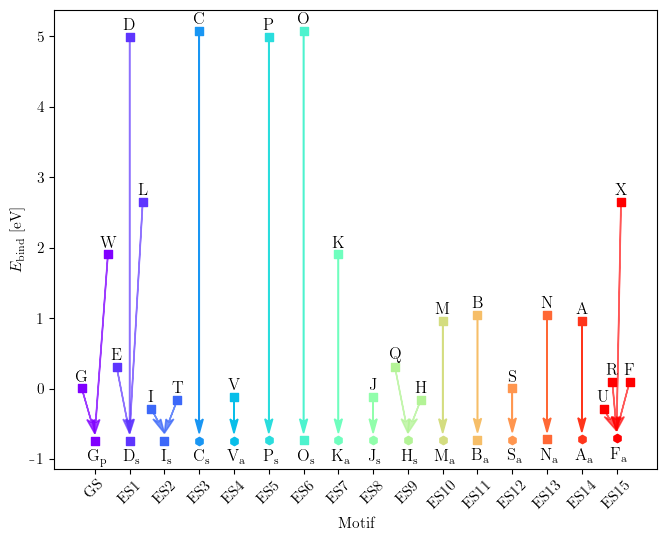

In [8]:

def sort_states(state):
    prefix, number = re.match(r'(\D+)(\d*)', state).groups()
    if prefix == 'GS':
        return (-1, 0)
    else:
        return (0, int(number) if number else 0) 

db_rlxd_slpd = connect('/home/carlfro/Projects/polymers/individual/PVF_vcrelax/ReLabel5.MERGED.db')

rows = db_rlxd_slpd.select()
rows = [row for row in rows]

# Define your custom order
order = ['GS', 'ES1', 'ES2', 'ES3', 'ES4', 'ES5', 'ES6', 'ES7', 'ES8', 'ES9', 'ES10', 'ES11', 'ES12', 'ES13', 'ES14', 'ES15']
# Sort the rows according to the custom order
rows = sorted(rows, key=lambda row: order.index(row.state))


initial_states = []
final_states = []
initial_energies = []
final_energies = []
motifs = []
degeneracies = []
structures = []

unique_states = set()

for i,row in enumerate(rows):
    initial_states.append(row.origin)
    final_states.append(row.state)
    initial_energies.append(row.init_coh_ene*1000)
    final_energies.append(row.rlx_coh_ene*1000)
    motifs.append(row.motif)
    degeneracies.append(row.deg)
    structures.append(re.sub(r'\W+', '', row.structure))
    unique_states.add(row.state)


counts = Counter(final_states)
print(f"Counts are: {counts}\n")
print(f"Final states: {final_states}\n")

sorted_states = sorted(set(final_states), key=sort_states)
unique_states = sorted(set(unique_states), key=sort_states)

state_to_int = {state: i*2 for i, state in enumerate(sorted_states)}

x_positions = []

i = 0
while i < len(final_states):
    state = final_states[i]
    num_points = counts[state]
    base_x = state_to_int[state]
    print(f"For state {state} we have {num_points} points and base_x = {base_x}, i = {i}")
    #state_x_positions = [base_x + (i - num_points / 2) / num_points for i in range(num_points)]
    if num_points == 1:
        state_x_positions = [base_x]
    else:
        state_x_positions = np.linspace(base_x - 0.75, base_x + 0.75, num_points)
    print(state_x_positions)
    x_positions.extend(state_x_positions)
    i += num_points
    print()

print(state_to_int)
print(len(x_positions))
print(x_positions)

colors = {state: color for state, color in zip(unique_states, cm.rainbow(np.linspace(0, 1, len(unique_states))))}
print("Colors are :",colors)

#marker_dict = {'square': 's', 'diamond': 'D', 'triangle': '^'}
marker_dict = {'square': 's', 'diamond': 'h', 'triangle': 'h'}

#setup_matplotlib(width=16+8.0,height=16)
setup_matplotlib(width='full',height=14)
fig, ax = plt.subplots()

# Set slight rotation for x-tick labels
plt.xticks(rotation=45)

final_states_plotted = set()  # Keep track of already plotted final states

for initial_state, final_state, initial_energy, final_energy, structure, motif, x_position in zip(initial_states, final_states, initial_energies, final_energies, structures, motifs, x_positions):
    ax.scatter(x_position, initial_energy, marker='s', color=colors[final_state])
    
    dx = state_to_int[final_state] - x_position
    dy = (final_energy-initial_energy) + 105.0
    if final_state not in final_states_plotted:
        ax.scatter(state_to_int[final_state], final_energy, marker=marker_dict[structure], color=colors[final_state])
        ax.text(state_to_int[final_state]+0.1, final_energy - 295.0, motif, fontsize=12, ha='center')
        final_states_plotted.add(final_state)
    num_points = counts[final_state]
    if num_points > 1:
        alpha = 1 - 0.5*(num_points - 1)/num_points
    else:
        alpha = 1
    arrow = FancyArrow(x_position, initial_energy, dx, dy, 
                    shape='full', lw=1.1, head_width=0.45, overhang=0.2, width=0.01, head_length = 200, length_includes_head=True, color=colors[final_state], alpha=alpha)
    ax.add_patch(arrow)
    ax.text(x_position, initial_energy + 100.0, initial_state, fontsize=12, ha='center')

# Set x-tick labels
ax.set_xticks(list(state_to_int.values()))
ax.set_xticklabels(state_to_int.keys())

#ax.set_ylabel(r"{${\rm E}_{\rm coh}$ [meV]}", labelpad=15)
ax.set_ylabel(r"{$E_{\rm bind}$ [eV]}", labelpad=3)
ax.set_xlabel("Motif")


# Set y-limits 
y_max = max(initial_energies) + 300.0
y_min = min(final_energies) - 390.0
ax.set_ylim(y_min, y_max)

# Set y-tick labels to eV
y_ticks = np.linspace(-1,5,7)
print(y_ticks)
y_labels = [fr"${e:.0f}$" for e in y_ticks]
y_labels[0] = fr"$\shortminus{1:.0f}$"
#y_labels[0] = fr"SMIGGE"
print(y_labels)
ax.set_yticks(y_ticks*1000) # scaling the tick values
ax.set_yticklabels(y_labels)

    

plt.tight_layout()
plt.draw()
plt.show()

fig.savefig(f"fig_relax-chart_COMPLETE.pdf", format="pdf", bbox_inches='tight')

### 4.2 Plot the energy map of the low-lying metastable PVF structures and the energy surface for the groundstate (GS) (E_p/PVF-5 polymorph).
This is Figure 4 in the paper - Relax chart + the energy surface in lattice parameter space $E_{\rm coh} (a,b;c_{\rm opt})$ and the corresponding $E_{\rm coh} (c;a_{\rm opt},b_{\rm opt})$ curve

Helper functions for plotting

In [39]:
# Define a dictionary for color coding different states
relax_chart_colors = {
    'GS': np.array([0.5, 0., 1., 1.]),
    'ES1': np.array([0.3745098, 0.19584547, 0.99514692, 1.]),
    'ES2': np.array([0.24901961, 0.38410575, 0.98063477, 1.]),
    'ES3': np.array([0.12352941, 0.55748944, 0.95660442, 1.]),
    'ES4': np.array([0.00196078, 0.70928131, 0.92328911, 1.]),
    'ES5': np.array([0.12745098, 0.83360239, 0.88101219, 1.]),
    'ES6': np.array([0.25294118, 0.92563766, 0.83018403, 1.]),
    'ES7': np.array([0.37843137, 0.98182256, 0.77129796, 1.]),
    'ES8': np.array([0.50392157, 0.99998103, 0.70492555, 1.]),
    'ES9': np.array([0.62941176, 0.97940977, 0.63171101, 1.]),
    'ES10': np.array([0.75490196, 0.92090552, 0.55236497, 1.]),
    'ES11': np.array([0.88039216, 0.82673417, 0.46765759, 1.]),
    'ES12': np.array([1., 0.70054304, 0.37841105, 1.]),
    'ES13': np.array([1., 0.54721955, 0.28549159, 1.]),
    'ES14': np.array([1., 0.37270199, 0.18980109, 1.]),
    'ES15': np.array([1., 0.18374952, 0.09226836, 1.]),
    'ES16': np.array([1.0000000e+00, 1.2246468e-16, 6.1232340e-17, 1.0000000e+00])
}

relax_chart_colors_array = np.array(list(relax_chart_colors.values()))


def one_var_fit(x, y):
    """
    Fit a model for one variable to fourth order.

    Parameters:
    - x: ndarray
        Independent variable.
    - y: ndarray
        Dependent variable.

    Returns:
    - lmfit.ModelResult
        The result of the fit.
    """
    def fit_form_1var_4order(x, k, a0, m1, gam1, del1):
        """One variable polynomial of degree 4 with coefficients for the polynomial."""
        return k + 1/2 * m1 * (x - a0) ** 2 + 1/6 * gam1 * (x - a0) ** 3 + 1/24 * del1 * (x - a0) ** 4

    pmodel = Model(fit_form_1var_4order)
    index_emin = np.argmin(y)
    emin = y[index_emin]
    amin = x[index_emin]
    yfit = [a - amin for a in y]
    Pa_i = np.polyfit(x, yfit, 4)

    result = pmodel.fit(y, x=x, k=emin, a0=amin, m1=Pa_i[2], gam1=Pa_i[3], del1=Pa_i[4])
    return result

def create_1D_poly_fit(rows):
    """
    Creates a 1D polynomial fit from given rows of atomic structures.

    Parameters:
    rows : list
        List of database rows representing atomic structures.

    Returns:
    tuple
        A tuple containing the polynomial fit object, parameter list, and energy list.
    """
    param_list = [row.toatoms().cell.cellpar()[2] for row in rows]
    e_list = np.array([row.toatoms().get_total_energy() for row in rows])
    e_list -= np.min(e_list)

    oneD_poly = one_var_fit(param_list, e_list)
    return oneD_poly, param_list, e_list

# -------------------

def two_var_fit(x, y):
    """
    Fit a model for two variables to fourth order.

    Parameters:
    - x: ndarray
        Independent variables.
    - y: ndarray
        Dependent variable.

    Returns:
    - lmfit.ModelResult
        The result of the fit.
    """
    def two_var_4order_poly_fit(x, y):
        """Fits a two-variable fourth-order polynomial and returns coefficients."""
        Pa = np.polyfit(x[0], y, 4)
        Pc = np.polyfit(x[1], y, 4)
        return Pa, Pc

    def fit_form_2var_4order(x, k, a0, c0, m11, m22, m12, gam111, gam222, gam112, gam122,
                             del1111, del2222, del1112, del1222, del1122):
        """Two variable polynomial of degree 4 with coefficients for the polynomial."""
        return k + 0.5 * (m11 * (x[0] - a0) ** 2 + m22 * (x[1] - c0) ** 2 + 2 * m12 * (x[0] - a0) * (x[1] - c0)) +\
               1 / 6 * (gam111 * (x[0] - a0) ** 3 + gam222 * (x[1] - c0) ** 3 + 
                        3 * (gam112 * (x[0] - a0) ** 2 * (x[1] - c0) + gam122 * (x[0] - a0) * (x[1] - c0) ** 2)) +\
               1 * (del1111 * (x[0] - a0) ** 4 + del2222 * (x[1] - c0) ** 4 + 
                    del1112 * (x[0] - a0) ** 3 * (x[1] - c0) + del1222 * (x[0] - a0) * (x[1] - c0) ** 3 + 
                    del1122 * (x[0] - a0) ** 2 * (x[1] - c0) ** 2)

    pmodel = Model(fit_form_2var_4order)
    poly_coefficients_a, poly_coefficients_c = two_var_4order_poly_fit(x, y)
    index_emin = np.argmin(y)
    emin = y[index_emin]
    amin = x[0][index_emin]
    cmin = x[1][index_emin]

    result = pmodel.fit(y, x=x, k=emin, a0=amin, c0=cmin, m11=poly_coefficients_a[2], m22=poly_coefficients_c[2],
                        m12=1, gam111=poly_coefficients_a[3], gam222=poly_coefficients_c[3], gam112=1, gam122=1,
                        del1111=poly_coefficients_a[4], del2222=poly_coefficients_c[4], del1112=1, del1122=1, del1222=1)

    return result

def create_2D_poly_fit(rows):
    """
    Creates a 2D polynomial fit from given rows of atomic structures.

    Parameters:
    rows : list
        List of database rows representing atomic structures.

    Returns:
    tuple
        A tuple containing the polynomial fit object, parameter list, and energy list.
    """
    param_list = [[row.toatoms().cell.cellpar()[0] for row in rows],
                  [row.toatoms().cell.cellpar()[1] for row in rows]]
    e_list = np.array([row.toatoms().get_total_energy() for row in rows])
    e_list -= np.min(e_list)

    twoD_poly = two_var_fit(param_list, e_list)
    return twoD_poly, param_list, e_list

# -------------------
    
def plot_oneD_poly(oneD_poly, param_list, e_list, ax=None, rot_ang=0):
    """
    Plots a 1D polynomial fit.

    Parameters:
    oneD_poly : lmfit.ModelResult
        The polynomial fit result to plot.
    param_list : list
        The list of independent variable values.
    e_list : list
        The list of energy values.
    ax : matplotlib.axes.Axes, optional
        The matplotlib axes to plot on. If None, a new figure is created.

    Returns:
    None
    """

    def create_ticks_array(start, end, mid, num_points):
        """Create an array of linearly spaced values between 'start' and 'end', including the midpoint 'mid'."""
        # Create an array from start to mid
        array1 = np.linspace(start, mid, num_points//2 + 1, endpoint=True)

        # Create an array from mid to end
        array2 = np.linspace(mid, end, num_points//2 + 1, endpoint=True)

        # Concatenate the two arrays, excluding the duplicate mid-point from the second array
        final_array = np.concatenate((array1, array2[1:]))

        return final_array


    if ax is None:
        setup_matplotlib()
        fig, ax = plt.subplots(1, 1, sharex=True)

    ax.set_ylabel(r"{$E_{\rm bind}$ [meV]}")
    ax.set_xlabel(r"{c [Å]}")

    # Plot the data and the best fit
    a_grid = np.linspace(param_list[0], param_list[-1], 1000)
    poly_val = oneD_poly.eval(x=a_grid)
    ax.plot(param_list, e_list, 'o', color="blue", label="data")
    ax.plot(a_grid, poly_val, '-', color="blue", label="Best fit")
    max_poly = max(poly_val)
    min_poly = min(poly_val)

    # Axis limits
    # x-axis lim
    extra = (max(a_grid) - min(a_grid)) * 0.05
    ax.set_xlim(min(a_grid) - extra, max(a_grid) + extra)
    # y-axis lim
    extra = (np.abs(max_poly) - np.abs(min_poly))*-0.1
    print(f"extra: {extra}")
    print(f"min: {min(poly_val)}")
    print(f"max: {max(poly_val)}")
    y_min, y_max = min_poly + extra, max_poly - extra * 3
    ax.set_ylim(y_min, y_max)

    # Axis ticks and tick labels
    # x-axis 
    # Set four evenly space ticks between 2.5 and 2.6
    a_min = a_grid[np.argmin(poly_val)]
    ticks = create_ticks_array(min(a_grid), max(a_grid), a_min, 4)
    ax.set_xticks(ticks)
    ax.set_xticklabels([f"${w:.3f}$" for w in ticks], rotation=rot_ang)
    # y-axis 
    locsy = np.linspace(min_poly, max_poly, 7).round(3)
    ax.set_yticks(locsy)
    ax.set_yticklabels([fr"$\shortminus{abs(e)*1000:.0f}$" for e in locsy])

    ax.tick_params(axis='x', length=5, top=True, right=True, direction='in')
    ax.tick_params(axis='y', length=5, top=True, right=True, direction='in')

    if ax is None:
        plt.tight_layout()
        plt.draw()  
        plt.show()

def plot_twoD_poly(twoD_poly, param_list, ax=None, fig=None, rot_ang=0):
    """
    Plots a 2D polynomial fit.

    Parameters:
    twoD_poly : lmfit.ModelResult
        The 2D polynomial fit result to plot.
    param_list : list
        The list of independent variable values in two dimensions.
    ax : matplotlib.axes.Axes, optional
        The matplotlib axes to plot on. If None, a new figure is created.
    fig : matplotlib.figure.Figure, optional
        The matplotlib figure to add the plot to. Required if ax is None.

    Returns:
    matplotlib.figure.Figure
        The figure containing the plot.
    """

    def adjust_axis_labels(ax, param_list, res_poly, rot_ang):
        """
        Adjusts the axis labels for the 2D polynomial fit plot.

        Parameters:
        ax : matplotlib.axes.Axes
            The axes to adjust labels on.
        param_list : list
            The list of independent variable values in two dimensions.
        res_poly : list
            The list containing the optimal a and b parameters.
        rot_ang : int
            The rotation angle for the x-axis labels.

        Returns:
        None
        """
        def create_array_linspace(start, end, mid):
            """
            Creates an array of linearly spaced values with increased density around 'mid'.

            Parameters:
            start : float
                The starting value of the array.
            end : float
                The ending value of the array.
            mid : float
                The midpoint around which density is increased.

            Returns:
            ndarray
                The resulting array.
            """
            num_points_before = int(np.round((mid - start) / 0.05))
            num_points_after = int(np.round((end - mid) / 0.05))

            array1 = mid - np.arange(num_points_before, 0, -1) * 0.05
            array2 = mid + np.arange(1, num_points_after + 1) * 0.05
            final_array = np.concatenate((array1[::-1], [mid], array2))

            if len(final_array) > 8:
                final_array = np.append(final_array[::2], mid) if mid not in final_array[::2] else final_array[::2]
                final_array = np.sort(final_array)

            return final_array

    # y-axis
    y_min, y_max = ax.get_ylim()
    y_locs = create_array_linspace(round_up(y_min,0.05), round_up(y_max,0.05), res_poly[1]).round(3)
    ax.set_yticks(y_locs)
    ax.set_yticklabels(y_locs)
    ax.set_ylim(y_min, y_max)

    # x-axis
    x_min, x_max = ax.get_xlim()
    x_locs = create_array_linspace(round_up(x_min,0.05), round_up(x_max,0.05), res_poly[0]).round(3)
    ax.set_xticks(x_locs)
    ax.set_xticklabels(x_locs, rotation=rot_ang)
    ax.set_xlim(x_min, x_max)

    def eV_fmt(x, pos):
        """
        Formats energy values for plotting.

        Parameters:
        x : float
            The energy value to format.
        pos : int
            The position (unused).

        Returns:
        str
            The formatted energy value.
        """
        return f"{x*1000:.0f}"

    def add_labels_twoD_energy(fig, ax, contour):
        """
        Adds labels and colorbar to the 2D energy plot.

        Parameters:
        fig : matplotlib.figure.Figure
            The figure to add the colorbar to.
        ax : matplotlib.axes.Axes
            The axes the contour plot is drawn on.
        contour : matplotlib.contour.QuadContourSet
            The contour set to base the colorbar on.

        Returns:
        None
        """
        cbar = fig.colorbar(contour, ax=ax, format=ticker.FuncFormatter(eV_fmt))
        ax.set_xlabel(r"a [Å]")
        ax.set_ylabel(r"b [Å]")
        cbar.set_label(r"${\Delta} E_{\rm bind}({\rm a},{\rm b};{\rm c}_0)$ [meV]")

    # Plotting setup
    norm = PowerNorm(0.8)  # Adjust normalization as needed
    levels = 18

    if ax is None:
        setup_matplotlib()
        fig, ax = plt.subplots()

    # Contour plots for the polynomial evaluation
    ax.tricontour(param_list[0], param_list[1], twoD_poly.eval(x=[param_list[0],param_list[1]]), levels=levels, 
                  linewidths=0.5, colors='k')

    contour = ax.tricontourf(param_list[0], param_list[1], twoD_poly.eval(x=[param_list[0], param_list[1]]),
                             levels=levels, cmap='viridis', norm=norm)

    # Scatter plot for the data points
    pts = ax.scatter(param_list[0], param_list[1], color=[0.0,0.0,0.0,1], s=10*factor*0.5)

    # Highlighting the minimum energy location
    res_poly = [twoD_poly.params['a0'].value, twoD_poly.params['c0'].value]
    ax.scatter(res_poly[0], res_poly[1], c="tab:red", marker="*", s=100, label="Minimum Energy Location")
    #print(f"a_0 = {res_poly[0]:.3f}, b_0 = {res_poly[1]:.3f}")

    # Adding labels and adjustments
    add_labels_twoD_energy(fig, ax, contour)
    ax.tick_params(axis='x', length=5, top=True, right=True, direction='in')
    ax.tick_params(axis='y', length=5, top=True, right=True, direction='in')

    # Axis labels adjustments for better readability
    adjust_axis_labels(ax, param_list, res_poly, rot_ang)

    return fig


def plot_relaxmap(database, num_structures, output_name, ax=None, fig=None):
    """
    Plots the relaxation map of selected structures from the database, sorted by their energy.

    Parameters:
    - database: The database object containing structure information.
    - num_structures: Integer, the number of structures to select and plot.
    - output_name: String, the filename where the plot will be saved.
    - ax: Matplotlib Axes object (optional), where the plot will be drawn.
    - fig: Matplotlib Figure object (optional), associated with ax.
    """

    def determine_marker_and_size(structure, label):
        """
        Determines the marker style and size based on atomic structure and label.

        Parameters:
        - atoms: ASE Atoms object, representing the atomic structure.
        - label: String, label of the structure.

        Returns:
        - marker: String, matplotlib marker style.
        - ms: Integer, marker size.
        """
        # This function should contain logic to determine marker and size
        # based on atoms and label. Placeholder logic below:
        marker = 'o'  # Placeholder marker
        ms = 11  # Placeholder marker size
        if structure == "$\square$":
            if label == 's': # Check if atoms are shifted
                marker = 's'
            else:
                marker = 's'
        elif structure == "$\\triangle$":
            if label == 's': # Check if atoms are shifted
                marker = '^'
            else:
                marker = '^'
        else: # Atoms are monoclinic
            if label == 's': # Check if atoms are shifted
                marker = 'H'
            else:
                marker = 'h'
        return marker, ms

    def adjust_energy_axis(ax, result_dict):
        """
        Adjusts the y-axis of the plot based on the energy range of the structures.

        Parameters:
        - ax: Matplotlib Axes object, where the plot will be drawn.
        - result_dict: Dictionary, containing energy information of structures.

        Returns:
        - e_min: Float, minimum energy value.
        - e_max: Float, maximum energy value.
        """
        #energies = [1000 * result_dict[res]['energy'] for res in result_dict]
        energies = [result_dict[res]['energy'] for res in result_dict]
        e_min, e_max = min(energies), max(energies)
        #ax.set_ylim(e_min - 5, e_max + 5)
        ax.set_ylim(-0.75*1000, -0.715*1000)
        ticks = np.linspace(e_min, e_max, 4).round(3)
        labels = [fr"$\shortminus{abs(e*1000):.0f}$" for e in ticks]
        ax.set_yticks(ticks*1000) # scaling the tick values
        ax.set_yticklabels(labels)

        return e_min, e_max

    # Hard coded labels
    labels = ["GS", "ES1 ", "ES2$^*$", "C$_{\\rm s}$", "V$_{\\rm a}$$^*$", "P$_{\\rm s}$$^*$", "O$_{\\rm s}$$^*$", 
            "K$_{\\rm a}$$^*$", "J$_{\\rm s}$$^*$", "H$_{\\rm s}$$^*$", "M$_{\\rm a}$$^*$", "B$_{\\rm a}$$^*$", "S$_{\\rm a}$$^*$", "N$_{\\rm a}$$^*$", 
            "A$_{\\rm a}$$^*$", "F$_{\\rm a}$$^*$" ]

    # Retrieve dictionary of label and energy for all selected rows
    result_dict = select_structures_rlxmp(database, num_structures)

    #structures = list(result_dict.keys())
    # Manual ordering
    structures = ['G$_{\\rm p}$', 'D$_{\\rm s}$', 'I$_{\\rm s}$$^*$', 'C$_{\\rm s}$', 'V$_{\\rm a}$$^*$', 
                  'P$_{\\rm s}$$^*$', 'O$_{\\rm s}$$^*$', 'K$_{\\rm a}$$^*$']

    print(f"structures are labelled as: {structures}")

    labels = labels[:len(structures)]

    # Print the selected structures for confirmation
    print(f"Structures are labelled as: {structures}")

    # Plot initialization
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        fig.add_subplot(111, frameon=False)
        setup_matplotlib(width=16+1.0,height=5)
        plt.ylabel(r"{$E_{\rm bind}=-2E_{\rm coh}$ [meV]}", labelpad=5, fontsize=14)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    else:
        ax.set_ylabel(r"{$E_{\rm bind}=-2E_{\rm coh}$ [meV]}", labelpad=5)

    # Plot relax map
    ax.set_xlabel(r"Motif")
    
    # Initialize lists for plotting
    locs = []
    
    # Determine positions for plotting
    pos        = np.arange(0, 3 * 1.5, 1.5)
    char_start = pos[-1] + 1.5
    pos        = np.concatenate((pos, np.arange(char_start, len(structures) * 1.25 + char_start, 1.25)))
    
    for i, cur_res in enumerate(structures):
        col = relax_chart_colors_array[i]  # Get color associated with this structure

        locs.append(pos[i])

        marker, ms = determine_marker_and_size(result_dict[cur_res]['structure'], result_dict[cur_res]['label'])

        ax.plot(pos[i], 1000 * result_dict[cur_res]['energy'], ms=ms, marker=marker, color=col)

    ax.set_xticks(locs)
    ax.set_xticklabels(labels, va='bottom')
    ax.xaxis.set_tick_params(pad=20)
    ax.tick_params(axis='x', length=5, top=True, right=True, direction='in')
    ax.tick_params(axis='y', length=5, top=True, right=True, direction='in')

    # Adjust y-axis limit based on the energy range
    e_min, e_max = adjust_energy_axis(ax, result_dict)

    plt.tight_layout()
    plt.draw()
    plt.show()

    if fig is not None:
        fig.savefig(output_name, format="pdf", bbox_inches='tight')
        print(f"Plot saved to file: {output_name}")

Make the plot corresponding to figure 4 in the paper.

Selected labels: ['E_p', 'E_s', 'I_s', 'C_s']

extra: -0.003975956108394257
min: -0.0001621031035932452
max: 0.039921664187535816


structures are labelled as: ['G$_{\\rm p}$', 'D$_{\\rm s}$', 'I$_{\\rm s}$$^*$', 'C$_{\\rm s}$', 'V$_{\\rm a}$$^*$', 'P$_{\\rm s}$$^*$', 'O$_{\\rm s}$$^*$', 'K$_{\\rm a}$$^*$']
Structures are labelled as: ['G$_{\\rm p}$', 'D$_{\\rm s}$', 'I$_{\\rm s}$$^*$', 'C$_{\\rm s}$', 'V$_{\\rm a}$$^*$', 'P$_{\\rm s}$$^*$', 'O$_{\\rm s}$$^*$', 'K$_{\\rm a}$$^*$']


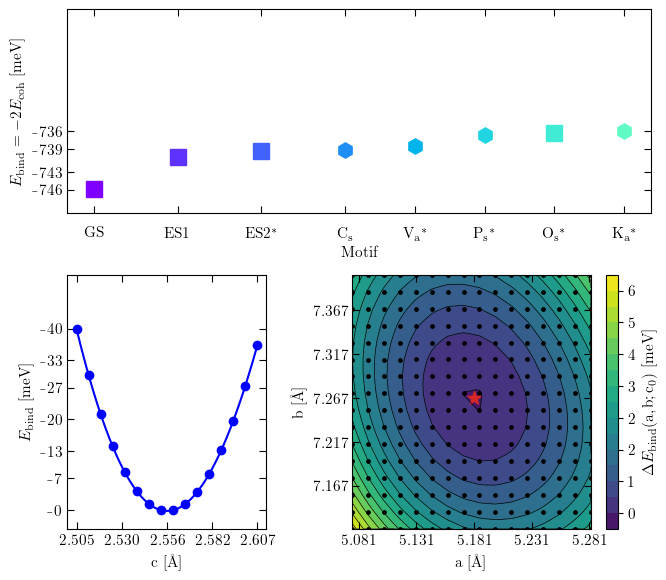

Plot saved to file: relaxmap.pdf


<Figure size 677.165x590.551 with 0 Axes>

In [40]:

factor = 8/6.8
# Create a figure
setup_matplotlib(width='full',height=15)
fig = plt.figure()

# Define the grid
gs = GridSpec(nrows=2, ncols=2, figure=fig, height_ratios=[4, 5], width_ratios=[2, 3])

# Make a relax map of the lowest energy structureS and energy map plot THE lowest energy structure
# Set database
database_Emap = connect('structures.Low4.E-map.run1.db')

# Selects the 3 lowest energy structures and create a list of lists of the rows for the energy mapping results
# That is rows_list = [[rows1],[rows2],[rows3]] where rows1 = [ab_rows1,c_rows1] 
rows_list = select_structures(database_Emap, 1)
# 
for i in range(len(rows_list)):
    ab_rows = rows_list[i][0]
    c_rows  = rows_list[i][1]

    print()
    ax3 = fig.add_subplot(gs[1, 1])
    # Create E(a,b;c_0) plot 
    twoD_poly, param_list, e_list = create_2D_poly_fit(ab_rows)
    plot_twoD_poly(twoD_poly, param_list, ax3, fig)

    # Second row takes two plots
    ax2 = fig.add_subplot(gs[1, 0])
    # Create E(c;a_0,b_0) plot
    oneD_poly, param_list, e_list = create_1D_poly_fit(c_rows)
    plot_oneD_poly(oneD_poly, param_list, e_list,ax2)


print()
# Set database
#database = connect('TESTING.db')
database = connect('ReLabel5.MERGED.unique.db')

# First row takes one plot
ax1 = fig.add_subplot(gs[0, :],frameon=True)
#ax1.set_title('First Row - Single Plot')
# Selects the 3 lowest energy structures and create a list of lists of the rows for the energy mapping results

print()
rows_list = plot_relaxmap(database, 9, 'relaxmap.pdf',ax1,fig) 

# Adjust the width and position of the first plot
pos1 = ax1.get_position() # get the original position 
pos2 = Bbox([[pos1.x0, pos1.y0], [pos1.x0 + pos1.width * 0.945, pos1.y1]])
#print(f"pos2 = {pos2}")
ax1.set_position(pos2) # set a new position

#plt.tight_layout()
plt.draw()
plt.show()
fig.savefig(f"fig4_pythonista.V4.pdf", format="pdf", bbox_inches='tight')



### 4.3 Similar to 4.2 but now we generate the energy surface in lattice parameter space for the metastable structures.
This is Figure S.1 in the SI.

Plot the energy surface for the two lowest lying structures in the database,
used as figure XYZ in the Supplementary Information.

Selected labels: ['E_p', 'E_s', 'I_s', 'C_s']

Current label: E_s
0.8333333333333334
extra: -0.0039776192880687745
min: -0.0001614942887786869
max: 0.03993768716946643
Current label: I_s
0.6666666666666667
extra: -0.003975060279666737
min: -0.00016331781546397112
max: 0.03991392061213134


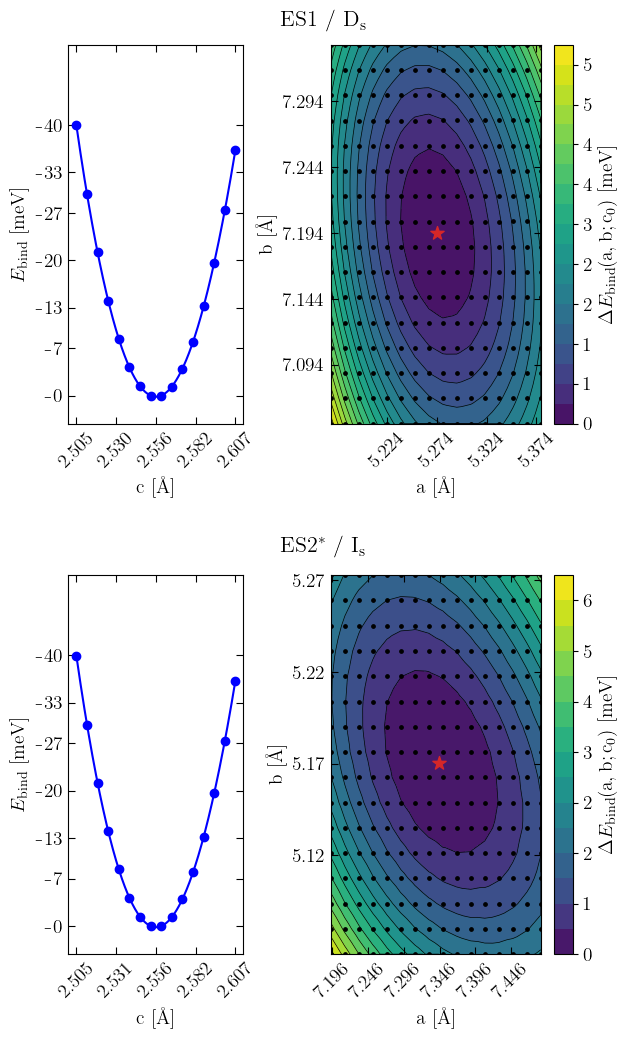

In [41]:
factor = 8/6.8
# Make a relax map of the lowest energy structureS and energy map plot THE lowest energy structure
# Set database
database_Emap = connect('structures.Low4.E-map.run1.db')

# Selects the 3 lowest energy structures and create a list of lists of the rows for the energy mapping results
# That is rows_list = [[rows1],[rows2],[rows3]] where rows1 = [ab_rows1,c_rows1] 
rows_list = select_structures(database_Emap, 5)
rows_list = rows_list[1:]

# Create a figure
setup_matplotlib(width='full', height=15*2, scale=1.3)
fig = plt.figure()

# Define the grid
gs = GridSpec(nrows=2, ncols=2, figure=fig, width_ratios=[2, 3], hspace=0.4, wspace=0.4)

manual_labels = [r"ES1$_{\rm s}$",r"ES2$_{\rm s}^{\uparrow}$",r"C$_{\rm s}$"]

y_locs = [0.9,0.455,0.335]
title_list = [r'ES1 / D$_{\rm s}$',r'ES2$^*$ / I$_{\rm s}$',r'ES3 / C$_{\rm s}$']
print()
for i in range(len(rows_list[:2])):
    ab_rows = rows_list[i][0]
    c_rows  = rows_list[i][1]
    print(f"Current label: {ab_rows[0].label}")

    ax3 = fig.add_subplot(gs[i, 1])
    #fig.text(0.5, 1 - 0.5*(i+1)/len(rows_list), f"Title for Row {i+1}", ha='center', va='center', fontsize=16)
    fig.text(0.5, y_locs[i], title_list[i], ha='center', va='center', fontsize=16)
    print(1-0.5*(i+1)/len(rows_list))
    # Create E(a,b;c_0) plot 
    twoD_poly, param_list, e_list = create_2D_poly_fit(ab_rows)
    plot_twoD_poly(twoD_poly, param_list, ax3, fig, 45)

    ax2 = fig.add_subplot(gs[i, 0])
    # Create E(c;a_0,b_0) plot
    oneD_poly, param_list, e_list = create_1D_poly_fit(c_rows)
    plot_oneD_poly(oneD_poly, param_list, e_list,ax2, 45)


#plt.tight_layout()
plt.draw()
plt.show()
fig.savefig(f"Emap_low2.png", format="png", bbox_inches='tight')

Plot the energy surface for the lowest three energy structures in the database.
*Not used in the paper*

Selected labels: ['E_p', 'E_s', 'I_s', 'C_s']

Current label: E_s
0.8333333333333334
extra: -0.0039776192880687745
min: -0.0001614942887786869
max: 0.03993768716946643
Current label: I_s
0.6666666666666667
extra: -0.003975060279666737
min: -0.00016331781546397112
max: 0.03991392061213134
Current label: C_s
0.5
extra: -0.0039756173448934435
min: -0.00015996650609342907
max: 0.03991613995502786


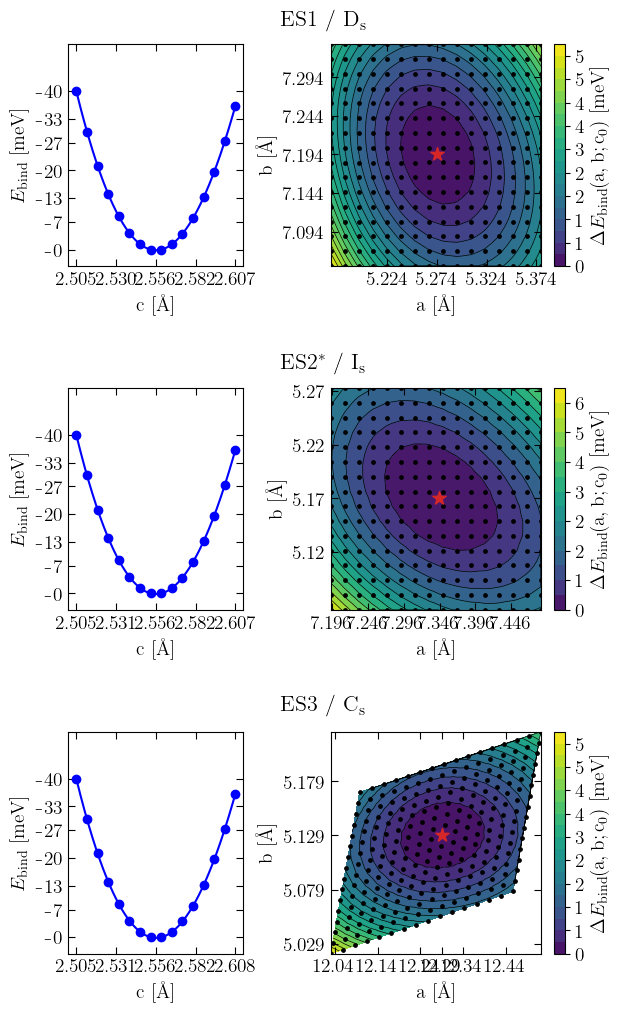

In [42]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

factor = 8/6.8
# Make a relax map of the lowest energy structureS and energy map plot THE lowest energy structure
# Set database
database_Emap = connect('structures.Low4.E-map.run1.db')

# Selects the 3 lowest energy structures and create a list of lists of the rows for the energy mapping results
# That is rows_list = [[rows1],[rows2],[rows3]] where rows1 = [ab_rows1,c_rows1] 
rows_list = select_structures(database_Emap, 5)
rows_list = rows_list[1:]

# Create a figure
setup_matplotlib(width='full', height=15*2, scale=1.3)
fig = plt.figure()

# Define the grid
gs = GridSpec(nrows=3, ncols=2, figure=fig, width_ratios=[2, 3], hspace=0.55, wspace=0.4)

manual_labels = [r"ES1$_{\rm s}$",r"ES2$_{\rm s}^{\uparrow}$",r"C$_{\rm s}$"]

y_locs = [0.9,0.61,0.32]
title_list = [r'ES1 / D$_{\rm s}$',r'ES2$^*$ / I$_{\rm s}$',r'ES3 / C$_{\rm s}$']
print()
for i in range(len(rows_list)):
    ab_rows = rows_list[i][0]
    c_rows  = rows_list[i][1]
    print(f"Current label: {ab_rows[0].label}")

    ax3 = fig.add_subplot(gs[i, 1])
    #fig.text(0.5, 1 - 0.5*(i+1)/len(rows_list), f"Title for Row {i+1}", ha='center', va='center', fontsize=16)
    fig.text(0.5, y_locs[i], title_list[i], ha='center', va='center', fontsize=16)
    print(1-0.5*(i+1)/len(rows_list))
    # Create E(a,b;c_0) plot 
    twoD_poly, param_list, e_list = create_2D_poly_fit(ab_rows)
    plot_twoD_poly(twoD_poly, param_list, ax3, fig)

    ax2 = fig.add_subplot(gs[i, 0])
    # Create E(c;a_0,b_0) plot
    oneD_poly, param_list, e_list = create_1D_poly_fit(c_rows)
    plot_oneD_poly(oneD_poly, param_list, e_list,ax2)

#plt.tight_layout()
plt.draw()
plt.show()
fig.savefig(f"Emap_low3.png", format="png", bbox_inches='tight')

### 4.4 Compute the Elastic Constants from the Deformed Structures 


In [51]:
# Helper functions 

def SOEC_fit(x, E0, alpha, beta,gamma):
     return E0 + alpha*x**2 + beta*x**3 + gamma*x**1

def SOEC_solver(i,alpha,C,V0):
    """Returns the second order elastic constant c_i of deformation D_i,
    given the fitting parameters of a third order polynomial.

    :i: Type of deformations as given by the deformation matrix D_i.
    :alphas: The fitting parameters of third order poly.
    :returns: Elastic constant c_i.

    """
    if i in [1,2,3,4,5,6]:  # adding 4,5,6 here
        c=2*alpha/V0*AU_TO_GPa
    elif i==7:
        c11 = C[0]
        c22 = C[1]
        c   = 0.5*(c11+c22) - alpha/V0*AU_TO_GPa
    elif i==8:
        c11 = C[0]
        c33 = C[2]
        c   = 0.5*(c11+c33) - alpha/V0*AU_TO_GPa
    elif i==9:
        c22 = C[1]
        c33 = C[2]
        c   = 0.5*(c22+c33) - alpha/V0*AU_TO_GPa
    return c

Compute the elastic constants for the structures in the database, and plot the energy vs deformation curves.

Current structure: PVF-11


E$_{\rm p}$ (PVF-11-orig)
C1 = 14.70 (c11)
C2 = 19.25 (c22)
C3 = 318.89 (c33)
C7 = 3.75 (c12)
C8 = 0.16 (c13)
C9 = 0.91 (c23)
C4 = 7.67 (c44)
C5 = 27.66 (c55)
C6 = 20.18 (c66)
Born 2 	 268.95
Born 3 	 85754.15
Bulk modulus = 8.17

Current structure: PVF-5
E$_{\rm s}$ (PVF-5-orig)
C1 = 20.87 (c11)
C2 = 12.75 (c22)
C3 = 316.64 (c33)
C7 = 4.07 (c12)
C8 = 0.04 (c13)
C9 = 0.27 (c23)
C4 = 24.12 (c44)
C5 = 4.80 (c55)
C6 = 22.62 (c66)
Born 2 	 249.56
Born 3 	 79018.17
Bulk modulus = 11.60

Current structure: PVF-9
I$_{\rm s}$ (PVF-9-orig)
C1 = 13.43 (c11)
C2 = 16.10 (c22)
C3 = 316.20 (c33)
C7 = 5.77 (c12)
C8 = 0.05 (c13)
C9 = 1.19 (c23)
C4 = 9.14 (c44)
C5 = 29.33 (c55)
C6 = 19.92 (c66)
Born 2 	 182.83
Born 3 	 57790.84
Bulk modulus = 7.46

Current structure: PVF-3
C$_{\rm s}$ (PVF-3-orig)
C1 = 12.41 (c11)
C2 = 14.52 (c22)
C3 = 318.65 (c33)
C7 = 5.72 (c12)
C8 = -0.12 (c13)
C9 = 1.60 (c23)
C4 = 3.32 (c44)
C5 = 4.12 (c55)
C6 = 27.48 (c66)
Born 2 	 147.41
Born 3 	 46937.42
Bulk modulus = 6.89



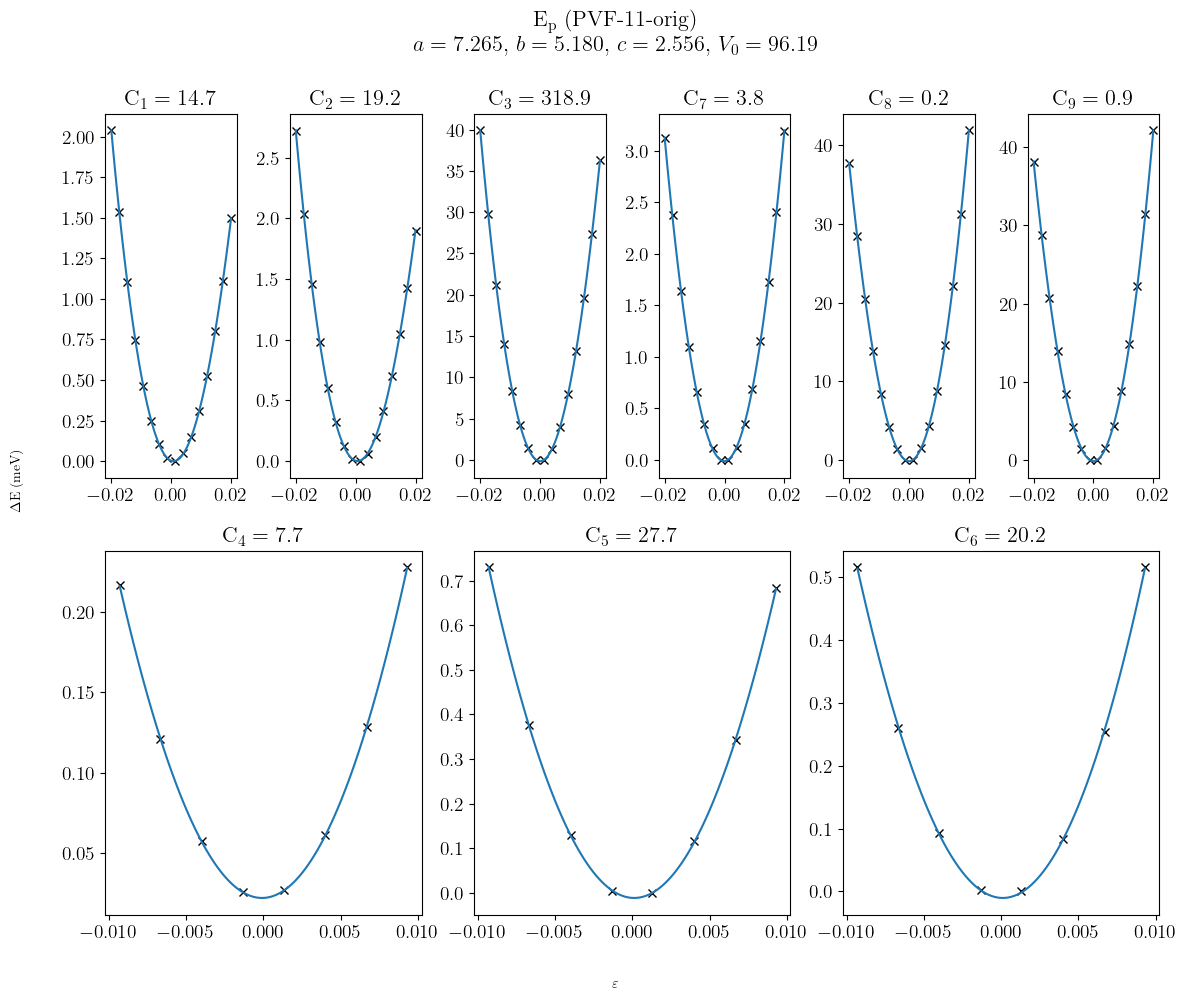

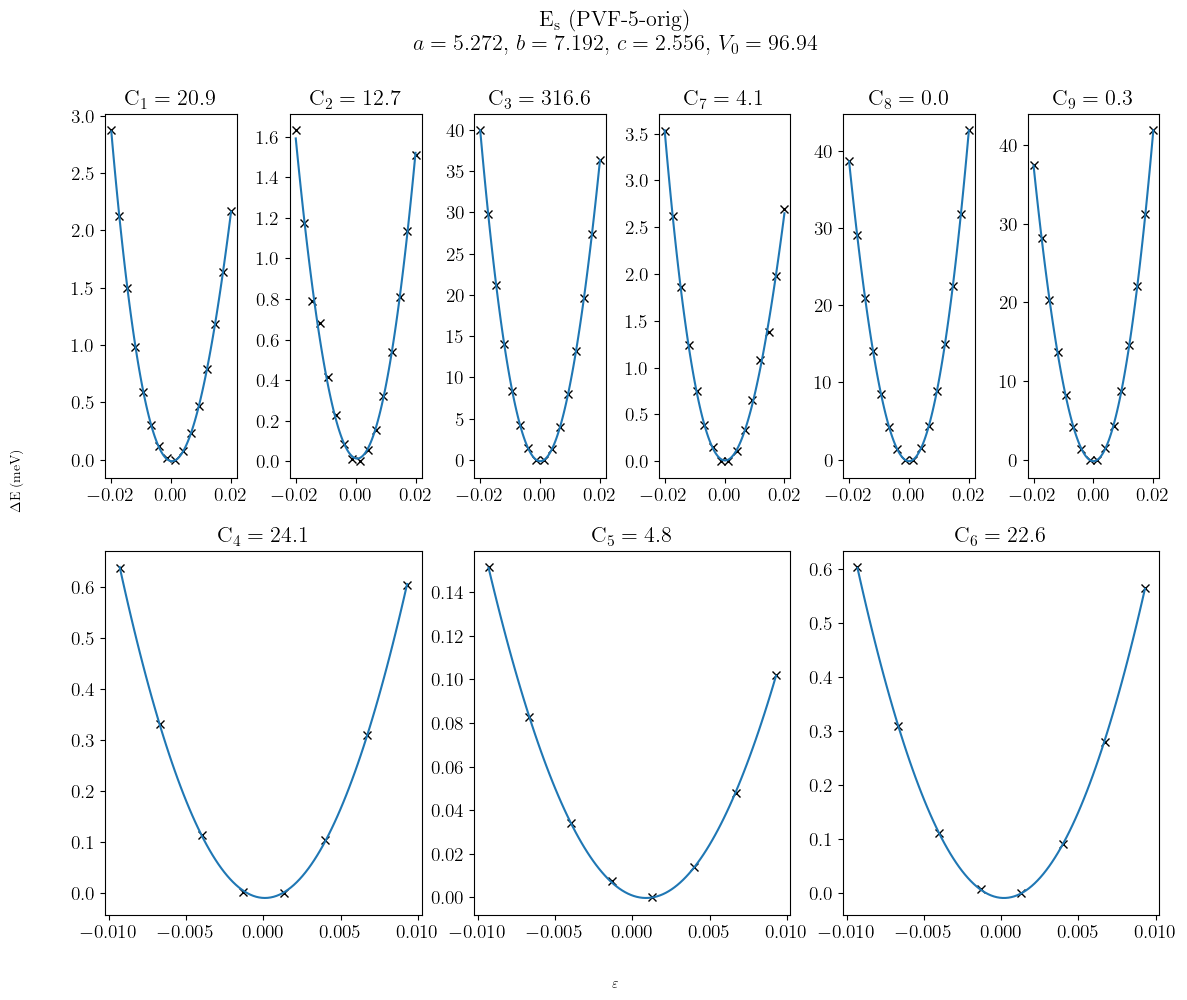

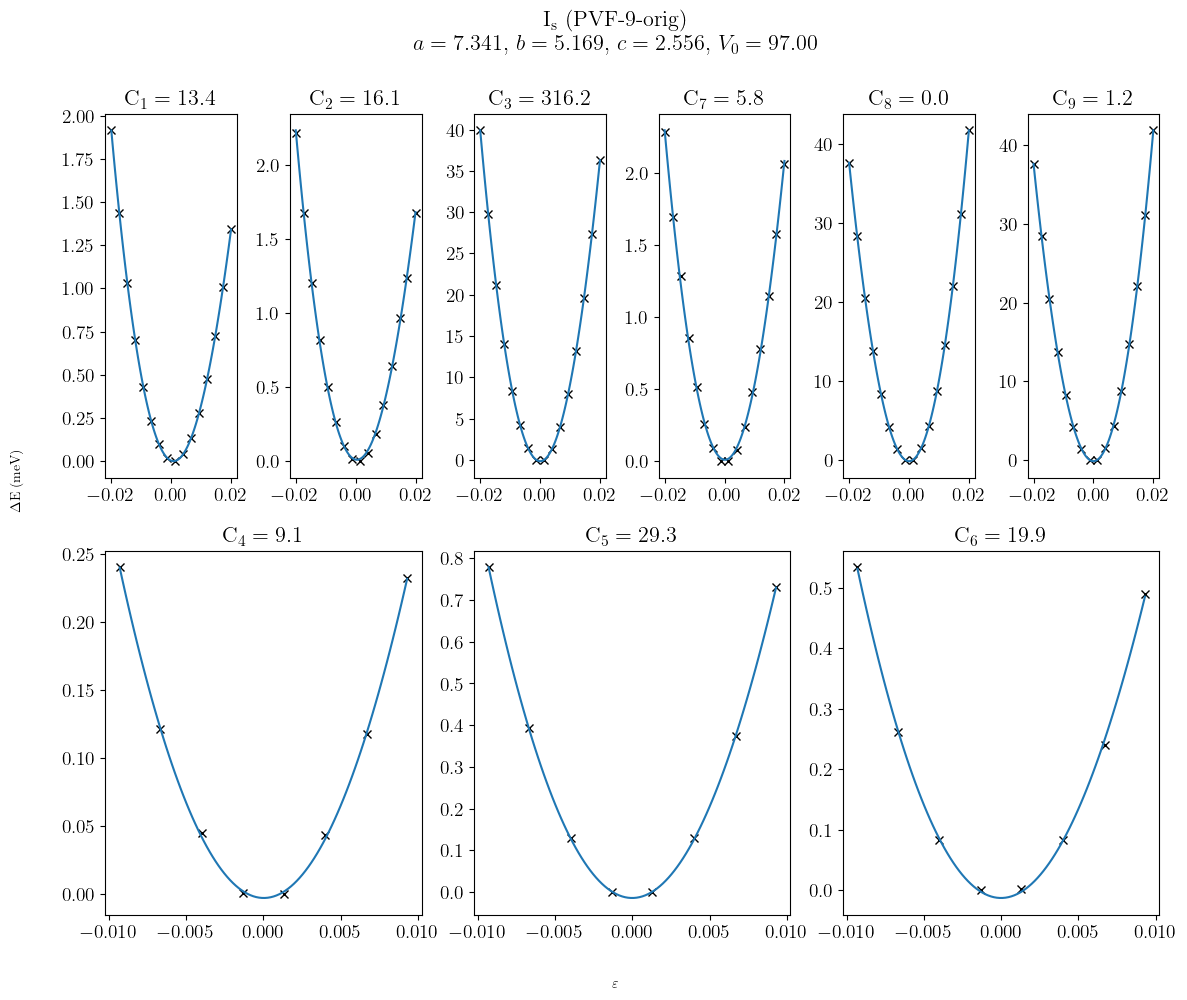

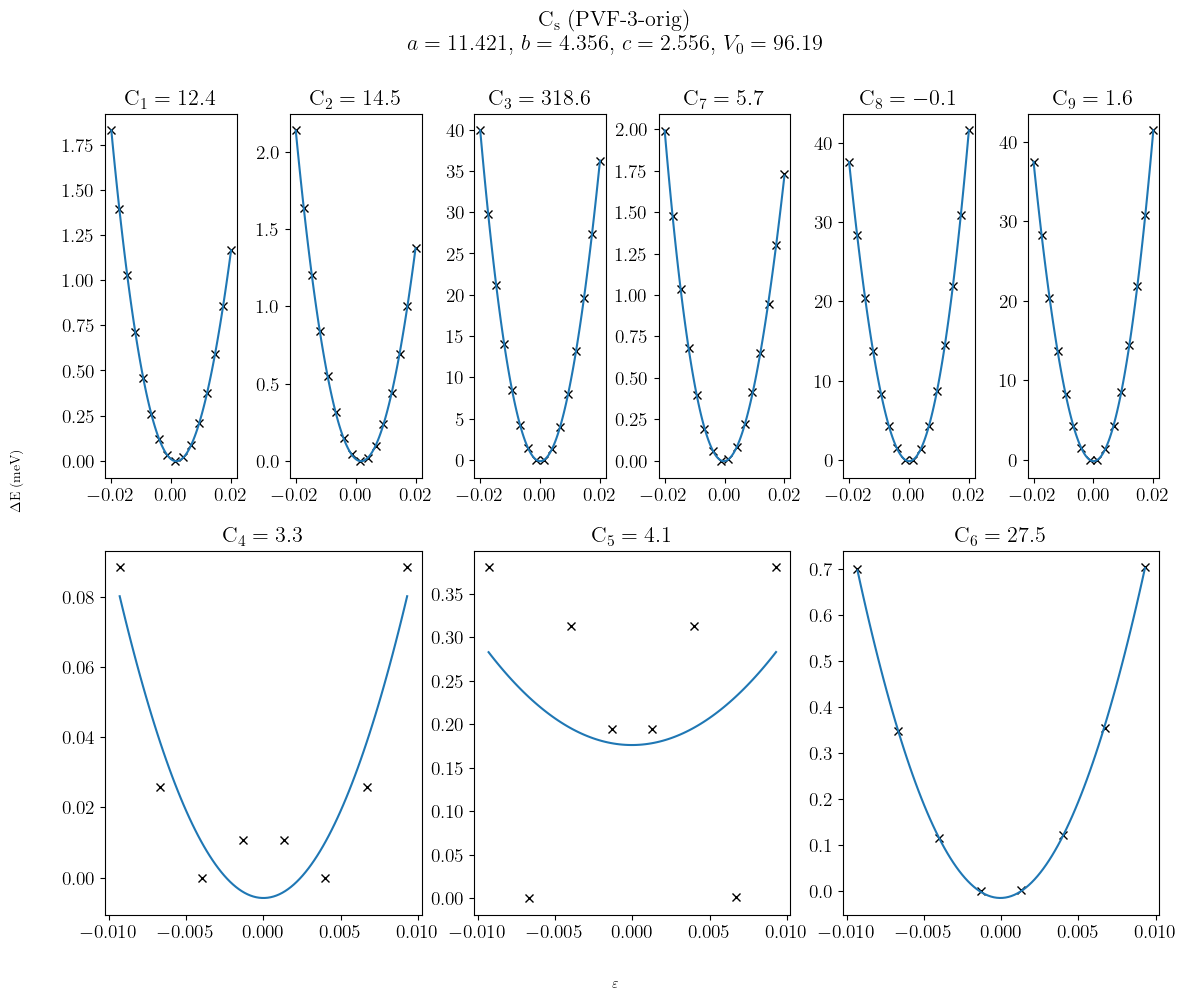

In [64]:
# Define the name for the output plot
plot_name = 'Elastic-constants-plot.png'

# Set the dimensions for the figure
fig_width = 13.6  # 6.8 * 2
fig_height = 10.4  # 8 + 2.4

# Map structure labels to motifs
label_to_motif = {
    'PVF-11': 'E$_{\\rm p}$',
    'PVF-5': 'E$_{\\rm s}$',
    'PVF-9': 'I$_{\\rm s}$',
    'PVF-3': 'C$_{\\rm s}$'
}

# Connect to existing ASE databases for deformed and relaxed structures
db_deformed = connect('strcts_OLD.ES0-3.elast.run3.db')
db_relaxed = connect('relaxed_structures.analysis.db')

# Select the 5 lowest energy structures, excluding the third lowest
rows = sorted(db_relaxed.select(), key=lambda row: row.energy)[:5]
rows = rows[:2] + rows[3:]

for row in rows:
    atoms = row.toatoms()
    print(f"Current structure: {row.motif}")

    # Extract relaxed/equilibrium structure parameters
    a = atoms.get_cell()[0, 0]
    b = atoms.get_cell()[1, 1]
    c = atoms.get_cell()[2, 2]
    V0 = atoms.get_volume()

    # Prepare figure and gridspec for plots
    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.2, wspace=0.4)
    axes = [[fig.add_subplot(gs[i, j]) if i == 0 else fig.add_subplot(gs[i, j*2:j*2+2]) for j in range(6 if i == 0 else 3)] for i in range(2)]

    # Elastic constant vector initialization
    C = 9 * [0]

    for i in range(1,10):  # Loop through deformation types
        eps_rows = sorted(
            db_deformed.select(f"D=D{int(i)},motif={row.motif}"),
            key=lambda row: float(row.eps.strip('eps_'))
        )
        eps_vec = np.array([float(row.eps.strip('eps_')) for row in eps_rows])
        N = len(eps_rows)
        E = np.array([row.toatoms().get_total_energy() for row in eps_rows])
        E = E - min(E)

        # Cut the eps to +- 0.01
        if i in [4, 5, 6]:
            mask = (eps_vec >= -0.01) & (eps_vec <= 0.01)
            eps_vec, E = eps_vec[mask], E[mask]

        plot_vec = np.linspace(min(eps_vec), max(eps_vec), 100)
        #fit_params, _ = curve_fit(SOEC_fit, eps_vec, E * 1000)  # Fit in meV
        fit_params, _ = curve_fit(SOEC_fit, eps_vec, E)
        C[i - 1] = SOEC_solver(i, fit_params[1], C, V0)

        # Plotting
        # Plot in meV
        E = E*1000
        fit_params, fit_cov = curve_fit(SOEC_fit, eps_vec, E)
        if i in [1,2,3]:
            axes[0][i-1].plot(eps_vec,E,'kx',label="Data")
            axes[0][i-1].plot(plot_vec,SOEC_fit(plot_vec,*fit_params),'tab:blue',label="Fit")
        elif i in [4,5,6]:  # Add new plots for C_4, C_5, C_6
            axes[1][i-4].plot(eps_vec,E,'kx',label="Data")
            axes[1][i-4].plot(plot_vec,SOEC_fit(plot_vec,*fit_params),'tab:blue',label="Fit")
        elif i in [7,8,9]:
            axes[0][i-4].plot(eps_vec,E,'kx')
            axes[0][i-4].plot(plot_vec,SOEC_fit(plot_vec,*fit_params),'tab:blue')
        else: 
            print("Something went wrong")

    # Set titles and labels
    for i, ax in enumerate(axes[0], 1):
        if i >= 4:
            i += 3
        ax.set_title(rf"C$_{{{i}}} = {C[i-1]:.1f}$")
    for i, ax in enumerate(axes[1], 4):
        ax.set_title(rf"C$_{{{i}}} = {C[i-1]:.1f}$")

    # Global figure settings
    fig.suptitle(f"{label_to_motif[row.motif]} ({row.motif}-orig) \n $a={a:.3f}$, $b={b:.3f}$, $c={c:.3f}$, $V_0={V0:.2f}$", fontsize=16)
    fig.text(0.5, 0.04, '$\\varepsilon$', ha='center')
    fig.text(0.06, 0.5, '$\Delta$E (meV)', ha='center', rotation='vertical')

    # Save and show the figure
    #plt.tight_layout()
    fig.savefig(plot_name, format='png', dpi=600, bbox_inches='tight', pad_inches=0)
    plt.draw()

    # print the elastic constants to terminal
    print(f"{label_to_motif[row.motif]} ({row.motif}-orig)")
    print(f"C1 = {C[1-1]:.2f} (c11)")
    print(f"C2 = {C[2-1]:.2f} (c22)")
    print(f"C3 = {C[3-1]:.2f} (c33)")
    print(f"C7 = {C[7-1]:.2f} (c12)")
    print(f"C8 = {C[8-1]:.2f} (c13)")
    print(f"C9 = {C[9-1]:.2f} (c23)")
    print(f"C4 = {C[4-1]:.2f} (c44)")
    print(f"C5 = {C[5-1]:.2f} (c55)")
    print(f"C6 = {C[6-1]:.2f} (c66)")

    print(f"Born 2 \t {C[1-1]*C[2-1] - C[7-1]**2:.2f}")
    print(f"Born 3 \t {C[1-1]*C[2-1]*C[3-1] + 2*C[7-1]*C[8-1]*C[9-1] - C[1-1]*C[9-1]**2 - C[2-1]*C[8-1]**2 - C[3-1]*C[7-1]**2:.2f}")

    print(f"Bulk modulus = {5/9*C[0]:.2f}")
    print()

### 4.5 Polarization Characterization

Compute the spontaneous polarization for the structures in the database:
* Plot the polarization lattice i.e. Berry phase (BP) results along the rotation (deformation path).
* Map the results to the branch around the origin.
* Compute the spontaneous polarization as the difference in BP between the original and fully rotated structure 
  along the branch around the origin.


['E_p', 'E_s', 'I_s', 'C_s', 'B_s'] {'E_p': 'PVF-5-new', 'E_s': 'PVF-5-orig', 'I_s': 'PVF-9-orig', 'C_s': 'PVF-3-orig', 'B_s': 'PVF-2-new'}


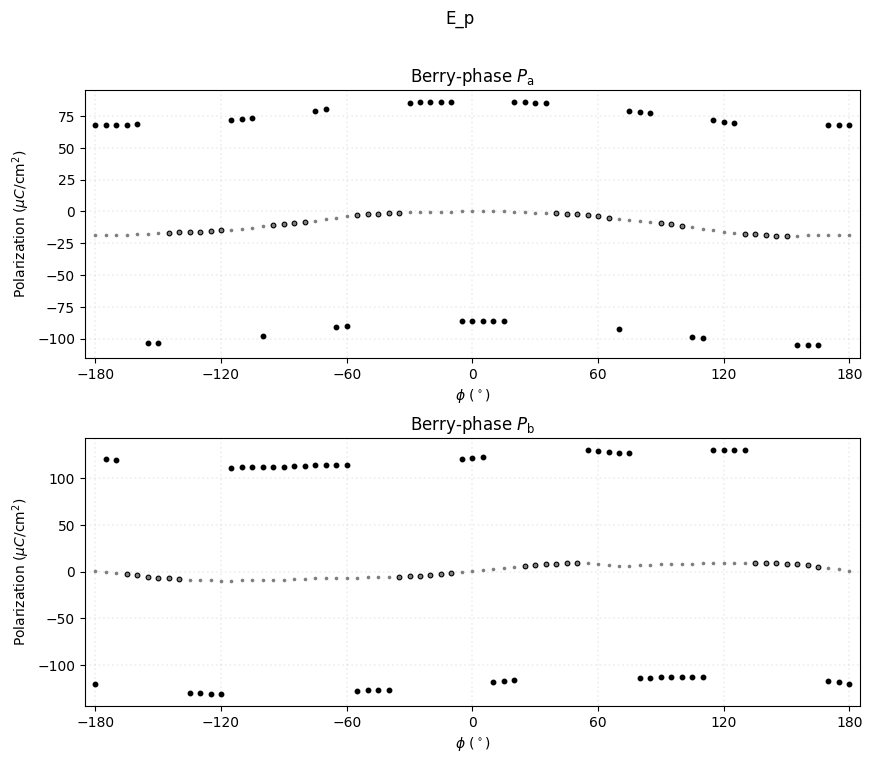

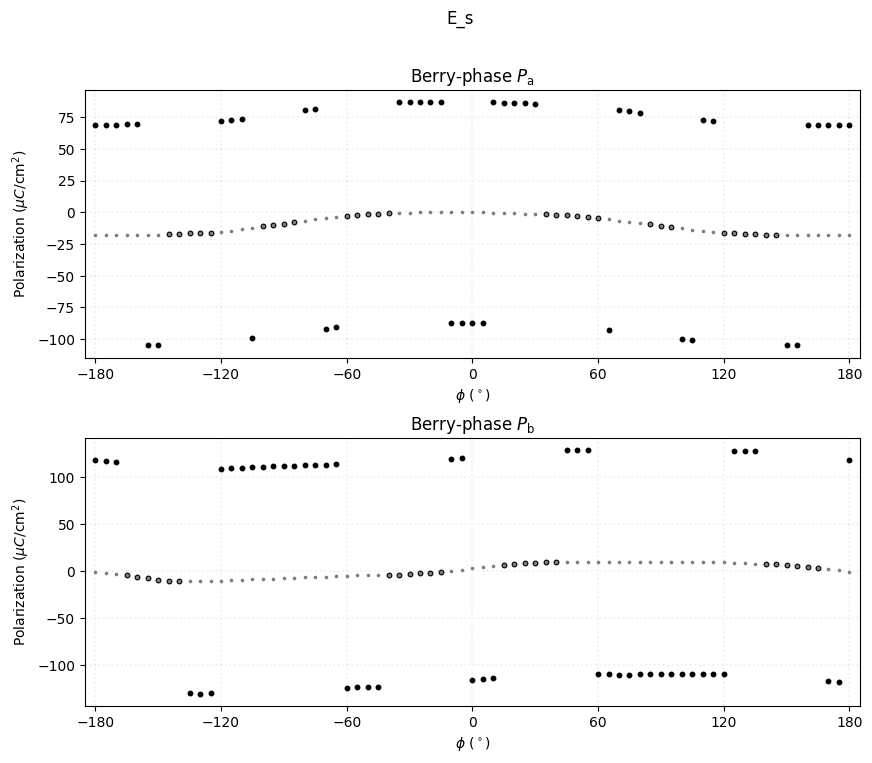

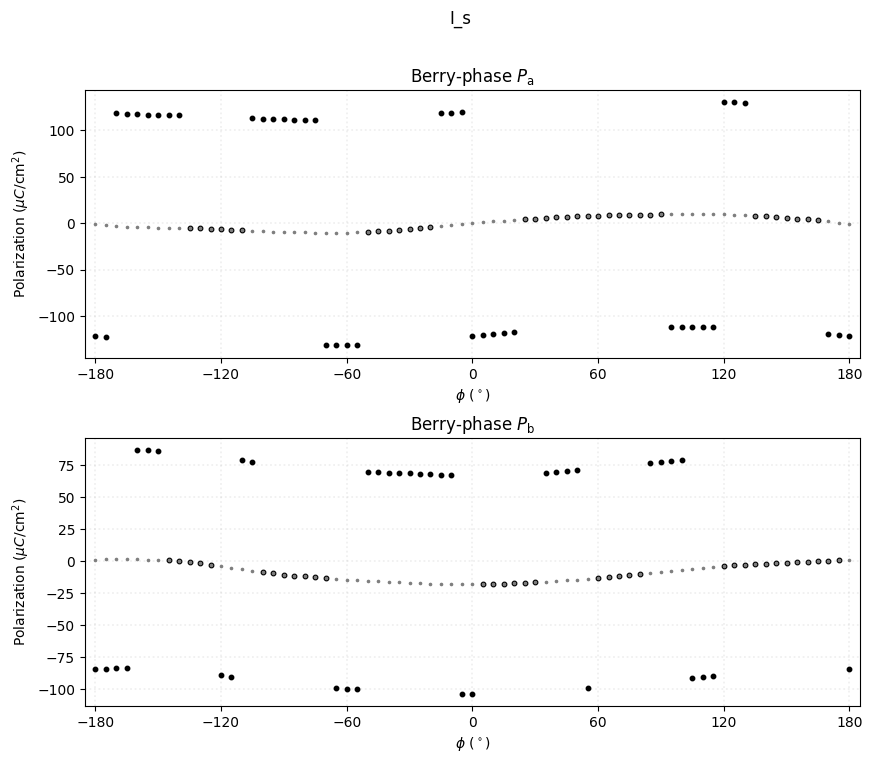

AttributeError: 292 C_s phi180 PVF-3-orig
Could not find fully rotated structure values for label C_s
Could not find fully rotated structure values for label C_s


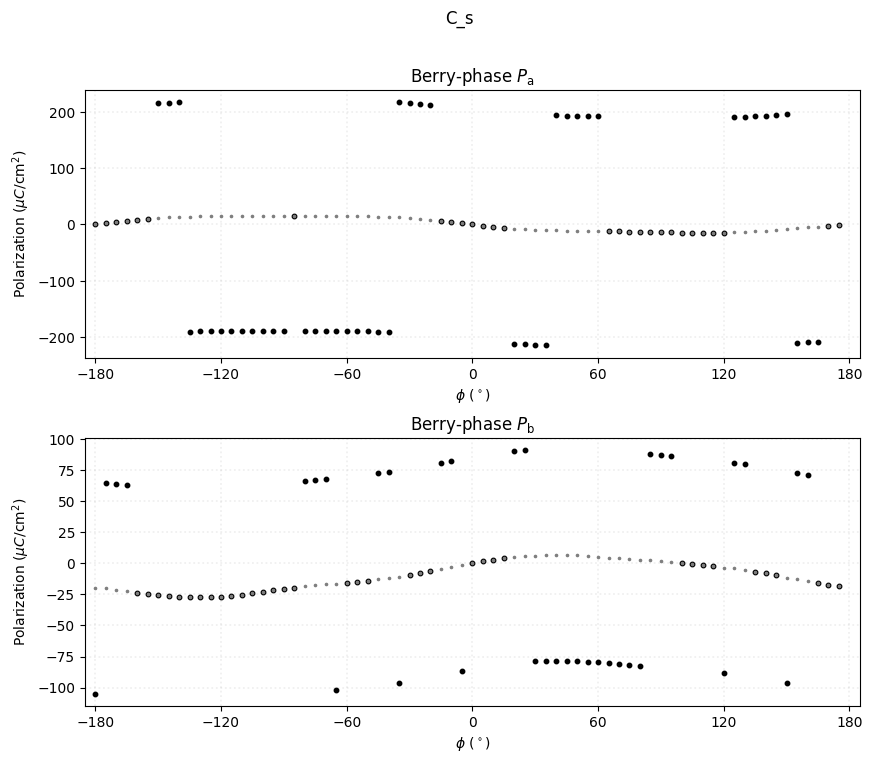

AttributeError: 324 B_s phi-25 PVF-2-new
AttributeError: 352 B_s phi115 PVF-2-new
AttributeError: 353 B_s phi120 PVF-2-new
AttributeError: 354 B_s phi125 PVF-2-new
AttributeError: 362 B_s phi165 PVF-2-new


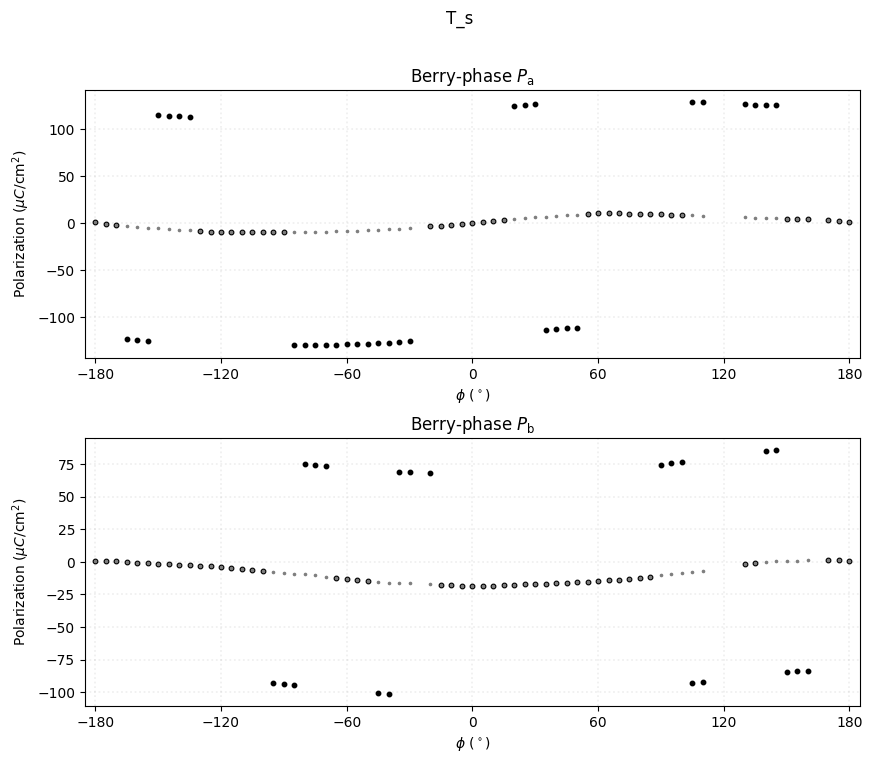

In [7]:
# Establish a connection to the database
db_path = '/home/carlfro/Projects/polymers/individual/PVF_vcrelax/structures.ES0-5.rotated.✔.db'
db = connect(db_path)

# Retrieve and filter rows where 'label' is present, then sort by cohesive energy
rows = [row for row in db.select() if 'label' in row]
rows.sort(key=lambda row: row.rlx_coh_ene)

# Extract unique labels and motifs
labels, motifs, seen = [], {}, set()
for row in rows:
    if row.label not in seen:
        labels.append(row.label)
        motifs[row.label] = row.motif
        seen.add(row.label)
print(labels, motifs)

# Reset matplotlib to default settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

# Dictionaries for storing energies and polarization values for the lowest 5 configurations
energies_low5, polarizations_low5 = {}, {}

# Iterate through each unique label and motif to analyze and plot Berry phases
for label in labels:
    motif = motifs[label]
    berry_phase_a, berry_phase_b, phi_values = [], [], []

    # Collect Berry phase and phi values from the database
    for row in db.select(label=label, motif=motif):
        try:
            berry_phase_a.append(row.berry_phase_a)
            berry_phase_b.append(row.berry_phase_b)
            phi_values.append(float(row.phi.strip('phi')))
        except AttributeError:
            print('AttributeError:', row.id, row.label, row.phi, row.motif)
            continue

    # Skip to next iteration if no data is found
    if not berry_phase_a or not berry_phase_b or not phi_values:
        print('No Berry phase or phi found for label:', label, motif)
        continue

    # Convert lists to numpy arrays and sort them according to phi_values
    berry_phase_a, berry_phase_b, phi_values = map(np.array, (berry_phase_a, berry_phase_b, phi_values))

    # Setup figure and axes for plotting
    fig, axs = plt.subplots(2, gridspec_kw={'hspace': 0.3, 'height_ratios': [1, 1]}, figsize=(10, 8))

    # Process and plot Berry phases
    for berry_phase_values, ax in zip([berry_phase_a, berry_phase_b], axs):
        # Remap berry phases to the same branch for continuity
        p_diff = np.diff(berry_phase_values)
        p_diff_max = np.max(np.abs(p_diff)) * 0.5
        p = np.array([v - p_diff_max if v > p_diff_max/2 else v + p_diff_max if v < -p_diff_max/2 else v for v in berry_phase_values])

        # Plot original and remapped values
        ax.plot(phi_values, berry_phase_values, 'ko', ms=3.2)
        ax.plot(phi_values, p, 'o', ms=1.6, color='tab:gray')
        ax.set_xlabel(r"$\phi$ ($^\circ$)")
        ax.set_ylabel(r'Polarization ($\mu C/{\rm cm}^2$)')
        ax.grid(which='major', linestyle='--', dashes=(5, 8), linewidth='0.25')
        ax.set_xlim([-185, 185])
        ax.set_xticks(np.arange(-180, 181, 60))

        # Attempt to calculate total polarization
        try:
            p0, p180 = p[np.abs(phi_values) <= 0.001][0], p[np.abs(phi_values - 180) <= 0.001][0]
        except IndexError:
            print(f"Could not find fully rotated structure values for label {label}")
            continue

        # Indicate total polarization change with an arrow and label
        ax.annotate("", xy=(195, p0), xytext=(195, p180),
                    arrowprops=dict(arrowstyle="<-", color='k'))
        P_lab = r'P_{\rm a}' if ax == axs[0] else r'P_{\rm b}'
        ax.annotate(rf'${P_lab} = {p180 - p0:.1f}$', xy=(200, (p0 + p180) / 2),
                    ha='left', va='center', fontsize=10)

        # Store results for the lowest 5 configurations
        if ax == axs[1]:
            polarizations_low5[label] = p180 - p0
            energies_low5[label] = row.rlx_coh_ene

    # Configure plot titles and display the plot
    axs[0].set_title('Berry-phase $P_{\\rm a}$')
    axs[1].set_title('Berry-phase $P_{\\rm b}$')
    title = label if label != 'B_s' else 'T_s'
    plt.suptitle(title)
    plt.show()

In [29]:
def average_polarization(energies, polarizations, temperature, k_B=8.617333262e-5):
    """
    Calculate the average polarization at a given temperature.

    :param energies: List of energies [E_0, E_1, ..., E_i]
    :param polarizations: List of polarizations [P_b^0, P_b^1, ..., P_b^i] for each state
    :param temperature: Temperature in Kelvins
    :param k_B: Boltzmann constant (default value in J/K)
    :return: Average polarization <P_b>(T)
    """
    # Compute the excitation energies
    delta_E = np.array(energies) - min(energies)
    print(f"Delta E = {delta_E}")

    # Calculate the Gibbs free energy weights
    weights = np.exp(-delta_E / (k_B * temperature))
    weights /= np.sum(weights)
    print(f"Weights = {weights}")

    # Compute the average polarization
    print(f"g_i(T)P_b^i = {weights * np.array(polarizations)}")
    average_polarization = np.sum(weights * np.array(polarizations))

    return average_polarization

i = 3
print(f"{labels[:i]}")
energies = list(energies_low5.values())[:i]
polarizations = list(polarizations_low5.values())[:i]
temperature = 293  # Example temperature in K
print(f"energies: {energies},\t polarizations: {polarizations}\n")
print(average_polarization(energies, polarizations, temperature))


['E_p', 'E_s', 'I_s']
energies: [-0.7459444870373773, -0.7404556787978436, -0.7384233965938165],	 polarizations: [0.5444099999999992, -3.928379999999976, 19.514479999999992]

Delta E = [0.         0.00548881 0.00752109]
Weights = [0.39261755 0.31590673 0.29147572]
g_i(T)P_b^i = [ 0.21374492 -1.24100167  5.6879971 ]
4.660740359862073
